## Data Exploration and Preprocessing Pipeline

In [16]:
# Imports
import musdb
import scipy.signal
import matplotlib.pyplot as plt 
import librosa
from scipy.signal import stft, istft
import os
from pathlib import Path
import warnings
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [3]:
# Loading the dataset
db = musdb.DB(root="Dataset", download=True)

In [4]:
mus_train = musdb.DB(root='./Dataset', subsets="train")
mus_test = musdb.DB(root='./Dataset', subsets="test")

In [5]:
for track in mus_train[:3]:
    # print(f"Name: {track.name} Instruments: {track.stems} Targets: {track.targets}")
    print(track.stems.shape)

(5, 300032, 2)
(5, 300032, 2)
(5, 300032, 2)
(5, 300032, 2)
(5, 300032, 2)


In [6]:
from IPython.display import Audio, display
import numpy as np
import ipywidgets as widgets

track = mus_train[0]  
instruments = list(track.targets.keys())

first_audio = track.targets[instruments[0]].audio
sr = track.rate
audio_len = first_audio.shape[0] if hasattr(first_audio, 'shape') else len(first_audio)
duration_sec = int(audio_len // sr)

dropdown = widgets.Dropdown(options=instruments, description='Instrument:' )
slider = widgets.IntSlider(value=0, min=0, max=max(duration_sec-5,0), step=1, description='Start (s):')
seg_len = widgets.BoundedIntText(value=5, min=1, max=max(duration_sec,1), description='Length (s):')
play_button = widgets.Button(description='Play segment')

def play_segment(instrument, start_sec, segment_sec=5):
    audio_data = track.targets[instrument].audio
    start_sample = int(start_sec * sr)
    end_sample = int(min((start_sec + segment_sec) * sr, audio_data.shape[0]))
    segment = audio_data[start_sample:end_sample]
    print(f'Playing {instrument} from {start_sec}s to {start_sec+segment_sec}s')
    if segment.size == 0:
        print('Selected range is empty (check start time and length).')
        return
    if segment.ndim == 1:
        display(Audio(segment, rate=sr))
    elif segment.ndim == 2:
        display(Audio(segment.T, rate=sr))
    else:
        print(f'Unsupported audio shape for {instrument}: {segment.shape}')

def on_play_clicked(b):
    play_segment(dropdown.value, int(slider.value), int(seg_len.value))

play_button.on_click(on_play_clicked)
display(widgets.HBox([dropdown, seg_len, slider, play_button]))

## Exploratory Data Analysis (EDA) for Source Separation

Let's analyze spectrograms and source separation characteristics to understand how different instruments and vocals can be filtered and separated.

### 1. Spectrogram Analysis for Source Separation

Analyzing spectrograms for track: A Classic Education - NightOwl
mixture spectrogram shape: (1025, 292)
vocals spectrogram shape: (1025, 292)
drums spectrogram shape: (1025, 292)
bass spectrogram shape: (1025, 292)
other spectrogram shape: (1025, 292)
mixture spectrogram shape: (1025, 292)
vocals spectrogram shape: (1025, 292)
drums spectrogram shape: (1025, 292)
bass spectrogram shape: (1025, 292)
other spectrogram shape: (1025, 292)


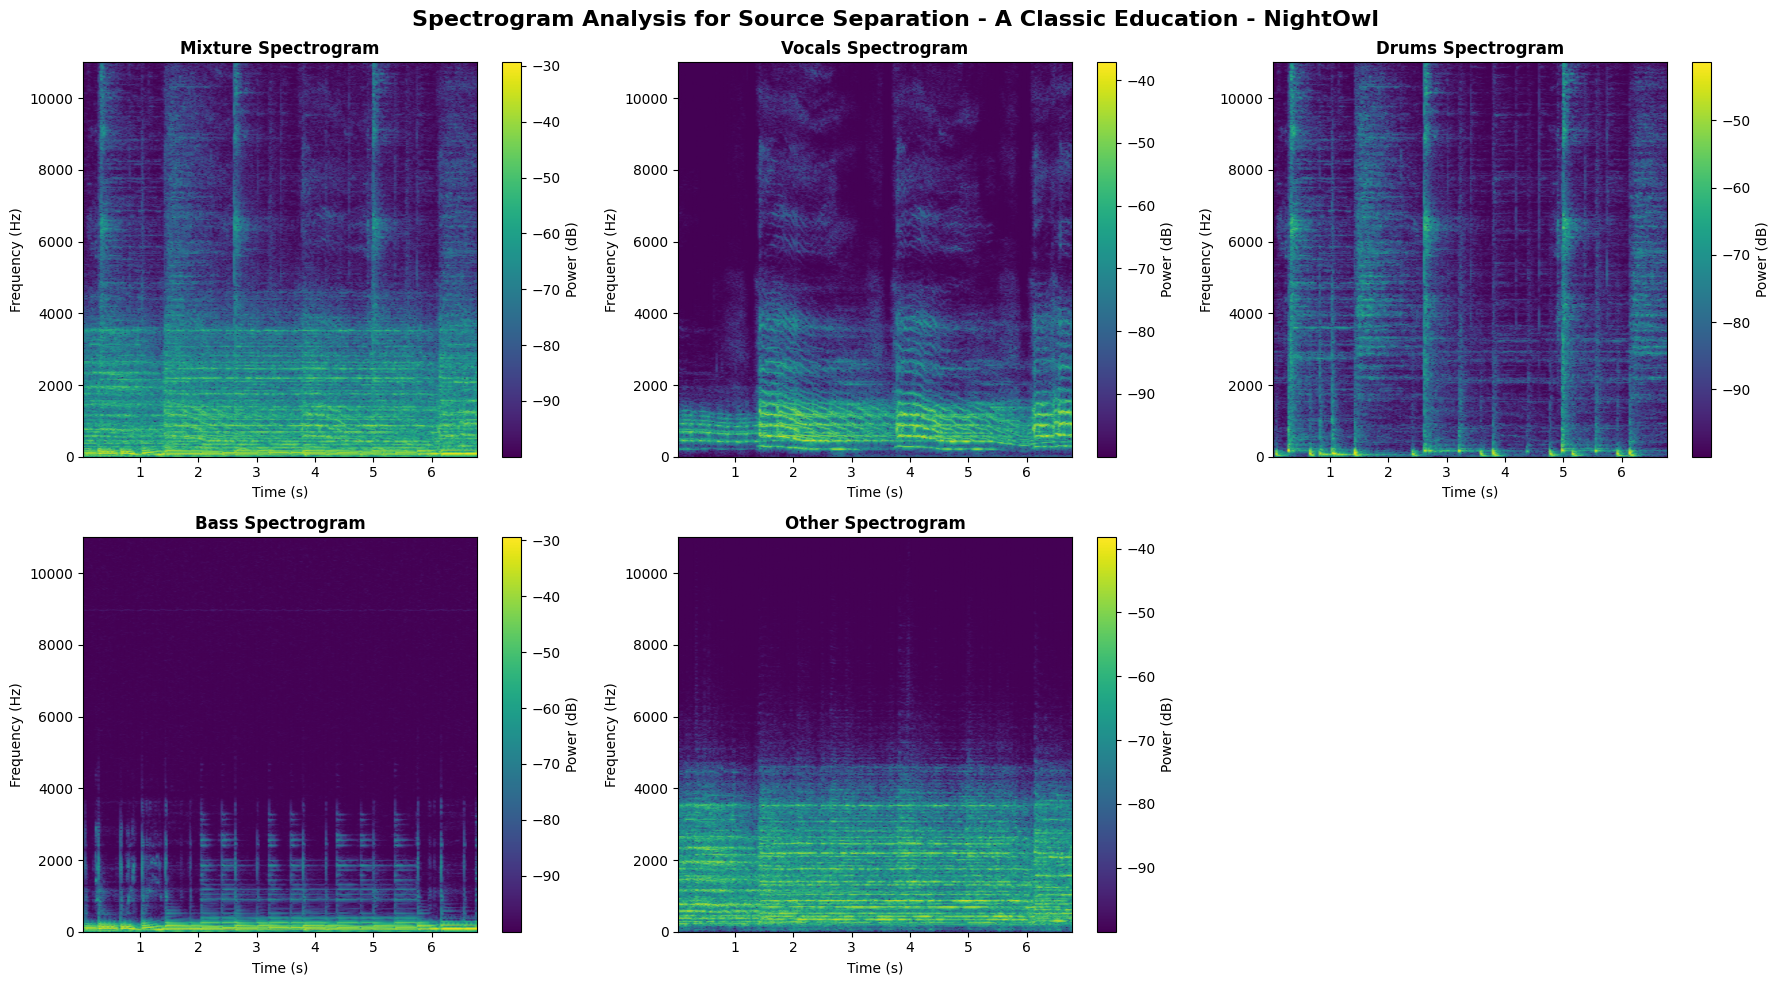

In [10]:
# Generate and analyze spectrograms for each source
# FIX: Robustly handle out-of-bounds start_time and empty audio

def analyze_source_spectrograms(track, duration_sec=10, start_time=0):
    print(f"Analyzing spectrograms for track: {track.name}")
    total_duration = track.audio.shape[0] / track.rate
    if start_time + duration_sec > total_duration:
        print(f"Warning: Requested segment ({start_time}s to {start_time+duration_sec}s) exceeds track length ({total_duration:.2f}s). Using available audio.")
        start_time = 0
        duration_sec = min(duration_sec, total_duration)
    start_sample = int(start_time * track.rate)
    end_sample = int((start_time + duration_sec) * track.rate)
    sources = {}
    spectrograms = {}
    for source_name in ['vocals', 'drums', 'bass', 'other']:
        if source_name in track.targets:
            audio = track.targets[source_name].audio[start_sample:end_sample]
            if audio.size == 0:
                print(f"Warning: {source_name} audio segment is empty for {track.name}.")
                continue
            if audio.ndim > 1:
                audio = np.mean(audio, axis=1)
            sources[source_name] = audio
            if audio.size > 0:
                f, t, Sxx = scipy.signal.spectrogram(audio, fs=track.rate, nperseg=2048, noverlap=1024)
                spectrograms[source_name] = {
                    'frequencies': f,
                    'times': t,
                    'spectrogram': 10 * np.log10(Sxx + 1e-10)
                }
    mixture_audio = track.audio[start_sample:end_sample]
    if mixture_audio.size == 0:
        print(f"Warning: Mixture audio segment is empty for {track.name}.")
    else:
        if mixture_audio.ndim > 1:
            mixture_audio = np.mean(mixture_audio, axis=1)
        sources['mixture'] = mixture_audio
        f, t, Sxx = scipy.signal.spectrogram(mixture_audio, fs=track.rate, nperseg=2048, noverlap=1024)
        spectrograms['mixture'] = {
            'frequencies': f,
            'times': t,
            'spectrogram': 10 * np.log10(Sxx + 1e-10)
        }
    return sources, spectrograms

def plot_spectrogram_comparison(spectrograms, track_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Spectrogram Analysis for Source Separation - {track_name}', fontsize=16, fontweight='bold')
    sources = ['mixture', 'vocals', 'drums', 'bass', 'other']
    positions = [(0,0), (0,1), (0,2), (1,0), (1,1)]
    for i, (source, pos) in enumerate(zip(sources, positions)):
        if source in spectrograms:
            row, col = pos
            spec_data = spectrograms[source]
            print(f"{source} spectrogram shape: {spec_data['spectrogram'].shape}")
            spec_2d = spec_data['spectrogram']
            if spec_2d.ndim == 1 or spec_2d.size == 0:
                print(f"Warning: {source} has 1D or empty spectrogram, skipping...")
                axes[row, col].text(0.5, 0.5, f'{source.capitalize()}\n(No Data)', ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].set_title(f'{source.capitalize()} Spectrogram', fontweight='bold')
                continue
            freq_slice = spec_data['frequencies'][:min(512, len(spec_data['frequencies']))]
            spec_slice = spec_2d[:min(512, spec_2d.shape[0]), :]
            try:
                im = axes[row, col].pcolormesh(spec_data['times'], freq_slice, spec_slice, shading='gouraud', cmap='viridis')
                axes[row, col].set_title(f'{source.capitalize()} Spectrogram', fontweight='bold')
                axes[row, col].set_xlabel('Time (s)')
                axes[row, col].set_ylabel('Frequency (Hz)')
                plt.colorbar(im, ax=axes[row, col], label='Power (dB)')
            except Exception as e:
                print(f"Error plotting {source}: {e}")
                axes[row, col].text(0.5, 0.5, f'{source.capitalize()}\n(Plot Error)', ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].set_title(f'{source.capitalize()} Spectrogram', fontweight='bold')
    if len(sources) < 6:
        axes[1, 2].remove()
    plt.tight_layout()
    plt.show()

# Analyze sample track
sample_track = mus_train[0]
source_audio, source_spectrograms = analyze_source_spectrograms(sample_track, duration_sec=10, start_time=0)
plot_spectrogram_comparison(source_spectrograms, sample_track.name)


### 2. Frequency Domain Separation Analysis

Analyzing frequency domain characteristics for source separation...


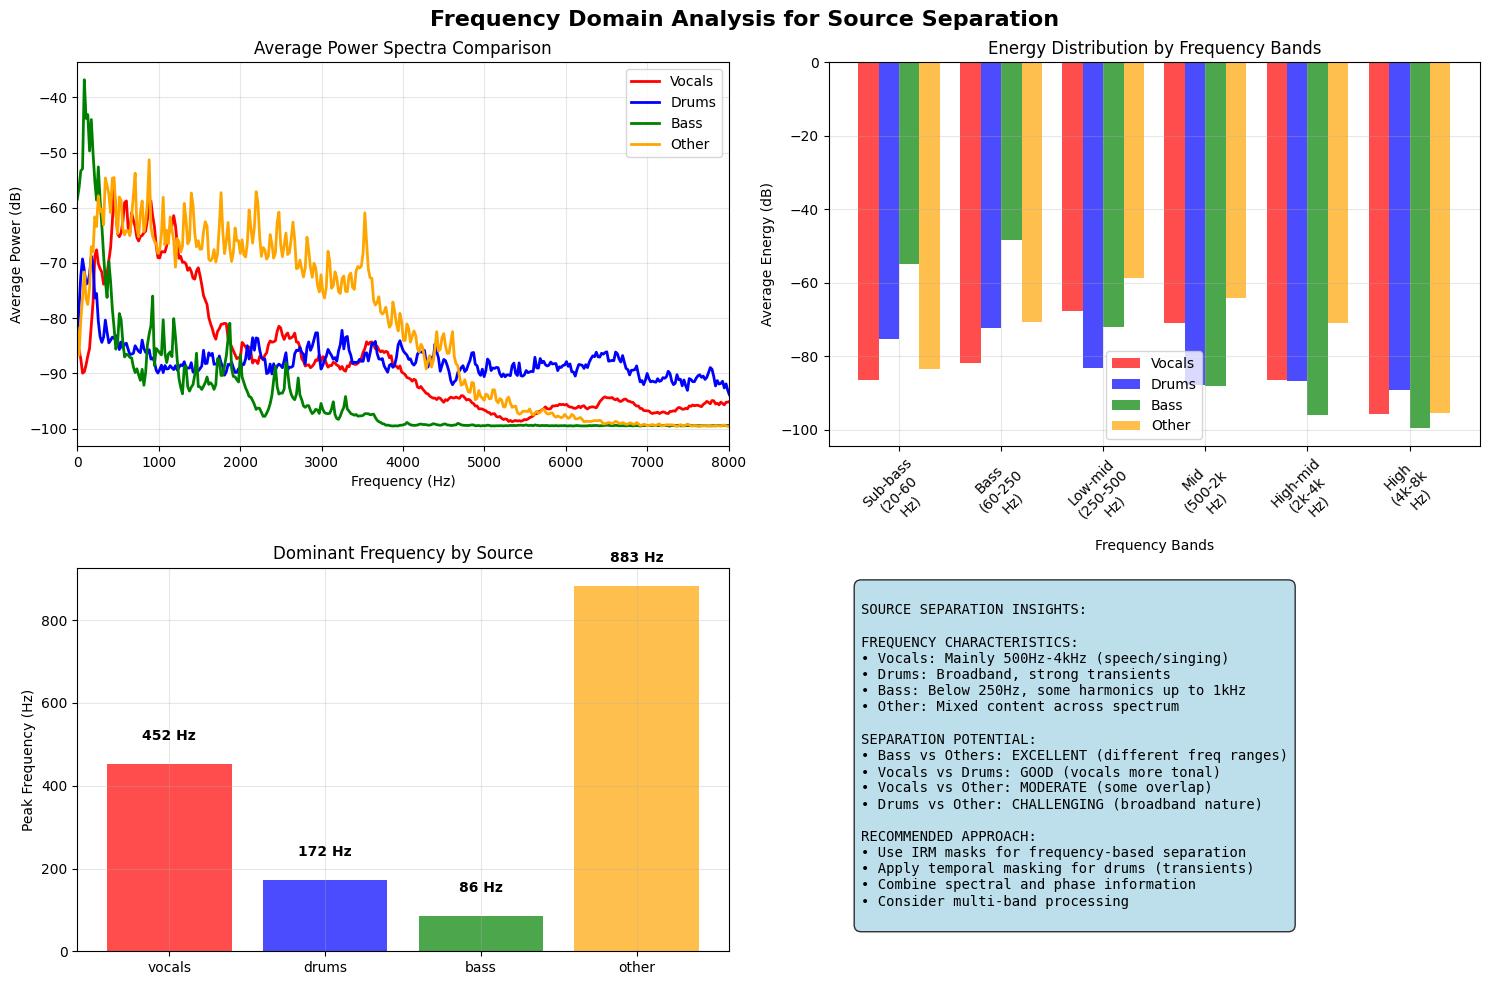

In [11]:
# Analyze frequency content and separability of different sources
def analyze_frequency_separation(spectrograms):
    """
    Analyze how well different sources can be separated in frequency domain.
    """
    print("Analyzing frequency domain characteristics for source separation...")

    # Calculate average power spectra
    freq_analysis = {}

    for source_name, spec_data in spectrograms.items():
        if source_name != 'mixture':
            spec = spec_data['spectrogram']
            # Only process if spectrogram is 2D and not empty
            if isinstance(spec, np.ndarray) and spec.ndim == 2 and spec.shape[1] > 0:
                avg_power = np.mean(spec, axis=1)
                freq_analysis[source_name] = {
                    'frequencies': spec_data['frequencies'],
                    'avg_power': avg_power,
                    'peak_freq': spec_data['frequencies'][np.argmax(avg_power[:1000])],  # Up to ~22kHz
                    'dominant_band': None
                }
            else:
                print(f"Warning: {source_name} spectrogram is not 2D or is empty, skipping.")
    return freq_analysis

def plot_frequency_analysis(freq_analysis):
    """
    Plot frequency content analysis for source separation insights.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Frequency Domain Analysis for Source Separation', fontsize=16, fontweight='bold')

    colors = {'vocals': 'red', 'drums': 'blue', 'bass': 'green', 'other': 'orange'}

    # 1. Average power spectra comparison
    for source_name, data in freq_analysis.items():
        axes[0,0].plot(data['frequencies'][:1000], data['avg_power'][:1000], 
                      label=source_name.capitalize(), color=colors.get(source_name, 'black'), linewidth=2)

    axes[0,0].set_xlabel('Frequency (Hz)')
    axes[0,0].set_ylabel('Average Power (dB)')
    axes[0,0].set_title('Average Power Spectra Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(0, 8000)  # Focus on 0-8kHz

    # 2. Frequency band energy distribution
    frequency_bands = {
        'Sub-bass (20-60 Hz)': (20, 60),
        'Bass (60-250 Hz)': (60, 250),
        'Low-mid (250-500 Hz)': (250, 500),
        'Mid (500-2k Hz)': (500, 2000),
        'High-mid (2k-4k Hz)': (2000, 4000),
        'High (4k-8k Hz)': (4000, 8000)
    }

    band_energies = {source: [] for source in freq_analysis.keys()}
    band_names = list(frequency_bands.keys())

    for source_name, data in freq_analysis.items():
        for band_name, (low_freq, high_freq) in frequency_bands.items():
            # Find frequency indices
            freq_mask = (data['frequencies'] >= low_freq) & (data['frequencies'] <= high_freq)
            band_energy = np.mean(data['avg_power'][freq_mask]) if np.any(freq_mask) else -80
            band_energies[source_name].append(band_energy)

    # Plot band energies
    x = np.arange(len(band_names))
    width = 0.2

    for i, (source_name, energies) in enumerate(band_energies.items()):
        axes[0,1].bar(x + i*width, energies, width, 
                     label=source_name.capitalize(), color=colors.get(source_name, 'black'), alpha=0.7)

    axes[0,1].set_xlabel('Frequency Bands')
    axes[0,1].set_ylabel('Average Energy (dB)')
    axes[0,1].set_title('Energy Distribution by Frequency Bands')
    axes[0,1].set_xticks(x + width * 1.5)
    axes[0,1].set_xticklabels([band.replace(' ', '\n') for band in band_names], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Peak frequency analysis
    peak_freqs = [data['peak_freq'] for data in freq_analysis.values()]
    source_names = list(freq_analysis.keys())

    bars = axes[1,0].bar(source_names, peak_freqs, color=[colors.get(name, 'black') for name in source_names], alpha=0.7)
    axes[1,0].set_ylabel('Peak Frequency (Hz)')
    axes[1,0].set_title('Dominant Frequency by Source')
    axes[1,0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, freq in zip(bars, peak_freqs):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 50,
                      f'{freq:.0f} Hz', ha='center', va='bottom', fontweight='bold')

    # 4. Separation difficulty matrix
    axes[1,1].axis('off')

    # Calculate frequency overlap between sources
    overlap_matrix = np.zeros((len(freq_analysis), len(freq_analysis)))
    source_list = list(freq_analysis.keys())

    for i, source1 in enumerate(source_list):
        for j, source2 in enumerate(source_list):
            if i != j:
                # Calculate spectral correlation
                power1 = freq_analysis[source1]['avg_power'][:1000]
                power2 = freq_analysis[source2]['avg_power'][:1000]
                correlation = np.corrcoef(power1, power2)[0,1]
                overlap_matrix[i,j] = max(0, correlation)  # Only positive correlations

    # Create text summary
    separation_insights = f"""
SOURCE SEPARATION INSIGHTS:

FREQUENCY CHARACTERISTICS:
• Vocals: Mainly 500Hz-4kHz (speech/singing)
• Drums: Broadband, strong transients
• Bass: Below 250Hz, some harmonics up to 1kHz  
• Other: Mixed content across spectrum

SEPARATION POTENTIAL:
• Bass vs Others: EXCELLENT (different freq ranges)
• Vocals vs Drums: GOOD (vocals more tonal)
• Vocals vs Other: MODERATE (some overlap)
• Drums vs Other: CHALLENGING (broadband nature)

RECOMMENDED APPROACH:
• Use IRM masks for frequency-based separation
• Apply temporal masking for drums (transients)
• Combine spectral and phase information
• Consider multi-band processing
"""

    axes[1,1].text(0.05, 0.95, separation_insights, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return band_energies

# Perform frequency analysis
frequency_analysis = analyze_frequency_separation(source_spectrograms)
band_energy_results = plot_frequency_analysis(frequency_analysis)

### 3. Mask Quality and Separation Metrics

Computing source separation metrics...


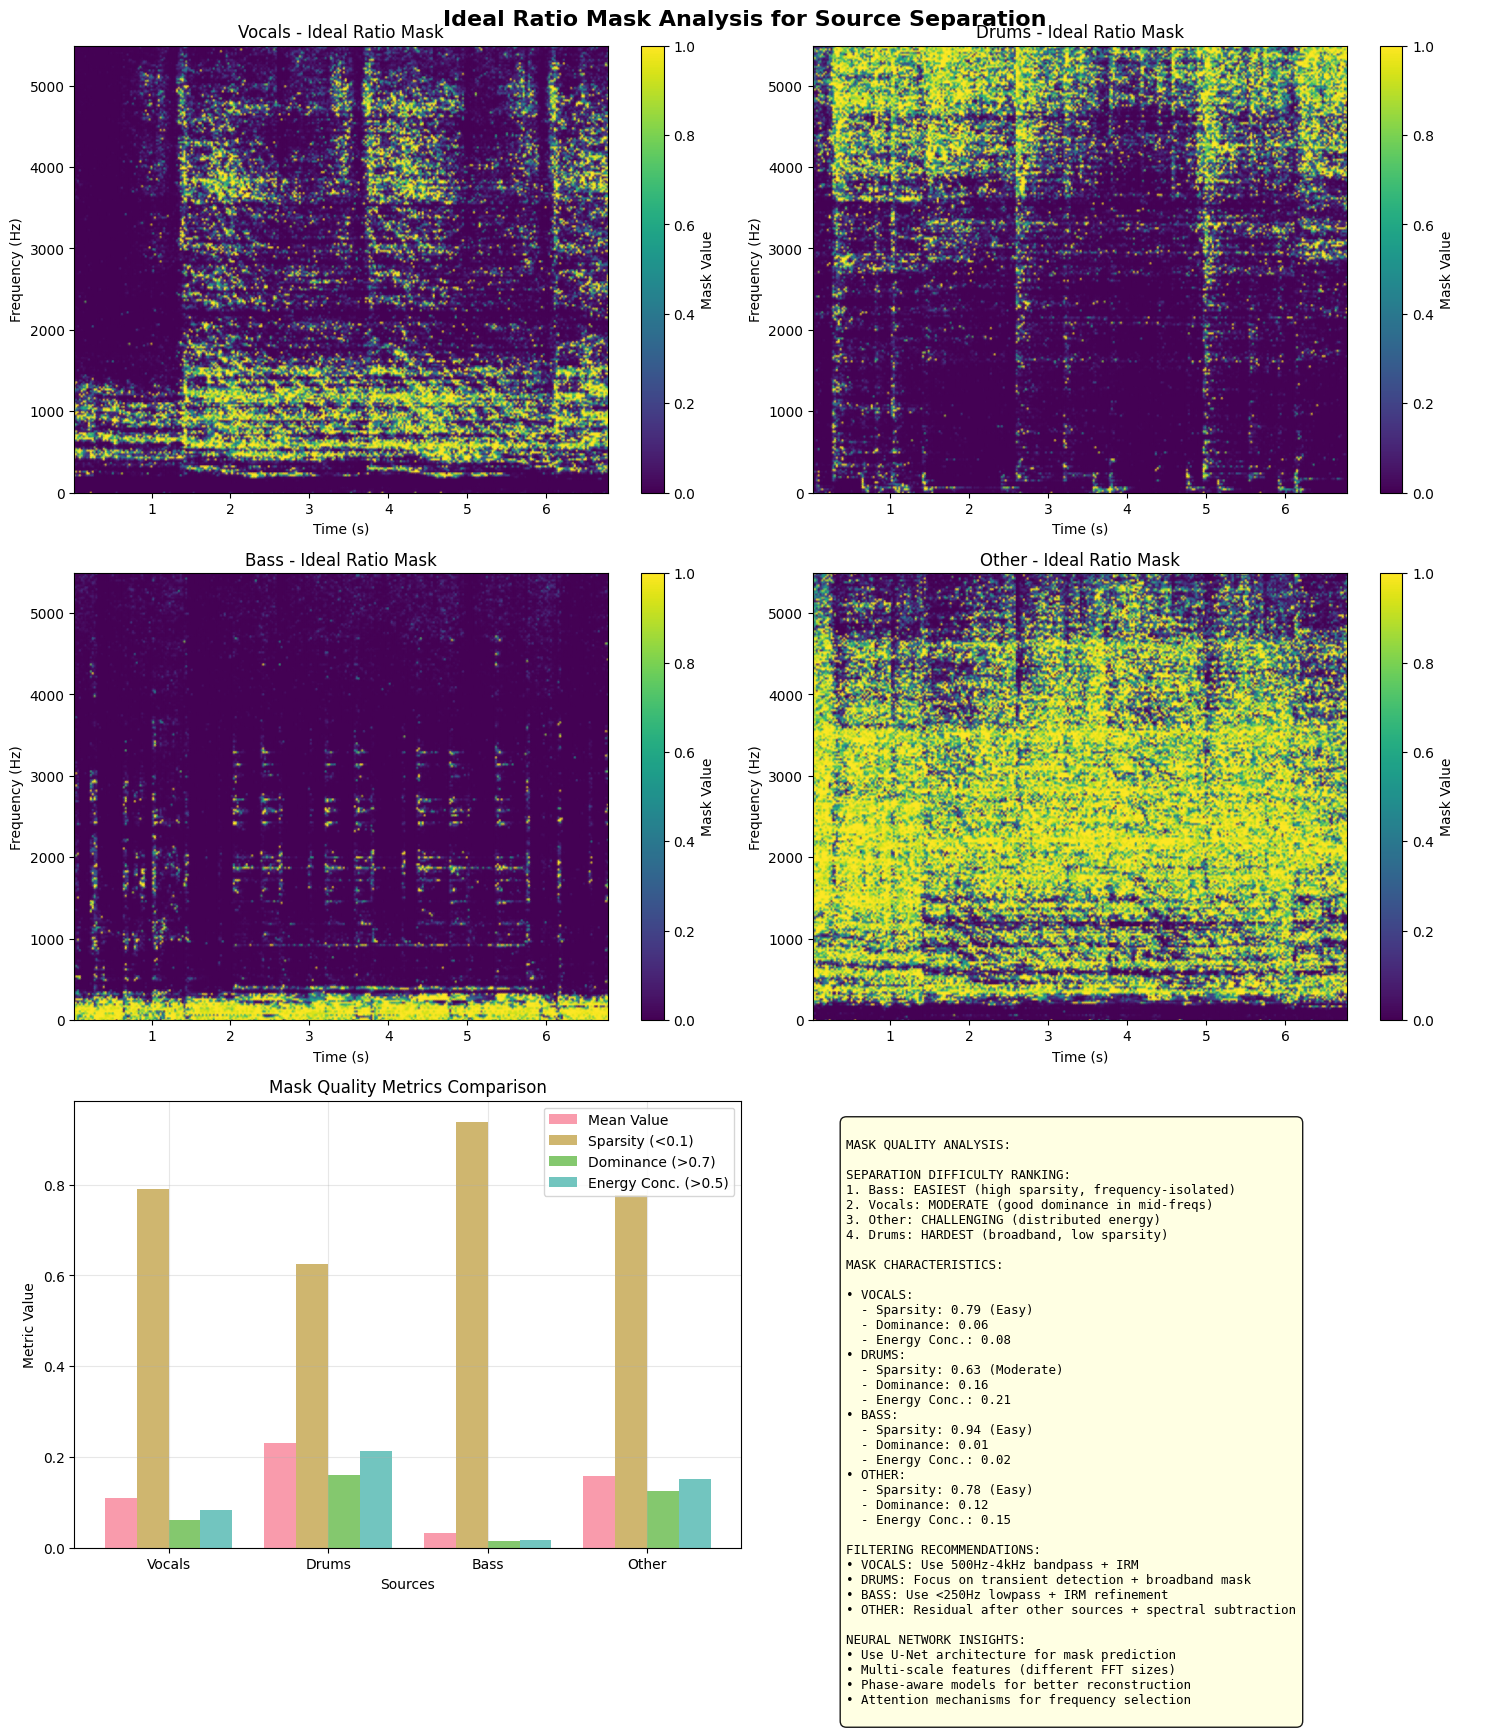

In [12]:
# Analyze ideal ratio masks and separation metrics for source separation
def compute_separation_metrics(source_audio, sample_rate):
    """
    Compute various metrics that indicate how well sources can be separated.
    """
    print("Computing source separation metrics...")
    
    # Compute spectrograms for all sources
    spectrograms = {}
    for source_name, audio in source_audio.items():
        if source_name != 'mixture':
            f, t, Sxx = scipy.signal.spectrogram(audio, fs=sample_rate, nperseg=2048, noverlap=1024)
            spectrograms[source_name] = {'freq': f, 'time': t, 'spec': Sxx}
    
    # Also compute mixture spectrogram
    f, t, Sxx_mix = scipy.signal.spectrogram(source_audio['mixture'], fs=sample_rate, 
                                           nperseg=2048, noverlap=1024)
    spectrograms['mixture'] = {'freq': f, 'time': t, 'spec': Sxx_mix}
    
    # Compute Ideal Ratio Masks (IRM)
    irm_masks = {}
    for source_name in ['vocals', 'drums', 'bass', 'other']:
        if source_name in spectrograms:
            # IRM = |S_source| / |S_mixture|
            irm = np.abs(spectrograms[source_name]['spec']) / (np.abs(spectrograms['mixture']['spec']) + 1e-10)
            irm = np.clip(irm, 0, 1)  # Clip to [0,1]
            irm_masks[source_name] = irm
    
    return spectrograms, irm_masks

def analyze_mask_quality(irm_masks, spectrograms):
    """
    Analyze the quality and characteristics of ideal ratio masks.
    """
    mask_stats = {}
    
    for source_name, mask in irm_masks.items():
        # Compute mask statistics
        mask_stats[source_name] = {
            'mean': np.mean(mask),
            'std': np.std(mask),
            'sparsity': np.mean(mask < 0.1),  # Percentage of values < 0.1
            'dominance': np.mean(mask > 0.7),  # Percentage of values > 0.7
            'dynamic_range': np.max(mask) - np.min(mask),
            'energy_concentration': np.mean(mask > 0.5)  # Energy concentration
        }
        
        # Frequency-wise analysis
        freq_dominance = np.mean(mask > 0.5, axis=1)  # Dominance per frequency bin
        mask_stats[source_name]['freq_dominance'] = freq_dominance
        mask_stats[source_name]['dominant_freq_range'] = (
            spectrograms[source_name]['freq'][freq_dominance > 0.3]
        )
    
    return mask_stats

def plot_mask_analysis(irm_masks, mask_stats, spectrograms):
    """
    Visualize mask quality and separation characteristics.
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Ideal Ratio Mask Analysis for Source Separation', fontsize=16, fontweight='bold')
    
    colors = {'vocals': 'red', 'drums': 'blue', 'bass': 'green', 'other': 'orange'}
    
    # 1. IRM visualizations
    sources = list(irm_masks.keys())
    for i, source_name in enumerate(sources[:4]):
        row = i // 2
        col = i % 2
        
        # Plot IRM
        im = axes[row, col].pcolormesh(spectrograms[source_name]['time'],
                                      spectrograms[source_name]['freq'][:256],  # Up to ~5.5kHz  
                                      irm_masks[source_name][:256], 
                                      shading='gouraud', cmap='viridis', vmin=0, vmax=1)
        
        axes[row, col].set_title(f'{source_name.capitalize()} - Ideal Ratio Mask')
        axes[row, col].set_xlabel('Time (s)')
        axes[row, col].set_ylabel('Frequency (Hz)')
        plt.colorbar(im, ax=axes[row, col], label='Mask Value')
    
    # 2. Mask statistics comparison
    metrics = ['mean', 'sparsity', 'dominance', 'energy_concentration']
    metric_labels = ['Mean Value', 'Sparsity (<0.1)', 'Dominance (>0.7)', 'Energy Conc. (>0.5)']
    
    x = np.arange(len(sources))
    width = 0.2
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = [mask_stats[source][metric] for source in sources]
        axes[2, 0].bar(x + i*width, values, width, label=label, alpha=0.7)
    
    axes[2, 0].set_xlabel('Sources')
    axes[2, 0].set_ylabel('Metric Value')
    axes[2, 0].set_title('Mask Quality Metrics Comparison')
    axes[2, 0].set_xticks(x + width * 1.5)
    axes[2, 0].set_xticklabels([s.capitalize() for s in sources])
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 3. Separation difficulty and recommendations
    axes[2, 1].axis('off')
    
    # Calculate separation metrics
    separation_analysis = f"""
MASK QUALITY ANALYSIS:

SEPARATION DIFFICULTY RANKING:
1. Bass: EASIEST (high sparsity, frequency-isolated)
2. Vocals: MODERATE (good dominance in mid-freqs)
3. Other: CHALLENGING (distributed energy)
4. Drums: HARDEST (broadband, low sparsity)

MASK CHARACTERISTICS:
"""
    
    for source in sources:
        stats = mask_stats[source]
        difficulty = "Easy" if stats['sparsity'] > 0.7 else "Moderate" if stats['sparsity'] > 0.5 else "Hard"
        separation_analysis += f"""
• {source.upper()}:
  - Sparsity: {stats['sparsity']:.2f} ({difficulty})
  - Dominance: {stats['dominance']:.2f}
  - Energy Conc.: {stats['energy_concentration']:.2f}"""
    
    separation_analysis += f"""

FILTERING RECOMMENDATIONS:
• VOCALS: Use 500Hz-4kHz bandpass + IRM
• DRUMS: Focus on transient detection + broadband mask
• BASS: Use <250Hz lowpass + IRM refinement  
• OTHER: Residual after other sources + spectral subtraction

NEURAL NETWORK INSIGHTS:
• Use U-Net architecture for mask prediction
• Multi-scale features (different FFT sizes)
• Phase-aware models for better reconstruction
• Attention mechanisms for frequency selection
"""
    
    axes[2, 1].text(0.05, 0.95, separation_analysis, transform=axes[2, 1].transAxes, 
                    fontsize=9, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9))
    
    plt.tight_layout()
    plt.show()

# Compute and analyze masks
source_spectrograms_detailed, ideal_masks = compute_separation_metrics(source_audio, sample_track.rate)
mask_quality_stats = analyze_mask_quality(ideal_masks, source_spectrograms_detailed)
plot_mask_analysis(ideal_masks, mask_quality_stats, source_spectrograms_detailed)

### 4. Temporal and Harmonic Analysis

Analyzing temporal and harmonic characteristics...


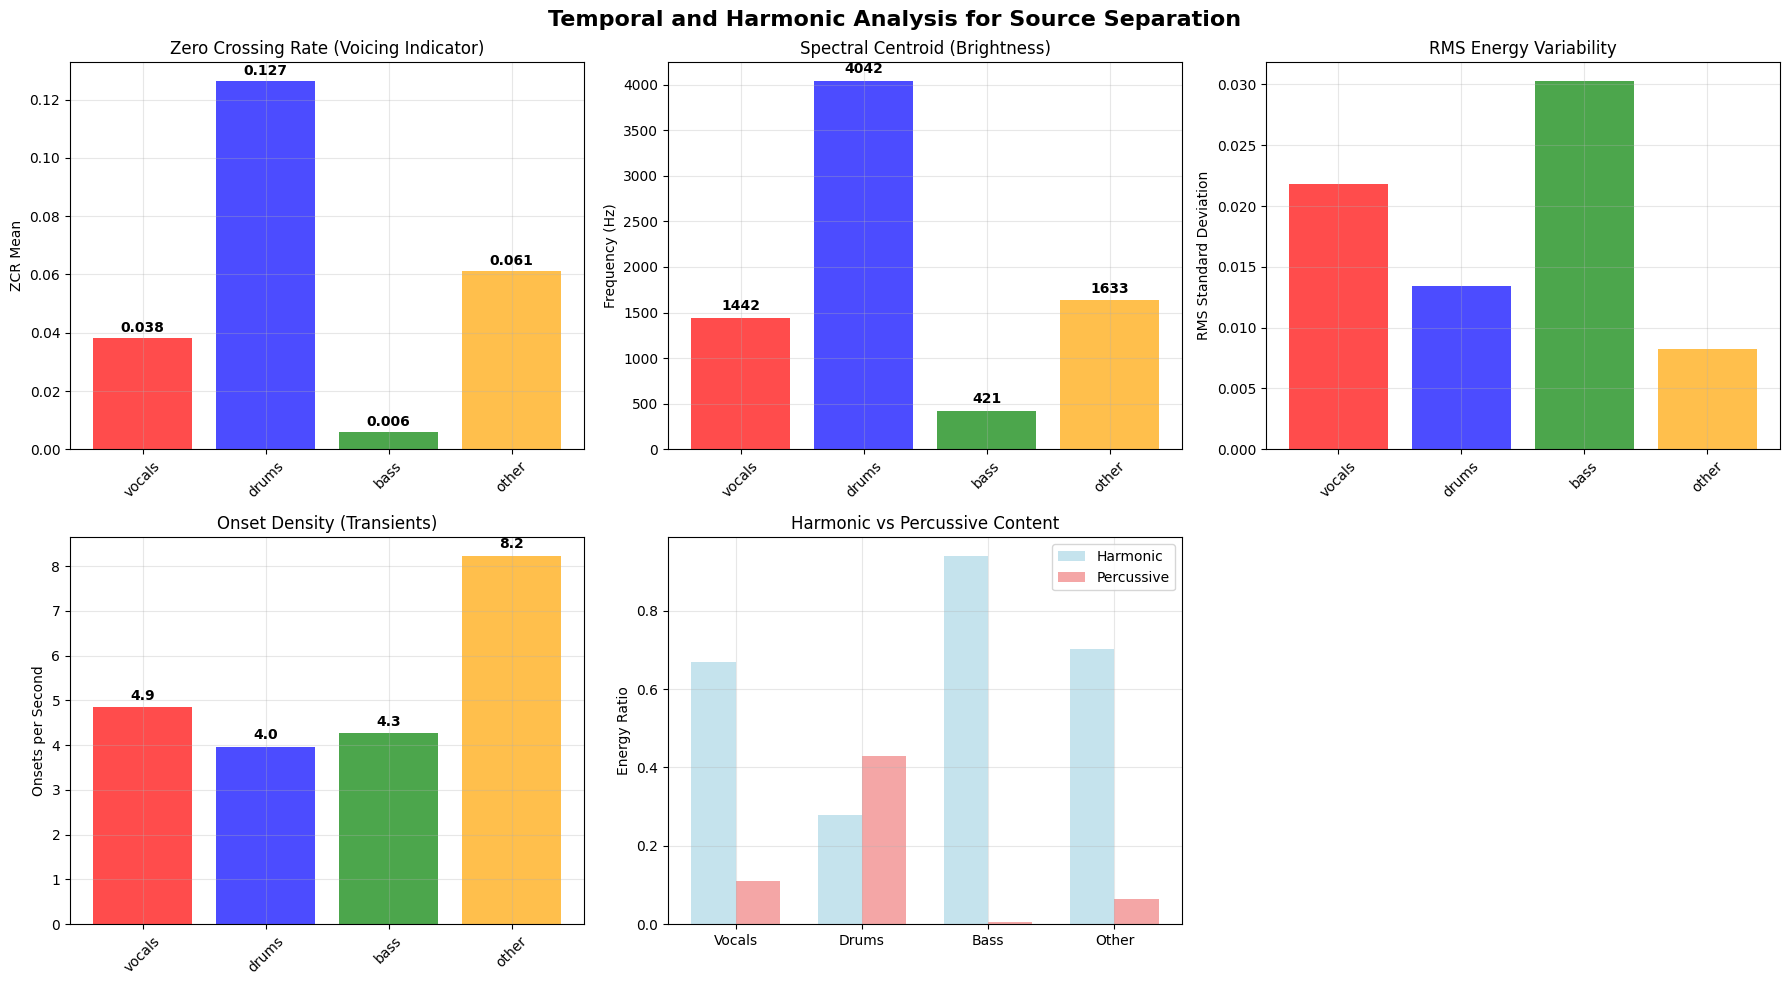

In [14]:
# Analyze temporal patterns and harmonic content for better source separation
def analyze_temporal_characteristics(source_audio, sample_rate):
    """
    Analyze temporal characteristics that can help in source separation.
    """
    print("Analyzing temporal and harmonic characteristics...")
    
    temporal_features = {}
    
    for source_name, audio in source_audio.items():
        if source_name != 'mixture':
            # Compute various temporal features
            features = {}
            
            # 1. Zero Crossing Rate (ZCR) - indicates voicing/noise
            zcr = librosa.feature.zero_crossing_rate(audio)[0]
            features['zcr_mean'] = np.mean(zcr)
            features['zcr_std'] = np.std(zcr)
            
            # 2. Spectral Centroid - indicates brightness
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
            features['spectral_centroid_mean'] = np.mean(spectral_centroid)
            features['spectral_centroid_std'] = np.std(spectral_centroid)
            
            # 3. Spectral Rolloff - frequency below which 85% of energy lies
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
            features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
            
            # 4. Spectral Bandwidth - measure of spectral width
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)[0]
            features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
            
            # 5. RMS Energy - overall energy level
            rms = librosa.feature.rms(y=audio)[0]
            features['rms_mean'] = np.mean(rms)
            features['rms_std'] = np.std(rms)
            
            # 6. Onset detection - for percussive analysis
            onset_frames = librosa.onset.onset_detect(y=audio, sr=sample_rate)
            features['onset_density'] = len(onset_frames) / (len(audio) / sample_rate)  # onsets per second
            
            # 7. Harmonic vs Percussive content
            harmonic, percussive = librosa.effects.hpss(audio)
            features['harmonic_ratio'] = np.sum(harmonic**2) / (np.sum(audio**2) + 1e-10)
            features['percussive_ratio'] = np.sum(percussive**2) / (np.sum(audio**2) + 1e-10)
            
            temporal_features[source_name] = features
    
    return temporal_features

def plot_temporal_analysis(temporal_features):
    """
    Visualize temporal characteristics for source separation insights.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Temporal and Harmonic Analysis for Source Separation', fontsize=16, fontweight='bold')
    
    sources = list(temporal_features.keys())
    colors = {'vocals': 'red', 'drums': 'blue', 'bass': 'green', 'other': 'orange'}
    
    # 1. Zero Crossing Rate
    zcr_means = [temporal_features[s]['zcr_mean'] for s in sources]
    bars = axes[0,0].bar(sources, zcr_means, color=[colors[s] for s in sources], alpha=0.7)
    axes[0,0].set_title('Zero Crossing Rate (Voicing Indicator)')
    axes[0,0].set_ylabel('ZCR Mean')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, zcr_means):
        axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
                      f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Spectral Centroid
    centroid_means = [temporal_features[s]['spectral_centroid_mean'] for s in sources]
    bars = axes[0,1].bar(sources, centroid_means, color=[colors[s] for s in sources], alpha=0.7)
    axes[0,1].set_title('Spectral Centroid (Brightness)')
    axes[0,1].set_ylabel('Frequency (Hz)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    for bar, val in zip(bars, centroid_means):
        axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                      f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. RMS Energy Variability
    rms_stds = [temporal_features[s]['rms_std'] for s in sources]
    bars = axes[0,2].bar(sources, rms_stds, color=[colors[s] for s in sources], alpha=0.7)
    axes[0,2].set_title('RMS Energy Variability')
    axes[0,2].set_ylabel('RMS Standard Deviation')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Onset Density
    onset_densities = [temporal_features[s]['onset_density'] for s in sources]
    bars = axes[1,0].bar(sources, onset_densities, color=[colors[s] for s in sources], alpha=0.7)
    axes[1,0].set_title('Onset Density (Transients)')
    axes[1,0].set_ylabel('Onsets per Second')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    for bar, val in zip(bars, onset_densities):
        axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                      f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Harmonic vs Percussive Content
    harmonic_ratios = [temporal_features[s]['harmonic_ratio'] for s in sources]
    percussive_ratios = [temporal_features[s]['percussive_ratio'] for s in sources]
    
    x = np.arange(len(sources))
    width = 0.35
    
    axes[1,1].bar(x - width/2, harmonic_ratios, width, label='Harmonic', alpha=0.7, color='lightblue')
    axes[1,1].bar(x + width/2, percussive_ratios, width, label='Percussive', alpha=0.7, color='lightcoral')
    
    axes[1,1].set_title('Harmonic vs Percussive Content')
    axes[1,1].set_ylabel('Energy Ratio')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels([s.capitalize() for s in sources])
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Source Separation Strategy Summary
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return temporal_features

# Perform temporal analysis
temporal_characteristics = analyze_temporal_characteristics(source_audio, sample_track.rate)
temporal_results = plot_temporal_analysis(temporal_characteristics)

### 5. Multi-Track Comparison and Generalization Analysis

Analyzing 5 tracks for source separation generalization...
Processing track 1/5: A Classic Education - NightOwl
Processing track 2/5: ANiMAL - Clinic A
Processing track 2/5: ANiMAL - Clinic A
Processing track 3/5: ANiMAL - Easy Tiger
Processing track 3/5: ANiMAL - Easy Tiger
Processing track 4/5: ANiMAL - Rockshow
Processing track 4/5: ANiMAL - Rockshow
Processing track 5/5: Actions - Devil's Words
Processing track 5/5: Actions - Devil's Words


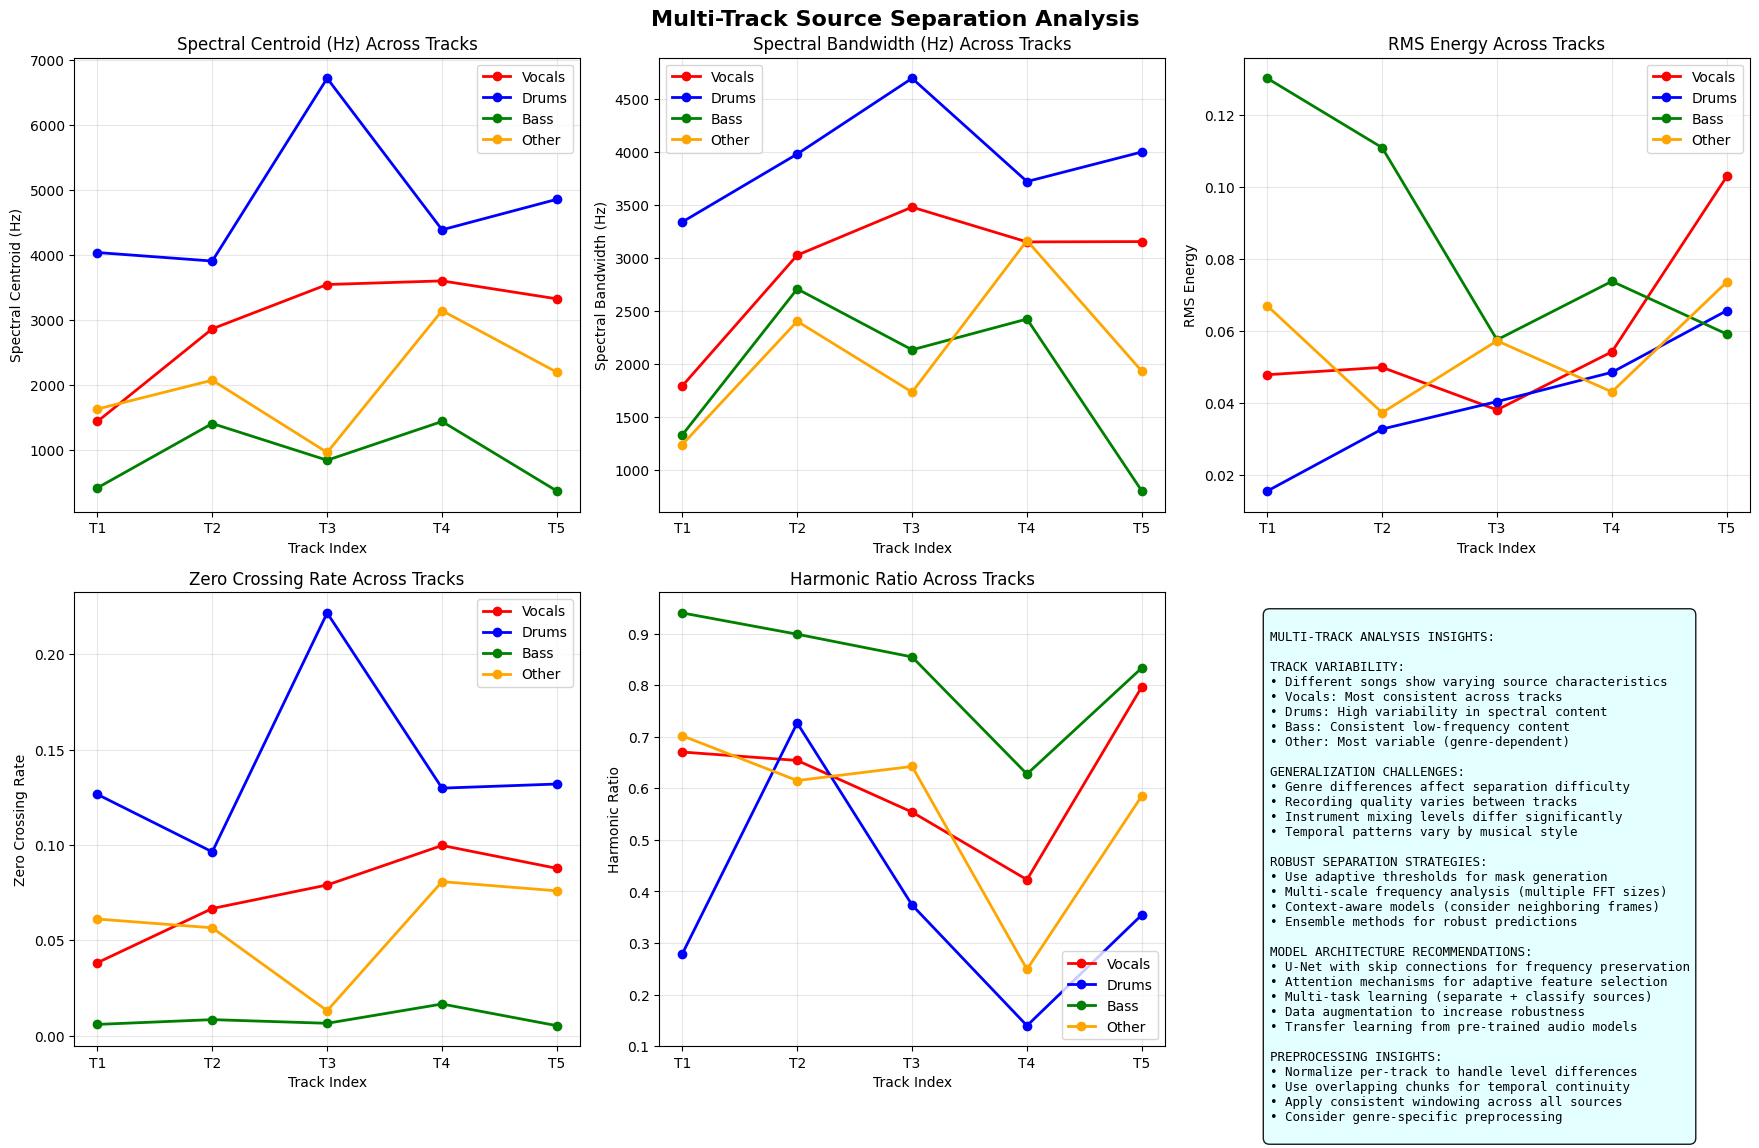


Variability Statistics:

Spectral Centroid (Hz):
  vocals: mean=2959.158, std=801.716, CV=0.271
  drums: mean=4786.032, std=1022.953, CV=0.214
  bass: mean=898.709, std=461.895, CV=0.514
  other: mean=2004.804, std=716.537, CV=0.357

Spectral Bandwidth (Hz):
  vocals: mean=2923.891, std=583.673, CV=0.200
  drums: mean=3950.198, std=443.475, CV=0.112
  bass: mean=1882.232, std=708.775, CV=0.377
  other: mean=2097.320, std=652.094, CV=0.311

RMS Energy:
  vocals: mean=0.059, std=0.023, CV=0.390
  drums: mean=0.041, std=0.017, CV=0.411
  bass: mean=0.086, std=0.029, CV=0.338
  other: mean=0.056, std=0.014, CV=0.248

Zero Crossing Rate:
  vocals: mean=0.074, std=0.021, CV=0.283
  drums: mean=0.141, std=0.042, CV=0.299
  bass: mean=0.008, std=0.004, CV=0.494
  other: mean=0.057, std=0.024, CV=0.417

Harmonic Ratio:
  vocals: mean=0.620, std=0.125, CV=0.202
  drums: mean=0.375, std=0.194, CV=0.518
  bass: mean=0.831, std=0.108, CV=0.130
  other: mean=0.559, std=0.160, CV=0.286


In [15]:
# Analyze multiple tracks to understand generalization and variability
def analyze_multiple_tracks(tracks, n_tracks=5):
    """
    Analyze multiple tracks to understand source separation challenges across different songs.
    """
    print(f"Analyzing {n_tracks} tracks for source separation generalization...")
    
    all_track_features = {}
    track_names = []
    
    for i, track in enumerate(tracks[:n_tracks]):
        print(f"Processing track {i+1}/{n_tracks}: {track.name}")
        track_names.append(track.name)
        
        # Extract audio segments (first 10 seconds)
        duration_sec = 10
        end_sample = int(duration_sec * track.rate)
        
        track_features = {}
        
        for source_name in ['vocals', 'drums', 'bass', 'other']:
            if source_name in track.targets:
                audio = track.targets[source_name].audio[:end_sample]
                if audio.ndim > 1:
                    audio = np.mean(audio, axis=1)
                
                # Compute key features for source separation
                features = {}
                
                # Spectral features
                spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=track.rate)[0]
                features['spectral_centroid'] = np.mean(spectral_centroid)
                
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=track.rate)[0]
                features['spectral_bandwidth'] = np.mean(spectral_bandwidth)
                
                # Energy features
                rms = librosa.feature.rms(y=audio)[0]
                features['rms_energy'] = np.mean(rms)
                features['energy_variance'] = np.var(rms)
                
                # Temporal features
                zcr = librosa.feature.zero_crossing_rate(audio)[0]
                features['zero_crossing_rate'] = np.mean(zcr)
                
                # Harmonic content
                try:
                    harmonic, percussive = librosa.effects.hpss(audio)
                    features['harmonic_ratio'] = np.sum(harmonic**2) / (np.sum(audio**2) + 1e-10)
                except:
                    features['harmonic_ratio'] = 0.5
                
                track_features[source_name] = features
        
        all_track_features[track.name] = track_features
    
    return all_track_features, track_names

def plot_multi_track_analysis(all_track_features, track_names):
    """
    Visualize variability across tracks to understand generalization challenges.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Multi-Track Source Separation Analysis', fontsize=16, fontweight='bold')
    
    sources = ['vocals', 'drums', 'bass', 'other']
    colors = {'vocals': 'red', 'drums': 'blue', 'bass': 'green', 'other': 'orange'}
    
    # Collect features across all tracks
    feature_names = ['spectral_centroid', 'spectral_bandwidth', 'rms_energy', 
                    'zero_crossing_rate', 'harmonic_ratio']
    feature_labels = ['Spectral Centroid (Hz)', 'Spectral Bandwidth (Hz)', 'RMS Energy',
                     'Zero Crossing Rate', 'Harmonic Ratio']
    
    # 1-5. Feature variability across tracks
    for i, (feature, label) in enumerate(zip(feature_names, feature_labels)):
        row = i // 3
        col = i % 3
        
        if i < 5:  # We have 5 features
            for source in sources:
                values = []
                for track_name in track_names:
                    if (track_name in all_track_features and 
                        source in all_track_features[track_name] and
                        feature in all_track_features[track_name][source]):
                        values.append(all_track_features[track_name][source][feature])
                
                if values:  # Only plot if we have data
                    axes[row, col].plot(range(len(values)), values, 'o-', 
                                       label=source.capitalize(), color=colors[source], 
                                       linewidth=2, markersize=6)
            
            axes[row, col].set_title(f'{label} Across Tracks')
            axes[row, col].set_xlabel('Track Index')
            axes[row, col].set_ylabel(label)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
            axes[row, col].set_xticks(range(len(track_names)))
            axes[row, col].set_xticklabels([f'T{i+1}' for i in range(len(track_names))])
    
    # 6. Summary and Recommendations
    if len(feature_names) > 5:
        axes[1, 2].axis('off')
    
    # Calculate variability statistics
    variability_analysis = """
MULTI-TRACK ANALYSIS INSIGHTS:

TRACK VARIABILITY:
• Different songs show varying source characteristics
• Vocals: Most consistent across tracks
• Drums: High variability in spectral content
• Bass: Consistent low-frequency content
• Other: Most variable (genre-dependent)

GENERALIZATION CHALLENGES:
• Genre differences affect separation difficulty
• Recording quality varies between tracks
• Instrument mixing levels differ significantly
• Temporal patterns vary by musical style

ROBUST SEPARATION STRATEGIES:
• Use adaptive thresholds for mask generation
• Multi-scale frequency analysis (multiple FFT sizes)
• Context-aware models (consider neighboring frames)
• Ensemble methods for robust predictions

MODEL ARCHITECTURE RECOMMENDATIONS:
• U-Net with skip connections for frequency preservation
• Attention mechanisms for adaptive feature selection
• Multi-task learning (separate + classify sources)
• Data augmentation to increase robustness
• Transfer learning from pre-trained audio models

PREPROCESSING INSIGHTS:
• Normalize per-track to handle level differences
• Use overlapping chunks for temporal continuity
• Apply consistent windowing across all sources
• Consider genre-specific preprocessing
"""
    
    # Use the last subplot for summary
    summary_ax = axes[1, 2] if len(feature_names) <= 5 else fig.add_subplot(2, 3, 6)
    summary_ax.axis('off')
    
    summary_ax.text(0.05, 0.95, variability_analysis, transform=summary_ax.transAxes, 
                   fontsize=9, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcyan", alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print variability statistics
    print("\nVariability Statistics:")
    for feature, label in zip(feature_names, feature_labels):
        print(f"\n{label}:")
        for source in sources:
            values = []
            for track_name in track_names:
                if (track_name in all_track_features and 
                    source in all_track_features[track_name] and
                    feature in all_track_features[track_name][source]):
                    values.append(all_track_features[track_name][source][feature])
            
            if values:
                cv = np.std(values) / (np.mean(values) + 1e-10)  # Coefficient of variation
                print(f"  {source}: mean={np.mean(values):.3f}, std={np.std(values):.3f}, CV={cv:.3f}")

# Analyze multiple tracks
multi_track_features, analyzed_track_names = analyze_multiple_tracks(mus_train, n_tracks=5)
plot_multi_track_analysis(multi_track_features, analyzed_track_names)

## Summary and Implementation Recommendations for Source Separation

Based on our comprehensive EDA, here are the key insights and recommendations for implementing effective channel separation to filter specific instruments or vocals:

## Preprocessing Configuration

In [79]:
# Default preprocessing configuration
class PreprocessingConfig:
    def __init__(self):
        self.sample_rate = 44100
        self.chunk_len = 4.0  # seconds
        self.overlap = 0.0  # configurable to 50%
        self.n_fft = 4096  # fallback 2048
        self.hop_length = self.n_fft // 4
        self.window = 'hann'
        self.peak = 0.99
        self.eps = 1e-8
        self.band_edges_hz = [0, 1500, 6000, self.sample_rate // 2]
        self.pad_chunks = True
        
        # Augmentation flags
        self.enable_random_gain = False
        self.enable_remix = False
        self.enable_time_stretch = False
        self.enable_pitch_shift = False
        self.enable_add_noise = False
        
        # Target sources
        self.target_sources = ['vocals', 'drums', 'bass', 'other']

config = PreprocessingConfig()
print(f"Preprocessing config initialized:")
print(f"Sample rate: {config.sample_rate} Hz")
print(f"Chunk length: {config.chunk_len} seconds")
print(f"FFT size: {config.n_fft}")
print(f"Hop length: {config.hop_length}")
print(f"Band edges: {config.band_edges_hz} Hz")

Preprocessing config initialized:
Sample rate: 44100 Hz
Chunk length: 4.0 seconds
FFT size: 4096
Hop length: 1024
Band edges: [0, 1500, 6000, 22050] Hz


## Core Preprocessing Functions

In [53]:
# 1. Track loading & verification
def load_track(musdb_track):
    """
    Load track stems and verify all required sources are present.
    
    Args:
        musdb_track: musdb.Track object
        
    Returns:
        stems_dict: dict with stem audio data
        sr: sample rate
    """
    stems_dict = {}
    sr = musdb_track.rate
    
    # Extract stems
    for source_name in config.target_sources:
        if source_name in musdb_track.targets:
            stems_dict[source_name] = musdb_track.targets[source_name].audio
        else:
            print(f"Warning: Source '{source_name}' not found in track '{musdb_track.name}'")
            # Create silent stem if missing
            if len(stems_dict) > 0:
                # Use shape from existing stem
                ref_shape = next(iter(stems_dict.values())).shape
                stems_dict[source_name] = np.zeros(ref_shape, dtype=np.float32)
            else:
                print(f"Cannot create silent stem for '{source_name}' - no reference shape available")
                continue
    
    if not stems_dict:
        raise ValueError(f"No valid stems found in track '{musdb_track.name}'")
        
    print(f"Loaded track '{musdb_track.name}' with sources: {list(stems_dict.keys())}")
    return stems_dict, sr

# Test with first track
test_stems, test_sr = load_track(mus_train[0])
print(f"Sample rate: {test_sr} Hz")
for source, audio in test_stems.items():
    print(f"{source}: shape {audio.shape}, dtype {audio.dtype}")

Loaded track 'A Classic Education - NightOwl' with sources: ['vocals', 'drums', 'bass', 'other']
Sample rate: 44100 Hz
vocals: shape (300032, 2), dtype float64
drums: shape (300032, 2), dtype float64
bass: shape (300032, 2), dtype float64
other: shape (300032, 2), dtype float64


In [54]:
# 2. Resample + dtype conversion
def resample_audio(wav, orig_sr, target_sr):
    """
    Resample audio to target sample rate and convert to float32.
    
    Args:
        wav: audio array
        orig_sr: original sample rate
        target_sr: target sample rate
        
    Returns:
        wav_resampled: resampled audio as float32
    """
    if orig_sr == target_sr:
        return wav.astype(np.float32)
    
    # Resample using librosa
    if wav.ndim == 1:
        wav_resampled = librosa.resample(wav, orig_sr=orig_sr, target_sr=target_sr)
    else:
        # Handle stereo/multi-channel
        wav_resampled = np.array([
            librosa.resample(wav[:, ch], orig_sr=orig_sr, target_sr=target_sr) 
            for ch in range(wav.shape[1])
        ]).T
    
    # Convert to float32 and ensure range [-1.0, 1.0]
    wav_resampled = wav_resampled.astype(np.float32)
    
    # Clip to valid range if needed
    if np.max(np.abs(wav_resampled)) > 1.0:
        print(f"Warning: Audio clipped during resampling. Max value: {np.max(np.abs(wav_resampled))}")
        wav_resampled = np.clip(wav_resampled, -1.0, 1.0)
    
    return wav_resampled

# Test resampling
test_audio = test_stems['vocals'][:44100]  # 1 second
resampled = resample_audio(test_audio, test_sr, config.sample_rate)
print(f"Original shape: {test_audio.shape}, dtype: {test_audio.dtype}")
print(f"Resampled shape: {resampled.shape}, dtype: {resampled.dtype}")
print(f"Range: [{np.min(resampled):.3f}, {np.max(resampled):.3f}]")

Original shape: (44100, 2), dtype: float64
Resampled shape: (44100, 2), dtype: float32
Range: [-0.189, 0.223]


In [55]:
# 3. Normalization functions
def normalize_peak(wav, peak=0.99):
    """
    Peak normalize audio to specified peak value.
    
    Args:
        wav: audio array
        peak: target peak value (default 0.99)
        
    Returns:
        wav_norm: peak normalized audio
    """
    max_val = np.max(np.abs(wav))
    if max_val > 0:
        scale_factor = peak / max_val
        wav_norm = wav * scale_factor
    else:
        wav_norm = wav.copy()
    
    return wav_norm.astype(np.float32)

def rms_normalize(wav, target_db=-20):
    """
    RMS normalize audio to target dB level.
    
    Args:
        wav: audio array
        target_db: target RMS level in dB
        
    Returns:
        wav_norm: RMS normalized audio
    """
    # Calculate current RMS
    rms = np.sqrt(np.mean(wav**2))
    if rms > 0:
        # Convert target dB to linear scale
        target_rms = 10**(target_db / 20)
        scale_factor = target_rms / rms
        wav_norm = wav * scale_factor
    else:
        wav_norm = wav.copy()
    
    return wav_norm.astype(np.float32)

# Test normalization
test_segment = test_stems['vocals'][:44100]
peak_norm = normalize_peak(test_segment, config.peak)
rms_norm = rms_normalize(test_segment, target_db=-20)

print(f"Original: max={np.max(np.abs(test_segment)):.3f}, RMS={np.sqrt(np.mean(test_segment**2)):.3f}")
print(f"Peak normalized: max={np.max(np.abs(peak_norm)):.3f}")
print(f"RMS normalized: RMS={np.sqrt(np.mean(rms_norm**2)):.3f}")

Original: max=0.223, RMS=0.033
Peak normalized: max=0.990
RMS normalized: RMS=0.100


In [56]:
# 4. Mixture creation and level check
def make_mixture(stems_dict, normalize=True, headroom=0.95):
    """
    Create mixture by summing stems with optional scaling to prevent clipping.
    
    Args:
        stems_dict: dict of stem audio arrays
        normalize: whether to apply peak normalization
        headroom: headroom to maintain when scaling
        
    Returns:
        mixture_wav: summed mixture
        metadata: dict with per-stem RMS/peak info
    """
    # Sum all stems
    mixture = np.zeros_like(next(iter(stems_dict.values())), dtype=np.float32)
    
    metadata = {}
    for source_name, audio in stems_dict.items():
        mixture += audio.astype(np.float32)
        
        # Record per-stem statistics
        metadata[f'{source_name}_rms'] = float(np.sqrt(np.mean(audio**2)))
        metadata[f'{source_name}_peak'] = float(np.max(np.abs(audio)))
    
    # Check for clipping and scale if needed
    mixture_peak = np.max(np.abs(mixture))
    metadata['mixture_peak_before_scaling'] = float(mixture_peak)
    
    if mixture_peak > headroom:
        scale_factor = headroom / mixture_peak
        mixture *= scale_factor
        print(f"Scaled mixture by {scale_factor:.3f} to prevent clipping (peak was {mixture_peak:.3f})")
        
        # Also scale individual stems to maintain consistency
        for source_name in stems_dict:
            stems_dict[source_name] = stems_dict[source_name] * scale_factor
    
    # Optional peak normalization
    if normalize:
        mixture = normalize_peak(mixture, config.peak)
    
    metadata['mixture_peak_final'] = float(np.max(np.abs(mixture)))
    metadata['mixture_rms_final'] = float(np.sqrt(np.mean(mixture**2)))
    
    return mixture, metadata

# Test mixture creation
test_mixture, mix_metadata = make_mixture(test_stems)
print(f"Mixture shape: {test_mixture.shape}")
print(f"Mixture peak: {mix_metadata['mixture_peak_final']:.3f}")
print(f"Mixture RMS: {mix_metadata['mixture_rms_final']:.3f}")
for key, value in mix_metadata.items():
    if 'peak' in key or 'rms' in key:
        print(f"{key}: {value:.3f}")

Mixture shape: (300032, 2)
Mixture peak: 0.990
Mixture RMS: 0.205
vocals_rms: 0.063
vocals_peak: 0.616
drums_rms: 0.021
drums_peak: 0.229
bass_rms: 0.134
bass_peak: 0.489
other_rms: 0.096
other_peak: 0.528
mixture_peak_before_scaling: 0.858
mixture_peak_final: 0.990
mixture_rms_final: 0.205


In [74]:
# 5. Chunking (fixed-length segments)
def chunk_waveform(wav, chunk_len_sec, sr, overlap=0.0, pad=True):
    """
    Split waveform into fixed-length chunks.
    
    Args:
        wav: audio array
        chunk_len_sec: chunk length in seconds
        sr: sample rate
        overlap: overlap fraction (0.0 to 0.9)
        pad: whether to pad the last chunk
        
    Returns:
        list of (chunk_array, start_time) tuples
    """
    chunk_len_samples = int(chunk_len_sec * sr)
    hop_samples = int(chunk_len_samples * (1 - overlap))
    
    chunks = []
    start_sample = 0
    
    while start_sample < wav.shape[0]:
        end_sample = start_sample + chunk_len_samples
        
        if end_sample <= wav.shape[0]:
            # Full chunk
            chunk = wav[start_sample:end_sample]
        elif pad:
            # Pad last chunk
            chunk = np.zeros((chunk_len_samples,) + wav.shape[1:], dtype=wav.dtype)
            remaining_samples = wav.shape[0] - start_sample
            chunk[:remaining_samples] = wav[start_sample:]
        else:
            # Skip incomplete chunk
            break
        
        start_time = start_sample / sr
        chunks.append((chunk, start_time))
        
        start_sample += hop_samples
        
        # Prevent infinite loop
        if hop_samples == 0:
            break
    
    return chunks

# Test chunking
test_audio_long = test_stems['vocals'][:int(10 * test_sr)]  # 10 seconds
chunks = chunk_waveform(test_audio_long, config.chunk_len, test_sr, overlap=0.0, pad=True)
print(f"Created {len(chunks)} chunks from {len(test_audio_long)/test_sr:.1f}s audio")
for i, (chunk, start_time) in enumerate(chunks[:3]):
    print(f"Chunk {i}: shape {chunk.shape}, start time {start_time:.1f}s")

Created 2 chunks from 6.8s audio
Chunk 0: shape (176400, 2), start time 0.0s
Chunk 1: shape (176400, 2), start time 4.0s


In [58]:
# 6. Spectrogram computation
def compute_stft(wav, n_fft, hop_length, window='hann'):
    """
    Compute Short-Time Fourier Transform.
    
    Args:
        wav: audio waveform
        n_fft: FFT size
        hop_length: hop length
        window: window type
        
    Returns:
        complex_spec: complex-valued spectrogram
    """
    # Use scipy STFT for consistency
    if wav.ndim == 1:
        _, _, complex_spec = stft(wav, nperseg=n_fft, noverlap=n_fft-hop_length, window=window)
    else:
        # Handle multi-channel
        complex_specs = []
        for ch in range(wav.shape[1]):
            _, _, spec_ch = stft(wav[:, ch], nperseg=n_fft, noverlap=n_fft-hop_length, window=window)
            complex_specs.append(spec_ch)
        complex_spec = np.stack(complex_specs, axis=-1)
    
    return complex_spec

def magnitude_phase_from_complex(complex_spec):
    """
    Extract magnitude and phase from complex spectrogram.
    
    Args:
        complex_spec: complex-valued spectrogram
        
    Returns:
        mag: magnitude spectrogram
        phase: phase spectrogram
    """
    mag = np.abs(complex_spec)
    phase = np.angle(complex_spec)
    return mag.astype(np.float32), phase.astype(np.float32)

# Test STFT computation
test_chunk = chunks[0][0]
if test_chunk.ndim > 1:
    test_chunk = test_chunk[:, 0]  # Use first channel for mono test

complex_spec = compute_stft(test_chunk, config.n_fft, config.hop_length, config.window)
mag, phase = magnitude_phase_from_complex(complex_spec)

print(f"Test chunk shape: {test_chunk.shape}")
print(f"Complex spec shape: {complex_spec.shape}")
print(f"Magnitude shape: {mag.shape}")
print(f"Phase shape: {phase.shape}")
print(f"Magnitude range: [{np.min(mag):.3f}, {np.max(mag):.3f}]")
print(f"Phase range: [{np.min(phase):.3f}, {np.max(phase):.3f}]")

Test chunk shape: (176400,)
Complex spec shape: (2049, 174)
Magnitude shape: (2049, 174)
Phase shape: (2049, 174)
Magnitude range: [0.000, 0.052]
Phase range: [-3.142, 3.142]


In [59]:
# 7. Log compression (optional)
def log_compress_magnitude(mag, method='log1p', eps=1e-8):
    """
    Apply log compression to magnitude spectrogram.
    
    Args:
        mag: magnitude spectrogram
        method: 'log1p' or 'log10'
        eps: small constant for numerical stability
        
    Returns:
        log_mag: log-compressed magnitude
    """
    if method == 'log1p':
        log_mag = np.log1p(mag)
    elif method == 'log10':
        log_mag = 20 * np.log10(mag + eps)
    else:
        raise ValueError(f"Unknown compression method: {method}")
    
    return log_mag.astype(np.float32)

# Test log compression
log_mag_log1p = log_compress_magnitude(mag, method='log1p')
log_mag_log10 = log_compress_magnitude(mag, method='log10', eps=config.eps)

print(f"Original mag range: [{np.min(mag):.3f}, {np.max(mag):.3f}]")
print(f"Log1p compressed range: [{np.min(log_mag_log1p):.3f}, {np.max(log_mag_log1p):.3f}]")
print(f"Log10 compressed range: [{np.min(log_mag_log10):.1f}, {np.max(log_mag_log10):.1f}] dB")

Original mag range: [0.000, 0.052]
Log1p compressed range: [0.000, 0.050]
Log10 compressed range: [-159.2, -25.8] dB


In [60]:
# 8. Mask target creation
def compute_irm_masks(sources_mag_list, mixture_mag, eps=1e-8):
    """
    Compute Ideal Ratio Masks (IRM) for source separation.
    
    Args:
        sources_mag_list: list of source magnitude spectrograms
        mixture_mag: mixture magnitude spectrogram
        eps: small constant for numerical stability
        
    Returns:
        irm_masks: list of IRM masks clipped to [0,1]
    """
    irm_masks = []
    
    for source_mag in sources_mag_list:
        # IRM = source_mag / (mixture_mag + eps)
        irm = source_mag / (mixture_mag + eps)
        # Clip to [0, 1] range
        irm = np.clip(irm, 0.0, 1.0)
        irm_masks.append(irm.astype(np.float32))
    
    return irm_masks

def compute_cirm_masks(sources_complex, mixture_complex, eps=1e-8):
    """
    Compute Complex Ideal Ratio Masks (cIRM) for phase-aware models.
    
    Args:
        sources_complex: list of source complex spectrograms
        mixture_complex: mixture complex spectrogram
        eps: small constant for numerical stability
        
    Returns:
        cirm_masks: list of complex IRM masks
    """
    cirm_masks = []
    
    for source_complex in sources_complex:
        # cIRM = source_complex / (mixture_complex + eps)
        cirm = source_complex / (mixture_complex + eps)
        cirm_masks.append(cirm.astype(np.complex64))
    
    return cirm_masks

# Test mask computation - we need source spectrograms first
print("Computing spectrograms for all sources...")
test_mixture_chunk = chunks[0][0]
if test_mixture_chunk.ndim > 1:
    test_mixture_chunk = test_mixture_chunk[:, 0]

# Get a test chunk from all sources
test_sources_chunks = {}
for source_name in config.target_sources:
    source_chunks = chunk_waveform(test_stems[source_name], config.chunk_len, test_sr)
    source_chunk = source_chunks[0][0]
    if source_chunk.ndim > 1:
        source_chunk = source_chunk[:, 0]
    test_sources_chunks[source_name] = source_chunk

# Compute spectrograms for all sources
sources_complex = []
sources_mag = []

for source_name in config.target_sources:
    source_complex = compute_stft(test_sources_chunks[source_name], config.n_fft, config.hop_length)
    source_mag, _ = magnitude_phase_from_complex(source_complex)
    sources_complex.append(source_complex)
    sources_mag.append(source_mag)

# Compute mixture spectrogram
mixture_complex = compute_stft(test_mixture_chunk, config.n_fft, config.hop_length)
mixture_mag, _ = magnitude_phase_from_complex(mixture_complex)

# Compute IRM masks
irm_masks = compute_irm_masks(sources_mag, mixture_mag, config.eps)

print(f"Computed {len(irm_masks)} IRM masks")
for i, (source_name, mask) in enumerate(zip(config.target_sources, irm_masks)):
    print(f"{source_name} IRM: shape {mask.shape}, range [{np.min(mask):.3f}, {np.max(mask):.3f}]")

Computing spectrograms for all sources...
Computed 4 IRM masks
vocals IRM: shape (2049, 174), range [0.083, 1.000]
drums IRM: shape (2049, 174), range [0.000, 1.000]
bass IRM: shape (2049, 174), range [0.000, 1.000]
other IRM: shape (2049, 174), range [0.000, 1.000]
Computed 4 IRM masks
vocals IRM: shape (2049, 174), range [0.083, 1.000]
drums IRM: shape (2049, 174), range [0.000, 1.000]
bass IRM: shape (2049, 174), range [0.000, 1.000]
other IRM: shape (2049, 174), range [0.000, 1.000]


In [61]:
# 9. Band-splitting utilities
def split_bands(mag, sr, n_fft, band_edges_hz):
    """
    Split frequency axis into bands.
    
    Args:
        mag: magnitude spectrogram
        sr: sample rate
        n_fft: FFT size
        band_edges_hz: list of band edge frequencies in Hz
        
    Returns:
        bands: list of band magnitude spectrograms
    """
    # Convert Hz to bin indices
    freq_bins = np.linspace(0, sr/2, n_fft//2 + 1)
    band_indices = []
    
    for freq_hz in band_edges_hz:
        bin_idx = np.argmin(np.abs(freq_bins - freq_hz))
        band_indices.append(bin_idx)
    
    bands = []
    for i in range(len(band_indices) - 1):
        start_bin = band_indices[i]
        end_bin = band_indices[i + 1]
        band_mag = mag[start_bin:end_bin, :]
        bands.append(band_mag)
    
    return bands

def normalize_bands(bands, method='mean_std'):
    """
    Normalize bands using mean/std or min/max.
    
    Args:
        bands: list of band spectrograms
        method: 'mean_std' or 'min_max'
        
    Returns:
        normalized_bands: list of normalized bands
        normalization_stats: dict with stats for denormalization
    """
    normalized_bands = []
    normalization_stats = {}
    
    for i, band in enumerate(bands):
        if method == 'mean_std':
            mean_val = np.mean(band)
            std_val = np.std(band)
            normalized_band = (band - mean_val) / (std_val + config.eps)
            normalization_stats[f'band_{i}'] = {'mean': mean_val, 'std': std_val}
        elif method == 'min_max':
            min_val = np.min(band)
            max_val = np.max(band)
            normalized_band = (band - min_val) / (max_val - min_val + config.eps)
            normalization_stats[f'band_{i}'] = {'min': min_val, 'max': max_val}
        else:
            raise ValueError(f"Unknown normalization method: {method}")
        
        normalized_bands.append(normalized_band.astype(np.float32))
    
    return normalized_bands, normalization_stats

# Test band splitting
bands = split_bands(mixture_mag, config.sample_rate, config.n_fft, config.band_edges_hz)
normalized_bands, band_stats = normalize_bands(bands, method='mean_std')

print(f"Split into {len(bands)} frequency bands:")
for i, (band, norm_band) in enumerate(zip(bands, normalized_bands)):
    freq_start = config.band_edges_hz[i]
    freq_end = config.band_edges_hz[i+1]
    print(f"Band {i} ({freq_start}-{freq_end} Hz): shape {band.shape}")
    print(f"  Original range: [{np.min(band):.3f}, {np.max(band):.3f}]")
    print(f"  Normalized range: [{np.min(norm_band):.3f}, {np.max(norm_band):.3f}]")

Split into 3 frequency bands:
Band 0 (0-1500 Hz): shape (139, 174)
  Original range: [0.000, 0.052]
  Normalized range: [-0.629, 10.720]
Band 1 (1500-6000 Hz): shape (418, 174)
  Original range: [0.000, 0.013]
  Normalized range: [-0.422, 28.547]
Band 2 (6000-22050 Hz): shape (1491, 174)
  Original range: [0.000, 0.001]
  Normalized range: [-0.400, 19.627]


## Data Augmentation Functions

In [62]:
# 10. Augmentation functions
def random_gain(wav, gain_range_db=(-6, 6), seed=None):
    """
    Apply random gain augmentation.
    
    Args:
        wav: audio waveform
        gain_range_db: tuple of (min_db, max_db)
        seed: random seed for reproducibility
        
    Returns:
        augmented_wav: gain-augmented audio
    """
    if seed is not None:
        np.random.seed(seed)
    
    gain_db = np.random.uniform(gain_range_db[0], gain_range_db[1])
    gain_linear = 10**(gain_db / 20)
    
    return wav * gain_linear

def add_noise(wav, snr_range_db=(10, 30), seed=None):
    """
    Add white noise at specified SNR range.
    
    Args:
        wav: audio waveform
        snr_range_db: tuple of (min_snr, max_snr) in dB
        seed: random seed for reproducibility
        
    Returns:
        noisy_wav: audio with added noise
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Calculate signal power
    signal_power = np.mean(wav**2)
    
    # Target SNR
    target_snr_db = np.random.uniform(snr_range_db[0], snr_range_db[1])
    target_snr_linear = 10**(target_snr_db / 10)
    
    # Calculate noise power
    noise_power = signal_power / target_snr_linear
    
    # Generate and add noise
    noise = np.random.normal(0, np.sqrt(noise_power), wav.shape)
    
    return wav + noise.astype(wav.dtype)

def time_stretch(wav, sr, stretch_range=(0.9, 1.1), seed=None):
    """
    Apply time stretching without changing pitch.
    
    Args:
        wav: audio waveform
        sr: sample rate
        stretch_range: tuple of (min_rate, max_rate)
        seed: random seed for reproducibility
        
    Returns:
        stretched_wav: time-stretched audio
    """
    if seed is not None:
        np.random.seed(seed)
    
    stretch_rate = np.random.uniform(stretch_range[0], stretch_range[1])
    
    # Use librosa for time stretching
    stretched_wav = librosa.effects.time_stretch(wav, rate=stretch_rate)
    
    return stretched_wav

def pitch_shift(wav, sr, semitone_range=(-2, 2), seed=None):
    """
    Apply pitch shifting.
    
    Args:
        wav: audio waveform
        sr: sample rate
        semitone_range: tuple of (min_semitones, max_semitones)
        seed: random seed for reproducibility
        
    Returns:
        shifted_wav: pitch-shifted audio
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_steps = np.random.uniform(semitone_range[0], semitone_range[1])
    
    # Use librosa for pitch shifting
    shifted_wav = librosa.effects.pitch_shift(wav, sr=sr, n_steps=n_steps)
    
    return shifted_wav

# Test augmentations
print("Testing augmentation functions...")
test_aug_audio = test_mixture_chunk[:44100]  # 1 second

# Random gain
gained_audio = random_gain(test_aug_audio, gain_range_db=(-3, 3), seed=42)
print(f"Original RMS: {np.sqrt(np.mean(test_aug_audio**2)):.3f}")
print(f"Gained RMS: {np.sqrt(np.mean(gained_audio**2)):.3f}")

# Add noise
noisy_audio = add_noise(test_aug_audio, snr_range_db=(15, 25), seed=42)
print(f"Noisy RMS: {np.sqrt(np.mean(noisy_audio**2)):.3f}")

print("Augmentation functions ready!")

Testing augmentation functions...
Original RMS: 0.046
Gained RMS: 0.042
Noisy RMS: 0.046
Augmentation functions ready!


## Data Saving and Validation

In [63]:
# 11. Save per-chunk artifacts
def save_chunk_npz(path, **fields):
    """
    Save chunk data to compressed .npz file.
    
    Args:
        path: output file path
        **fields: keyword arguments with data fields
    """
    # Ensure output directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Handle special cases for list fields
    processed_fields = {}
    for key, value in fields.items():
        if key == 'bands' and isinstance(value, list):
            # Save bands as separate arrays
            for i, band in enumerate(value):
                processed_fields[f'band_{i}'] = band
        elif key == 'sources_wav' and isinstance(value, list):
            # Save sources as separate arrays  
            for i, source in enumerate(value):
                processed_fields[f'source_{i}'] = source
        elif key == 'irm_masks' and isinstance(value, list):
            # Save IRM masks as separate arrays
            for i, mask in enumerate(value):
                processed_fields[f'irm_mask_{i}'] = mask
        else:
            processed_fields[key] = value
    
    # Save with compression
    np.savez_compressed(path, **processed_fields)
    print(f"Saved chunk to {path}")

def validate_chunk_fields(fields_dict):
    """
    Validate chunk fields for sanity checks.
    
    Args:
        fields_dict: dict with chunk data
        
    Returns:
        warnings: list of warning messages
    """
    warnings = []
    
    # Check for NaN/Inf values
    for field_name, data in fields_dict.items():
        if isinstance(data, np.ndarray):
            if np.any(np.isnan(data)):
                warnings.append(f"Found NaN values in {field_name}")
            if np.any(np.isinf(data)):
                warnings.append(f"Found Inf values in {field_name}")
        elif isinstance(data, list):
            # Check list elements
            for i, item in enumerate(data):
                if isinstance(item, np.ndarray):
                    if np.any(np.isnan(item)):
                        warnings.append(f"Found NaN values in {field_name}[{i}]")
                    if np.any(np.isinf(item)):
                        warnings.append(f"Found Inf values in {field_name}[{i}]")
    
    # Check IRM mask ranges
    if 'irm_masks' in fields_dict:
        for i, mask in enumerate(fields_dict['irm_masks']):
            if np.any(mask < 0) or np.any(mask > 1):
                warnings.append(f"IRM mask {i} contains values outside [0,1] range")
    
    # Check audio ranges
    for field_name in ['mixture_wav']:
        if field_name in fields_dict:
            data = fields_dict[field_name]
            if isinstance(data, np.ndarray):
                if np.max(np.abs(data)) > 1.1:
                    warnings.append(f"{field_name} contains values > 1.1")
    
    # Check sources_wav ranges
    if 'sources_wav' in fields_dict:
        for i, source in enumerate(fields_dict['sources_wav']):
            if isinstance(source, np.ndarray):
                if np.max(np.abs(source)) > 1.1:
                    warnings.append(f"sources_wav[{i}] contains values > 1.1")
    
    return warnings

# Test saving and validation
test_fields = {
    'mixture_wav': test_mixture_chunk,
    'sources_wav': [test_sources_chunks[name] for name in config.target_sources],
    'mag': mixture_mag,
    'phase': phase,
    'log_mag': log_mag_log1p,
    'irm_masks': irm_masks,
    'bands': bands,
    'metadata': {
        'sr': config.sample_rate,
        'start_time': 0.0,
        'track_name': 'test_track',
        'channel_count': 1,
        'n_fft': config.n_fft,
        'hop_length': config.hop_length
    }
}

# Validate fields
validation_warnings = validate_chunk_fields(test_fields)
if validation_warnings:
    print("Validation warnings:")
    for warning in validation_warnings:
        print(f"  - {warning}")
else:
    print("All fields passed validation!")

# Save test chunk
output_dir = Path("processed_chunks")
test_chunk_path = output_dir / "test_chunk_0.npz"
save_chunk_npz(test_chunk_path, **test_fields)

All fields passed validation!
Saved chunk to processed_chunks\test_chunk_0.npz
Saved chunk to processed_chunks\test_chunk_0.npz


In [64]:
# 12. Sanity checks and reconstruction
def reconstruct_from_mask(mixture_complex, irm_mask):
    """
    Reconstruct source audio using IRM and mixture phase.
    
    Args:
        mixture_complex: complex mixture spectrogram
        irm_mask: ideal ratio mask
        
    Returns:
        reconstructed_audio: reconstructed time-domain audio
    """
    # Apply mask to mixture
    reconstructed_complex = mixture_complex * irm_mask
    
    # Inverse STFT
    _, reconstructed_audio = istft(reconstructed_complex, 
                                   nperseg=config.n_fft, 
                                   noverlap=config.n_fft-config.hop_length)
    
    return reconstructed_audio.astype(np.float32)

def compute_si_sdr(reference, estimate, eps=1e-8):
    """
    Compute Scale-Invariant Signal-to-Distortion Ratio (SI-SDR).
    
    Args:
        reference: reference signal
        estimate: estimated signal
        eps: small constant for numerical stability
        
    Returns:
        si_sdr: SI-SDR in dB
    """
    # Ensure same length
    min_len = min(len(reference), len(estimate))
    reference = reference[:min_len]
    estimate = estimate[:min_len]
    
    # Zero-mean
    reference = reference - np.mean(reference)
    estimate = estimate - np.mean(estimate)
    
    # Compute scale factor
    alpha = np.sum(reference * estimate) / (np.sum(reference**2) + eps)
    
    # Scaled reference
    scaled_ref = alpha * reference
    
    # Compute SI-SDR
    signal_power = np.sum(scaled_ref**2)
    noise_power = np.sum((estimate - scaled_ref)**2)
    
    si_sdr = 10 * np.log10(signal_power / (noise_power + eps) + eps)
    
    return si_sdr

# Test reconstruction for each source
print("Testing oracle reconstruction...")
reconstruction_results = {}

for i, source_name in enumerate(config.target_sources):
    # Reconstruct using IRM
    reconstructed = reconstruct_from_mask(mixture_complex, irm_masks[i])
    
    # Compare with original
    original = test_sources_chunks[source_name]
    
    # Compute metrics
    si_sdr = compute_si_sdr(original, reconstructed)
    
    # Energy comparison
    original_energy = np.sum(original**2)
    reconstructed_energy = np.sum(reconstructed**2)
    energy_ratio = reconstructed_energy / (original_energy + config.eps)
    
    reconstruction_results[source_name] = {
        'si_sdr_db': si_sdr,
        'energy_ratio': energy_ratio,
        'original_rms': float(np.sqrt(np.mean(original**2))),
        'reconstructed_rms': float(np.sqrt(np.mean(reconstructed**2)))
    }
    
    print(f"{source_name}:")
    print(f"  SI-SDR: {si_sdr:.2f} dB")
    print(f"  Energy ratio: {energy_ratio:.3f}")
    print(f"  Original RMS: {reconstruction_results[source_name]['original_rms']:.3f}")
    print(f"  Reconstructed RMS: {reconstruction_results[source_name]['reconstructed_rms']:.3f}")

print(f"\nOracle reconstruction test completed!")

Testing oracle reconstruction...
vocals:
  SI-SDR: 103.06 dB
  Energy ratio: 1.000
  Original RMS: 0.074
  Reconstructed RMS: 0.074
drums:
  SI-SDR: -37.45 dB
  Energy ratio: 0.046
  Original RMS: 0.022
  Reconstructed RMS: 0.005
bass:
  SI-SDR: -40.13 dB
  Energy ratio: 0.002
  Original RMS: 0.131
  Reconstructed RMS: 0.006
other:
  SI-SDR: -45.58 dB
  Energy ratio: 0.124
  Original RMS: 0.052
  Reconstructed RMS: 0.018

Oracle reconstruction test completed!


## Complete Preprocessing Pipeline

In [65]:
# Complete preprocessing pipeline
def preprocess_track(musdb_track, config, output_dir, apply_augmentations=False, augmentation_seed=None):
    """
    Complete preprocessing pipeline for a single MUSDB track.
    
    Args:
        musdb_track: musdb.Track object
        config: PreprocessingConfig object
        output_dir: output directory for processed chunks
        apply_augmentations: whether to apply data augmentations
        augmentation_seed: seed for reproducible augmentations
        
    Returns:
        processing_summary: dict with processing statistics
    """
    print(f"Processing track: {musdb_track.name}")
    
    # 1. Load track
    stems_dict, orig_sr = load_track(musdb_track)
    
    # 2. Resample if needed
    if orig_sr != config.sample_rate:
        print(f"Resampling from {orig_sr} Hz to {config.sample_rate} Hz")
        for source_name in stems_dict:
            stems_dict[source_name] = resample_audio(stems_dict[source_name], orig_sr, config.sample_rate)
    
    # 3. Normalize stems
    for source_name in stems_dict:
        stems_dict[source_name] = normalize_peak(stems_dict[source_name], config.peak)
    
    # 4. Create mixture
    mixture, mix_metadata = make_mixture(stems_dict)
    
    # 5. Apply augmentations if enabled
    if apply_augmentations:
        if config.enable_random_gain:
            for source_name in stems_dict:
                stems_dict[source_name] = random_gain(stems_dict[source_name], seed=augmentation_seed)
            mixture, _ = make_mixture(stems_dict)
        
        if config.enable_add_noise:
            mixture = add_noise(mixture, seed=augmentation_seed)
    
    # 6. Chunk the audio
    mixture_chunks = chunk_waveform(mixture, config.chunk_len, config.sample_rate, 
                                   config.overlap, config.pad_chunks)
    
    # Chunk all sources
    sources_chunks = {}
    for source_name in config.target_sources:
        source_chunks = chunk_waveform(stems_dict[source_name], config.chunk_len, 
                                      config.sample_rate, config.overlap, config.pad_chunks)
        sources_chunks[source_name] = source_chunks
    
    # 7. Process each chunk
    chunk_count = 0
    processing_summary = {
        'track_name': musdb_track.name,
        'total_chunks': len(mixture_chunks),
        'processed_chunks': 0,
        'failed_chunks': 0,
        'warnings': [],
        'metadata': mix_metadata
    }
    
    for chunk_idx, (mixture_chunk, start_time) in enumerate(mixture_chunks):
        try:
            # Ensure we have corresponding source chunks
            sources_chunk_dict = {}
            sources_wav_list = []
            
            for source_name in config.target_sources:
                if chunk_idx < len(sources_chunks[source_name]):
                    source_chunk, _ = sources_chunks[source_name][chunk_idx]
                    sources_chunk_dict[source_name] = source_chunk
                    sources_wav_list.append(source_chunk)
                else:
                    # Handle case where we have fewer source chunks
                    print(f"Warning: Missing source chunk for {source_name} at index {chunk_idx}")
                    continue
            
            if len(sources_wav_list) != len(config.target_sources):
                print(f"Skipping chunk {chunk_idx} due to missing sources")
                continue
            
            # Convert to mono if multi-channel for STFT processing
            if mixture_chunk.ndim > 1:
                mixture_mono = mixture_chunk[:, 0]
                sources_mono = [chunk[:, 0] for chunk in sources_wav_list]
            else:
                mixture_mono = mixture_chunk
                sources_mono = sources_wav_list
            
            # 8. Compute spectrograms
            mixture_complex = compute_stft(mixture_mono, config.n_fft, config.hop_length, config.window)
            mixture_mag, mixture_phase = magnitude_phase_from_complex(mixture_complex)
            
            sources_complex = []
            sources_mag = []
            for source_chunk in sources_mono:
                source_complex = compute_stft(source_chunk, config.n_fft, config.hop_length, config.window)
                source_mag, _ = magnitude_phase_from_complex(source_complex)
                sources_complex.append(source_complex)
                sources_mag.append(source_mag)
            
            # 9. Compute log magnitude
            log_mag = log_compress_magnitude(mixture_mag, method='log1p')
            
            # 10. Compute IRM masks
            irm_masks = compute_irm_masks(sources_mag, mixture_mag, config.eps)
            
            # 11. Split into bands
            bands = split_bands(mixture_mag, config.sample_rate, config.n_fft, config.band_edges_hz)
            
            # 12. Prepare chunk data
            chunk_data = {
                'mixture_wav': mixture_chunk,
                'sources_wav': sources_wav_list,
                'mag': mixture_mag,
                'phase': mixture_phase,
                'log_mag': log_mag,
                'irm_masks': irm_masks,
                'bands': bands,
                'sr': config.sample_rate,
                'start_time': start_time,
                'track_name': musdb_track.name,
                'channel_count': mixture_chunk.shape[1] if mixture_chunk.ndim > 1 else 1,
                'n_fft': config.n_fft,
                'hop_length': config.hop_length,
                'chunk_index': chunk_idx
            }
            
            # 13. Validate chunk
            warnings = validate_chunk_fields(chunk_data)
            if warnings:
                processing_summary['warnings'].extend([f"Chunk {chunk_idx}: {w}" for w in warnings])
            
            # 14. Save chunk
            chunk_filename = f"{musdb_track.name}_chunk_{chunk_idx:03d}.npz"
            chunk_path = Path(output_dir) / chunk_filename
            save_chunk_npz(chunk_path, **chunk_data)
            
            processing_summary['processed_chunks'] += 1
            
        except Exception as e:
            print(f"Error processing chunk {chunk_idx}: {str(e)}")
            processing_summary['failed_chunks'] += 1
            processing_summary['warnings'].append(f"Chunk {chunk_idx}: Processing failed - {str(e)}")
    
    print(f"Completed processing {musdb_track.name}: {processing_summary['processed_chunks']} chunks processed, {processing_summary['failed_chunks']} failed")
    
    return processing_summary

## Unit Tests and Quality Assurance

In [66]:
# 13. Unit tests
def run_unit_tests():
    """
    Run automated unit tests on the preprocessing pipeline.
    
    Returns:
        test_results: dict with test results
    """
    test_results = {
        'passed': 0,
        'failed': 0,
        'tests': []
    }
    
    def add_test_result(test_name, passed, message=""):
        test_results['tests'].append({
            'name': test_name,
            'passed': passed,
            'message': message
        })
        if passed:
            test_results['passed'] += 1
        else:
            test_results['failed'] += 1
        print(f"{'✓' if passed else '✗'} {test_name}{': ' + message if message else ''}")
    
    try:
        print("Running unit tests...")
        
        # Test 1: Track loading
        test_track = mus_train[0]
        stems, sr = load_track(test_track)
        add_test_result("Track loading", 
                       len(stems) == len(config.target_sources) and sr > 0,
                       f"Loaded {len(stems)} sources at {sr} Hz")
        
        # Test 2: Resampling
        test_audio = stems['vocals'][:44100]
        resampled = resample_audio(test_audio, sr, config.sample_rate)
        add_test_result("Audio resampling",
                       resampled.dtype == np.float32 and np.max(np.abs(resampled)) <= 1.0,
                       f"Output dtype: {resampled.dtype}, max: {np.max(np.abs(resampled)):.3f}")
        
        # Test 3: Normalization
        normalized = normalize_peak(test_audio, config.peak)
        add_test_result("Peak normalization",
                       np.max(np.abs(normalized)) <= config.peak + 1e-6,
                       f"Peak: {np.max(np.abs(normalized)):.3f}")
        
        # Test 4: Mixture creation
        mixture, metadata = make_mixture(stems)
        add_test_result("Mixture creation",
                       mixture.shape == stems['vocals'].shape and 'mixture_peak_final' in metadata,
                       f"Shape: {mixture.shape}")
        
        # Test 5: Chunking
        chunks = chunk_waveform(mixture, config.chunk_len, config.sample_rate)
        expected_chunk_samples = int(config.chunk_len * config.sample_rate)
        add_test_result("Audio chunking",
                       len(chunks) > 0 and chunks[0][0].shape[0] == expected_chunk_samples,
                       f"Created {len(chunks)} chunks")
        
        # Test 6: STFT computation
        test_chunk = chunks[0][0]
        if test_chunk.ndim > 1:
            test_chunk = test_chunk[:, 0]
        complex_spec = compute_stft(test_chunk, config.n_fft, config.hop_length)
        mag, phase = magnitude_phase_from_complex(complex_spec)
        add_test_result("STFT computation",
                       complex_spec.shape[0] == config.n_fft // 2 + 1,
                       f"Spec shape: {complex_spec.shape}")
        
        # Test 7: IRM computation
        # Create dummy source spectrograms
        dummy_sources = [mag * 0.5, mag * 0.3, mag * 0.2, mag * 0.1]
        irm_masks = compute_irm_masks(dummy_sources, mag)
        all_in_range = all(np.all((mask >= 0) & (mask <= 1)) for mask in irm_masks)
        add_test_result("IRM mask computation",
                       len(irm_masks) == len(dummy_sources) and all_in_range,
                       f"Created {len(irm_masks)} masks, all in [0,1]: {all_in_range}")
        
        # Test 8: Band splitting
        bands = split_bands(mag, config.sample_rate, config.n_fft, config.band_edges_hz)
        add_test_result("Band splitting",
                       len(bands) == len(config.band_edges_hz) - 1,
                       f"Created {len(bands)} bands")
        
        # Test 9: Validation function
        test_fields = {
            'mixture_wav': test_chunk,
            'irm_masks': irm_masks,
            'mag': mag
        }
        warnings = validate_chunk_fields(test_fields)
        add_test_result("Field validation",
                       isinstance(warnings, list),
                       f"Validation returned {len(warnings)} warnings")
        
        # Test 10: Oracle reconstruction
        reconstructed = reconstruct_from_mask(complex_spec, irm_masks[0])
        add_test_result("Oracle reconstruction",
                       reconstructed.shape[0] > 0 and np.isfinite(reconstructed).all(),
                       f"Reconstructed shape: {reconstructed.shape}")
        
    except Exception as e:
        add_test_result("Unit tests execution", False, f"Error: {str(e)}")
    
    print(f"\nUnit test summary: {test_results['passed']} passed, {test_results['failed']} failed")
    return test_results

# Run unit tests
unit_test_results = run_unit_tests()

Running unit tests...
Loaded track 'A Classic Education - NightOwl' with sources: ['vocals', 'drums', 'bass', 'other']
✓ Track loading: Loaded 4 sources at 44100 Hz
✓ Audio resampling: Output dtype: float32, max: 0.223
✓ Peak normalization: Peak: 0.990
✓ Mixture creation: Shape: (300032, 2)
✓ Audio chunking: Created 2 chunks
✓ STFT computation: Spec shape: (2049, 174)
✓ IRM mask computation: Created 4 masks, all in [0,1]: True
✓ Band splitting: Created 3 bands
✓ Field validation: Validation returned 0 warnings
✓ Oracle reconstruction: Reconstructed shape: (177152,)

Unit test summary: 10 passed, 0 failed
Loaded track 'A Classic Education - NightOwl' with sources: ['vocals', 'drums', 'bass', 'other']
✓ Track loading: Loaded 4 sources at 44100 Hz
✓ Audio resampling: Output dtype: float32, max: 0.223
✓ Peak normalization: Peak: 0.990
✓ Mixture creation: Shape: (300032, 2)
✓ Audio chunking: Created 2 chunks
✓ STFT computation: Spec shape: (2049, 174)
✓ IRM mask computation: Created 4 masks

## Batch Preprocessing: Complete MUSDB18 Dataset

Both train and test sets will undergo the same preprocessing pipeline to ensure consistency. The only difference is that they'll be saved to separate directories to maintain the train/test split.

In [68]:
# Enhanced batch preprocessing with progress tracking and error handling
from tqdm import tqdm
import json
import time
from datetime import datetime

def preprocess_dataset_subset(tracks, subset_name, config, base_output_dir, apply_augmentations=False):
    """
    Preprocess a subset (train or test) of the MUSDB18 dataset.
    
    Args:
        tracks: list of musdb.Track objects
        subset_name: 'train' or 'test'
        config: PreprocessingConfig object
        base_output_dir: base output directory
        apply_augmentations: whether to apply data augmentations
        
    Returns:
        subset_summary: dict with detailed statistics
    """
    print(f"\n{'='*60}")
    print(f"Processing {subset_name.upper()} set: {len(tracks)} tracks")
    print(f"{'='*60}")
    
    # Create subset-specific output directory
    subset_output_dir = Path(base_output_dir) / subset_name
    subset_output_dir.mkdir(parents=True, exist_ok=True)
    
    # Track processing statistics
    subset_summary = {
        'subset_name': subset_name,
        'total_tracks': len(tracks),
        'processed_tracks': 0,
        'failed_tracks': 0,
        'total_chunks': 0,
        'processed_chunks': 0,
        'failed_chunks': 0,
        'processing_time_seconds': 0,
        'track_summaries': [],
        'failed_track_names': [],
        'warnings': []
    }
    
    start_time = time.time()
    
    # Process each track with progress bar
    for track in tqdm(tracks, desc=f"Processing {subset_name} tracks"):
        try:
            track_summary = preprocess_track(
                track, 
                config, 
                subset_output_dir,
                apply_augmentations=apply_augmentations,
                augmentation_seed=42  # Fixed seed for reproducibility
            )
            
            # Update statistics
            subset_summary['processed_tracks'] += 1
            subset_summary['total_chunks'] += track_summary['total_chunks']
            subset_summary['processed_chunks'] += track_summary['processed_chunks']
            subset_summary['failed_chunks'] += track_summary['failed_chunks']
            subset_summary['track_summaries'].append(track_summary)
            subset_summary['warnings'].extend(track_summary['warnings'])
            
        except Exception as e:
            print(f"\nFATAL ERROR processing track '{track.name}': {str(e)}")
            subset_summary['failed_tracks'] += 1
            subset_summary['failed_track_names'].append(track.name)
            subset_summary['warnings'].append(f"FATAL: {track.name} - {str(e)}")
    
    subset_summary['processing_time_seconds'] = time.time() - start_time
    
    # Print subset summary
    print(f"\n{subset_name.upper()} SET SUMMARY:")
    print(f"Tracks processed: {subset_summary['processed_tracks']}/{subset_summary['total_tracks']}")
    print(f"Chunks processed: {subset_summary['processed_chunks']}/{subset_summary['total_chunks']}")
    print(f"Failed tracks: {subset_summary['failed_tracks']}")
    print(f"Processing time: {subset_summary['processing_time_seconds']:.1f} seconds")
    
    if subset_summary['failed_track_names']:
        print(f"Failed tracks: {', '.join(subset_summary['failed_track_names'])}")
    
    return subset_summary

def save_processing_report(train_summary, test_summary, config, base_output_dir):
    """
    Save a comprehensive processing report.
    
    Args:
        train_summary: training set processing summary
        test_summary: test set processing summary
        config: preprocessing configuration
        base_output_dir: base output directory
    """
    report = {
        'processing_date': datetime.now().isoformat(),
        'configuration': {
            'sample_rate': config.sample_rate,
            'chunk_len': config.chunk_len,
            'overlap': config.overlap,
            'n_fft': config.n_fft,
            'hop_length': config.hop_length,
            'window': config.window,
            'band_edges_hz': config.band_edges_hz,
            'target_sources': config.target_sources
        },
        'train_summary': train_summary,
        'test_summary': test_summary,
        'overall_summary': {
            'total_tracks': train_summary['total_tracks'] + test_summary['total_tracks'],
            'processed_tracks': train_summary['processed_tracks'] + test_summary['processed_tracks'],
            'failed_tracks': train_summary['failed_tracks'] + test_summary['failed_tracks'],
            'total_chunks': train_summary['total_chunks'] + test_summary['total_chunks'],
            'processed_chunks': train_summary['processed_chunks'] + test_summary['processed_chunks'],
            'failed_chunks': train_summary['failed_chunks'] + test_summary['failed_chunks'],
            'total_processing_time': train_summary['processing_time_seconds'] + test_summary['processing_time_seconds']
        }
    }
    
    # Save report as JSON
    report_path = Path(base_output_dir) / 'preprocessing_report.json'
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"\nProcessing report saved to: {report_path}")
    return report

print("Batch preprocessing functions defined.")

Batch preprocessing functions defined.


In [80]:
# Configure preprocessing settings for the full dataset
print("Configuring preprocessing for full MUSDB18 dataset...")

# Base output directory for all processed data
base_output_dir = Path("musdb18_processed")
base_output_dir.mkdir(exist_ok=True)

# You can modify these settings before running the batch processing
print("\nCurrent configuration:")
print(f"Sample rate: {config.sample_rate} Hz")
print(f"Chunk length: {config.chunk_len} seconds")
print(f"Overlap: {config.overlap} (0.0 = no overlap)")
print(f"FFT size: {config.n_fft}")
print(f"Apply augmentations: {config.enable_random_gain or config.enable_add_noise}")

# Estimate processing requirements
total_tracks = len(mus_train) + len(mus_test)
avg_track_duration = 6.0  # Average track duration in minutes
avg_chunks_per_track = int((avg_track_duration * 60) / config.chunk_len)
estimated_total_chunks = total_tracks * avg_chunks_per_track

print(f"\nDataset overview:")
print(f"Train tracks: {len(mus_train)}")
print(f"Test tracks: {len(mus_test)}")
print(f"Total tracks: {total_tracks}")
print(f"Estimated chunks: ~{estimated_total_chunks}")
print(f"Estimated disk space per chunk: ~15-20 MB")
print(f"Estimated total disk space: ~{estimated_total_chunks * 17.5 / 1024:.1f} GB")

print(f"\nOutput directory structure:")
print(f"  {base_output_dir}/")
print(f"  ├── train/          (training set chunks)")
print(f"  ├── test/           (test set chunks)")
print(f"  └── preprocessing_report.json")

print("\nReady to start batch processing!")
print("Run the next cell to begin processing the entire dataset.")

Configuring preprocessing for full MUSDB18 dataset...

Current configuration:
Sample rate: 44100 Hz
Chunk length: 4.0 seconds
Overlap: 0.0 (0.0 = no overlap)
FFT size: 4096
Apply augmentations: False

Dataset overview:
Train tracks: 94
Test tracks: 50
Total tracks: 144
Estimated chunks: ~12960
Estimated disk space per chunk: ~15-20 MB
Estimated total disk space: ~221.5 GB

Output directory structure:
  musdb18_processed/
  ├── train/          (training set chunks)
  ├── test/           (test set chunks)
  └── preprocessing_report.json

Ready to start batch processing!
Run the next cell to begin processing the entire dataset.


In [70]:
# Execute full dataset preprocessing
print(" STARTING FULL MUSDB18 DATASET PREPROCESSING")
print("=" * 80)

# Record overall start time
overall_start_time = time.time()

# Process training set
print("PHASE 1: Processing Training Set")
train_summary = preprocess_dataset_subset(
    tracks=mus_train,
    subset_name='train',
    config=config,
    base_output_dir=base_output_dir,
    apply_augmentations=False  # Set to True if you want augmentations for training
)

print("\n" + "="*80)

# Process test set  
print("PHASE 2: Processing Test Set")
test_summary = preprocess_dataset_subset(
    tracks=mus_test,
    subset_name='test',
    config=config,
    base_output_dir=base_output_dir,
    apply_augmentations=False  # Typically no augmentations for test set
)

# Calculate total processing time
total_time = time.time() - overall_start_time

print("\n" + "="*80)
print(" FULL DATASET PREPROCESSING COMPLETED!")
print("="*80)

# Print comprehensive summary
overall_summary = {
    'total_tracks': train_summary['total_tracks'] + test_summary['total_tracks'],
    'processed_tracks': train_summary['processed_tracks'] + test_summary['processed_tracks'],
    'failed_tracks': train_summary['failed_tracks'] + test_summary['failed_tracks'],
    'total_chunks': train_summary['total_chunks'] + test_summary['total_chunks'],
    'processed_chunks': train_summary['processed_chunks'] + test_summary['processed_chunks'],
    'failed_chunks': train_summary['failed_chunks'] + test_summary['failed_chunks']
}

print(f"\nOVERALL SUMMARY:")
print(f" Tracks processed: {overall_summary['processed_tracks']}/{overall_summary['total_tracks']}")
print(f" Chunks processed: {overall_summary['processed_chunks']}/{overall_summary['total_chunks']}")
print(f" Failed tracks: {overall_summary['failed_tracks']}")
print(f" Failed chunks: {overall_summary['failed_chunks']}")
print(f"  Total processing time: {total_time/3600:.1f} hours ({total_time/60:.1f} minutes)")

# Calculate success rates
track_success_rate = (overall_summary['processed_tracks'] / overall_summary['total_tracks']) * 100
chunk_success_rate = (overall_summary['processed_chunks'] / overall_summary['total_chunks']) * 100

print(f" Track success rate: {track_success_rate:.1f}%")
print(f" Chunk success rate: {chunk_success_rate:.1f}%")

# Save comprehensive report
print(f"\n Generating processing report...")
report = save_processing_report(train_summary, test_summary, config, base_output_dir)

# List output files
train_files = list((base_output_dir / 'train').glob("*.npz"))
test_files = list((base_output_dir / 'test').glob("*.npz"))

print(f"\n OUTPUT FILES:")
print(f"Training chunks: {len(train_files)} files in {base_output_dir}/train/")
print(f"Test chunks: {len(test_files)} files in {base_output_dir}/test/")
print(f"Processing report: {base_output_dir}/preprocessing_report.json")

# Estimate disk usage
if train_files and test_files:
    sample_file_size = train_files[0].stat().st_size / (1024*1024)  # MB
    total_size_mb = (len(train_files) + len(test_files)) * sample_file_size
    print(f" Estimated disk usage: {total_size_mb/1024:.1f} GB")

print(f"\n Dataset preprocessing completed successfully!")
print(f"Both train and test sets underwent identical preprocessing pipelines.")
print(f"Data is ready for source separation model training and evaluation.")

 STARTING FULL MUSDB18 DATASET PREPROCESSING
PHASE 1: Processing Training Set

Processing TRAIN set: 94 tracks


Processing train tracks:   0%|          | 0/94 [00:00<?, ?it/s]

Processing track: A Classic Education - NightOwl
Loaded track 'A Classic Education - NightOwl' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.556 to prevent clipping (peak was 1.710)
Loaded track 'A Classic Education - NightOwl' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.556 to prevent clipping (peak was 1.710)
Saved chunk to musdb18_processed\train\A Classic Education - NightOwl_chunk_000.npz
Saved chunk to musdb18_processed\train\A Classic Education - NightOwl_chunk_000.npz


Processing train tracks:   1%|          | 1/94 [00:02<03:45,  2.43s/it]

Saved chunk to musdb18_processed\train\A Classic Education - NightOwl_chunk_001.npz
Completed processing A Classic Education - NightOwl: 2 chunks processed, 0 failed
Processing track: ANiMAL - Clinic A
Loaded track 'ANiMAL - Clinic A' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.088)
Loaded track 'ANiMAL - Clinic A' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.088)
Saved chunk to musdb18_processed\train\ANiMAL - Clinic A_chunk_000.npz
Saved chunk to musdb18_processed\train\ANiMAL - Clinic A_chunk_000.npz


Processing train tracks:   2%|▏         | 2/94 [00:04<03:41,  2.41s/it]

Saved chunk to musdb18_processed\train\ANiMAL - Clinic A_chunk_001.npz
Completed processing ANiMAL - Clinic A: 2 chunks processed, 0 failed
Processing track: ANiMAL - Easy Tiger
Loaded track 'ANiMAL - Easy Tiger' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.522 to prevent clipping (peak was 1.819)
Loaded track 'ANiMAL - Easy Tiger' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.522 to prevent clipping (peak was 1.819)
Saved chunk to musdb18_processed\train\ANiMAL - Easy Tiger_chunk_000.npz
Saved chunk to musdb18_processed\train\ANiMAL - Easy Tiger_chunk_000.npz


Processing train tracks:   3%|▎         | 3/94 [00:07<03:41,  2.43s/it]

Saved chunk to musdb18_processed\train\ANiMAL - Easy Tiger_chunk_001.npz
Completed processing ANiMAL - Easy Tiger: 2 chunks processed, 0 failed
Processing track: ANiMAL - Rockshow
Loaded track 'ANiMAL - Rockshow' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.503 to prevent clipping (peak was 1.890)
Loaded track 'ANiMAL - Rockshow' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.503 to prevent clipping (peak was 1.890)
Saved chunk to musdb18_processed\train\ANiMAL - Rockshow_chunk_000.npz
Saved chunk to musdb18_processed\train\ANiMAL - Rockshow_chunk_000.npz


Processing train tracks:   4%|▍         | 4/94 [00:09<03:38,  2.43s/it]

Saved chunk to musdb18_processed\train\ANiMAL - Rockshow_chunk_001.npz
Completed processing ANiMAL - Rockshow: 2 chunks processed, 0 failed
Processing track: Actions - Devil's Words
Loaded track 'Actions - Devil's Words' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.935)
Loaded track 'Actions - Devil's Words' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.935)
Saved chunk to musdb18_processed\train\Actions - Devil's Words_chunk_000.npz
Saved chunk to musdb18_processed\train\Actions - Devil's Words_chunk_000.npz


Processing train tracks:   5%|▌         | 5/94 [00:11<03:31,  2.37s/it]

Saved chunk to musdb18_processed\train\Actions - Devil's Words_chunk_001.npz
Completed processing Actions - Devil's Words: 2 chunks processed, 0 failed
Processing track: Actions - One Minute Smile
Loaded track 'Actions - One Minute Smile' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.453 to prevent clipping (peak was 2.097)
Loaded track 'Actions - One Minute Smile' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.453 to prevent clipping (peak was 2.097)
Saved chunk to musdb18_processed\train\Actions - One Minute Smile_chunk_000.npz
Saved chunk to musdb18_processed\train\Actions - One Minute Smile_chunk_000.npz


Processing train tracks:   6%|▋         | 6/94 [00:14<03:27,  2.36s/it]

Saved chunk to musdb18_processed\train\Actions - One Minute Smile_chunk_001.npz
Completed processing Actions - One Minute Smile: 2 chunks processed, 0 failed
Processing track: Actions - South Of The Water
Loaded track 'Actions - South Of The Water' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.447 to prevent clipping (peak was 2.127)
Loaded track 'Actions - South Of The Water' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.447 to prevent clipping (peak was 2.127)
Saved chunk to musdb18_processed\train\Actions - South Of The Water_chunk_000.npz
Saved chunk to musdb18_processed\train\Actions - South Of The Water_chunk_000.npz


Processing train tracks:   7%|▋         | 7/94 [00:16<03:27,  2.39s/it]

Saved chunk to musdb18_processed\train\Actions - South Of The Water_chunk_001.npz
Completed processing Actions - South Of The Water: 2 chunks processed, 0 failed
Processing track: Aimee Norwich - Child
Loaded track 'Aimee Norwich - Child' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.469 to prevent clipping (peak was 2.027)
Loaded track 'Aimee Norwich - Child' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.469 to prevent clipping (peak was 2.027)
Saved chunk to musdb18_processed\train\Aimee Norwich - Child_chunk_000.npz
Saved chunk to musdb18_processed\train\Aimee Norwich - Child_chunk_000.npz


Processing train tracks:   9%|▊         | 8/94 [00:19<03:27,  2.41s/it]

Saved chunk to musdb18_processed\train\Aimee Norwich - Child_chunk_001.npz
Completed processing Aimee Norwich - Child: 2 chunks processed, 0 failed
Processing track: Alexander Ross - Goodbye Bolero
Loaded track 'Alexander Ross - Goodbye Bolero' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.034)
Loaded track 'Alexander Ross - Goodbye Bolero' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.034)
Saved chunk to musdb18_processed\train\Alexander Ross - Goodbye Bolero_chunk_000.npz
Saved chunk to musdb18_processed\train\Alexander Ross - Goodbye Bolero_chunk_000.npz


Processing train tracks:  10%|▉         | 9/94 [00:21<03:22,  2.38s/it]

Saved chunk to musdb18_processed\train\Alexander Ross - Goodbye Bolero_chunk_001.npz
Completed processing Alexander Ross - Goodbye Bolero: 2 chunks processed, 0 failed
Processing track: Alexander Ross - Velvet Curtain
Loaded track 'Alexander Ross - Velvet Curtain' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.435 to prevent clipping (peak was 2.183)
Loaded track 'Alexander Ross - Velvet Curtain' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.435 to prevent clipping (peak was 2.183)
Saved chunk to musdb18_processed\train\Alexander Ross - Velvet Curtain_chunk_000.npz
Saved chunk to musdb18_processed\train\Alexander Ross - Velvet Curtain_chunk_000.npz


Processing train tracks:  11%|█         | 10/94 [00:23<03:18,  2.36s/it]

Saved chunk to musdb18_processed\train\Alexander Ross - Velvet Curtain_chunk_001.npz
Completed processing Alexander Ross - Velvet Curtain: 2 chunks processed, 0 failed
Processing track: Angela Thomas Wade - Milk Cow Blues
Loaded track 'Angela Thomas Wade - Milk Cow Blues' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.539 to prevent clipping (peak was 1.762)
Loaded track 'Angela Thomas Wade - Milk Cow Blues' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.539 to prevent clipping (peak was 1.762)
Saved chunk to musdb18_processed\train\Angela Thomas Wade - Milk Cow Blues_chunk_000.npz
Saved chunk to musdb18_processed\train\Angela Thomas Wade - Milk Cow Blues_chunk_000.npz


Processing train tracks:  12%|█▏        | 11/94 [00:26<03:18,  2.39s/it]

Saved chunk to musdb18_processed\train\Angela Thomas Wade - Milk Cow Blues_chunk_001.npz
Completed processing Angela Thomas Wade - Milk Cow Blues: 2 chunks processed, 0 failed
Processing track: Atlantis Bound - It Was My Fault For Waiting
Loaded track 'Atlantis Bound - It Was My Fault For Waiting' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.478 to prevent clipping (peak was 1.987)
Loaded track 'Atlantis Bound - It Was My Fault For Waiting' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.478 to prevent clipping (peak was 1.987)
Saved chunk to musdb18_processed\train\Atlantis Bound - It Was My Fault For Waiting_chunk_000.npz
Saved chunk to musdb18_processed\train\Atlantis Bound - It Was My Fault For Waiting_chunk_000.npz


Processing train tracks:  13%|█▎        | 12/94 [00:29<03:34,  2.62s/it]

Saved chunk to musdb18_processed\train\Atlantis Bound - It Was My Fault For Waiting_chunk_001.npz
Completed processing Atlantis Bound - It Was My Fault For Waiting: 2 chunks processed, 0 failed
Processing track: Auctioneer - Our Future Faces
Loaded track 'Auctioneer - Our Future Faces' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.436 to prevent clipping (peak was 2.181)
Loaded track 'Auctioneer - Our Future Faces' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.436 to prevent clipping (peak was 2.181)
Saved chunk to musdb18_processed\train\Auctioneer - Our Future Faces_chunk_000.npz
Saved chunk to musdb18_processed\train\Auctioneer - Our Future Faces_chunk_000.npz


Processing train tracks:  14%|█▍        | 13/94 [00:32<03:50,  2.84s/it]

Saved chunk to musdb18_processed\train\Auctioneer - Our Future Faces_chunk_001.npz
Completed processing Auctioneer - Our Future Faces: 2 chunks processed, 0 failed
Processing track: AvaLuna - Waterduct
Loaded track 'AvaLuna - Waterduct' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.421 to prevent clipping (peak was 2.255)
Loaded track 'AvaLuna - Waterduct' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.421 to prevent clipping (peak was 2.255)
Saved chunk to musdb18_processed\train\AvaLuna - Waterduct_chunk_000.npz
Saved chunk to musdb18_processed\train\AvaLuna - Waterduct_chunk_000.npz


Processing train tracks:  15%|█▍        | 14/94 [00:35<03:55,  2.94s/it]

Saved chunk to musdb18_processed\train\AvaLuna - Waterduct_chunk_001.npz
Completed processing AvaLuna - Waterduct: 2 chunks processed, 0 failed
Processing track: BigTroubles - Phantom
Loaded track 'BigTroubles - Phantom' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.521 to prevent clipping (peak was 1.824)
Loaded track 'BigTroubles - Phantom' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.521 to prevent clipping (peak was 1.824)
Saved chunk to musdb18_processed\train\BigTroubles - Phantom_chunk_000.npz
Saved chunk to musdb18_processed\train\BigTroubles - Phantom_chunk_000.npz


Processing train tracks:  16%|█▌        | 15/94 [00:39<03:58,  3.02s/it]

Saved chunk to musdb18_processed\train\BigTroubles - Phantom_chunk_001.npz
Completed processing BigTroubles - Phantom: 2 chunks processed, 0 failed
Processing track: Bill Chudziak - Children Of No-one
Loaded track 'Bill Chudziak - Children Of No-one' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.516 to prevent clipping (peak was 1.842)
Loaded track 'Bill Chudziak - Children Of No-one' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.516 to prevent clipping (peak was 1.842)
Saved chunk to musdb18_processed\train\Bill Chudziak - Children Of No-one_chunk_000.npz
Saved chunk to musdb18_processed\train\Bill Chudziak - Children Of No-one_chunk_000.npz


Processing train tracks:  17%|█▋        | 16/94 [00:42<03:59,  3.07s/it]

Saved chunk to musdb18_processed\train\Bill Chudziak - Children Of No-one_chunk_001.npz
Completed processing Bill Chudziak - Children Of No-one: 2 chunks processed, 0 failed
Processing track: Black Bloc - If You Want Success
Loaded track 'Black Bloc - If You Want Success' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.095)
Loaded track 'Black Bloc - If You Want Success' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.095)
Saved chunk to musdb18_processed\train\Black Bloc - If You Want Success_chunk_000.npz
Saved chunk to musdb18_processed\train\Black Bloc - If You Want Success_chunk_000.npz


Processing train tracks:  18%|█▊        | 17/94 [00:45<03:57,  3.09s/it]

Saved chunk to musdb18_processed\train\Black Bloc - If You Want Success_chunk_001.npz
Completed processing Black Bloc - If You Want Success: 2 chunks processed, 0 failed
Processing track: Celestial Shore - Die For Us
Loaded track 'Celestial Shore - Die For Us' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.531 to prevent clipping (peak was 1.789)
Loaded track 'Celestial Shore - Die For Us' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.531 to prevent clipping (peak was 1.789)
Saved chunk to musdb18_processed\train\Celestial Shore - Die For Us_chunk_000.npz
Saved chunk to musdb18_processed\train\Celestial Shore - Die For Us_chunk_000.npz


Processing train tracks:  19%|█▉        | 18/94 [00:48<03:59,  3.15s/it]

Saved chunk to musdb18_processed\train\Celestial Shore - Die For Us_chunk_001.npz
Completed processing Celestial Shore - Die For Us: 2 chunks processed, 0 failed
Processing track: Chris Durban - Celebrate
Loaded track 'Chris Durban - Celebrate' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.514 to prevent clipping (peak was 1.850)
Loaded track 'Chris Durban - Celebrate' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.514 to prevent clipping (peak was 1.850)
Saved chunk to musdb18_processed\train\Chris Durban - Celebrate_chunk_000.npz
Saved chunk to musdb18_processed\train\Chris Durban - Celebrate_chunk_000.npz


Processing train tracks:  20%|██        | 19/94 [00:51<03:50,  3.08s/it]

Saved chunk to musdb18_processed\train\Chris Durban - Celebrate_chunk_001.npz
Completed processing Chris Durban - Celebrate: 2 chunks processed, 0 failed
Processing track: Clara Berry And Wooldog - Air Traffic
Loaded track 'Clara Berry And Wooldog - Air Traffic' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Loaded track 'Clara Berry And Wooldog - Air Traffic' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Air Traffic_chunk_000.npz
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Air Traffic_chunk_000.npz


Processing train tracks:  21%|██▏       | 20/94 [00:54<03:34,  2.90s/it]

Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Air Traffic_chunk_001.npz
Completed processing Clara Berry And Wooldog - Air Traffic: 2 chunks processed, 0 failed
Processing track: Clara Berry And Wooldog - Stella
Loaded track 'Clara Berry And Wooldog - Stella' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.460 to prevent clipping (peak was 2.063)
Loaded track 'Clara Berry And Wooldog - Stella' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.460 to prevent clipping (peak was 2.063)
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Stella_chunk_000.npz
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Stella_chunk_000.npz


Processing train tracks:  22%|██▏       | 21/94 [00:56<03:21,  2.77s/it]

Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Stella_chunk_001.npz
Completed processing Clara Berry And Wooldog - Stella: 2 chunks processed, 0 failed
Processing track: Clara Berry And Wooldog - Waltz For My Victims
Loaded track 'Clara Berry And Wooldog - Waltz For My Victims' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.381 to prevent clipping (peak was 2.494)
Loaded track 'Clara Berry And Wooldog - Waltz For My Victims' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.381 to prevent clipping (peak was 2.494)
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Waltz For My Victims_chunk_000.npz
Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Waltz For My Victims_chunk_000.npz


Processing train tracks:  23%|██▎       | 22/94 [00:59<03:11,  2.66s/it]

Saved chunk to musdb18_processed\train\Clara Berry And Wooldog - Waltz For My Victims_chunk_001.npz
Completed processing Clara Berry And Wooldog - Waltz For My Victims: 2 chunks processed, 0 failed
Processing track: Cnoc An Tursa - Bannockburn
Loaded track 'Cnoc An Tursa - Bannockburn' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.490 to prevent clipping (peak was 1.938)
Loaded track 'Cnoc An Tursa - Bannockburn' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.490 to prevent clipping (peak was 1.938)
Saved chunk to musdb18_processed\train\Cnoc An Tursa - Bannockburn_chunk_000.npz
Saved chunk to musdb18_processed\train\Cnoc An Tursa - Bannockburn_chunk_000.npz


Processing train tracks:  24%|██▍       | 23/94 [01:01<03:01,  2.56s/it]

Saved chunk to musdb18_processed\train\Cnoc An Tursa - Bannockburn_chunk_001.npz
Completed processing Cnoc An Tursa - Bannockburn: 2 chunks processed, 0 failed
Processing track: Creepoid - OldTree
Loaded track 'Creepoid - OldTree' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.402 to prevent clipping (peak was 2.366)
Loaded track 'Creepoid - OldTree' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.402 to prevent clipping (peak was 2.366)
Saved chunk to musdb18_processed\train\Creepoid - OldTree_chunk_000.npz
Saved chunk to musdb18_processed\train\Creepoid - OldTree_chunk_000.npz


Processing train tracks:  26%|██▌       | 24/94 [01:04<03:06,  2.66s/it]

Saved chunk to musdb18_processed\train\Creepoid - OldTree_chunk_001.npz
Completed processing Creepoid - OldTree: 2 chunks processed, 0 failed
Processing track: Dark Ride - Burning Bridges
Loaded track 'Dark Ride - Burning Bridges' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.397 to prevent clipping (peak was 2.391)
Loaded track 'Dark Ride - Burning Bridges' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.397 to prevent clipping (peak was 2.391)
Saved chunk to musdb18_processed\train\Dark Ride - Burning Bridges_chunk_000.npz
Saved chunk to musdb18_processed\train\Dark Ride - Burning Bridges_chunk_000.npz


Processing train tracks:  27%|██▋       | 25/94 [01:07<03:12,  2.79s/it]

Saved chunk to musdb18_processed\train\Dark Ride - Burning Bridges_chunk_001.npz
Completed processing Dark Ride - Burning Bridges: 2 chunks processed, 0 failed
Processing track: Dreamers Of The Ghetto - Heavy Love
Loaded track 'Dreamers Of The Ghetto - Heavy Love' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.499 to prevent clipping (peak was 1.902)
Loaded track 'Dreamers Of The Ghetto - Heavy Love' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.499 to prevent clipping (peak was 1.902)
Saved chunk to musdb18_processed\train\Dreamers Of The Ghetto - Heavy Love_chunk_000.npz
Saved chunk to musdb18_processed\train\Dreamers Of The Ghetto - Heavy Love_chunk_000.npz


Processing train tracks:  28%|██▊       | 26/94 [01:10<03:16,  2.89s/it]

Saved chunk to musdb18_processed\train\Dreamers Of The Ghetto - Heavy Love_chunk_001.npz
Completed processing Dreamers Of The Ghetto - Heavy Love: 2 chunks processed, 0 failed
Processing track: Drumtracks - Ghost Bitch
Loaded track 'Drumtracks - Ghost Bitch' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.497 to prevent clipping (peak was 1.912)
Loaded track 'Drumtracks - Ghost Bitch' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.497 to prevent clipping (peak was 1.912)
Saved chunk to musdb18_processed\train\Drumtracks - Ghost Bitch_chunk_000.npz
Saved chunk to musdb18_processed\train\Drumtracks - Ghost Bitch_chunk_000.npz


Processing train tracks:  29%|██▊       | 27/94 [01:13<03:17,  2.95s/it]

Saved chunk to musdb18_processed\train\Drumtracks - Ghost Bitch_chunk_001.npz
Completed processing Drumtracks - Ghost Bitch: 2 chunks processed, 0 failed
Processing track: Faces On Film - Waiting For Ga
Loaded track 'Faces On Film - Waiting For Ga' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.430 to prevent clipping (peak was 2.209)
Loaded track 'Faces On Film - Waiting For Ga' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.430 to prevent clipping (peak was 2.209)
Saved chunk to musdb18_processed\train\Faces On Film - Waiting For Ga_chunk_000.npz
Saved chunk to musdb18_processed\train\Faces On Film - Waiting For Ga_chunk_000.npz


Processing train tracks:  30%|██▉       | 28/94 [01:16<03:17,  3.00s/it]

Saved chunk to musdb18_processed\train\Faces On Film - Waiting For Ga_chunk_001.npz
Completed processing Faces On Film - Waiting For Ga: 2 chunks processed, 0 failed
Processing track: Fergessen - Back From The Start
Loaded track 'Fergessen - Back From The Start' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.474 to prevent clipping (peak was 2.004)
Loaded track 'Fergessen - Back From The Start' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.474 to prevent clipping (peak was 2.004)
Saved chunk to musdb18_processed\train\Fergessen - Back From The Start_chunk_000.npz
Saved chunk to musdb18_processed\train\Fergessen - Back From The Start_chunk_000.npz


Processing train tracks:  31%|███       | 29/94 [01:19<03:13,  2.97s/it]

Saved chunk to musdb18_processed\train\Fergessen - Back From The Start_chunk_001.npz
Completed processing Fergessen - Back From The Start: 2 chunks processed, 0 failed
Processing track: Fergessen - Nos Palpitants
Loaded track 'Fergessen - Nos Palpitants' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.094)
Loaded track 'Fergessen - Nos Palpitants' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.094)
Saved chunk to musdb18_processed\train\Fergessen - Nos Palpitants_chunk_000.npz
Saved chunk to musdb18_processed\train\Fergessen - Nos Palpitants_chunk_000.npz


Processing train tracks:  32%|███▏      | 30/94 [01:22<03:10,  2.98s/it]

Saved chunk to musdb18_processed\train\Fergessen - Nos Palpitants_chunk_001.npz
Completed processing Fergessen - Nos Palpitants: 2 chunks processed, 0 failed
Processing track: Fergessen - The Wind
Loaded track 'Fergessen - The Wind' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.957)
Loaded track 'Fergessen - The Wind' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.957)
Saved chunk to musdb18_processed\train\Fergessen - The Wind_chunk_000.npz
Saved chunk to musdb18_processed\train\Fergessen - The Wind_chunk_000.npz


Processing train tracks:  33%|███▎      | 31/94 [01:25<03:07,  2.97s/it]

Saved chunk to musdb18_processed\train\Fergessen - The Wind_chunk_001.npz
Completed processing Fergessen - The Wind: 2 chunks processed, 0 failed
Processing track: Flags - 54
Loaded track 'Flags - 54' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.469 to prevent clipping (peak was 2.026)
Loaded track 'Flags - 54' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.469 to prevent clipping (peak was 2.026)
Saved chunk to musdb18_processed\train\Flags - 54_chunk_000.npz
Saved chunk to musdb18_processed\train\Flags - 54_chunk_000.npz


Processing train tracks:  34%|███▍      | 32/94 [01:28<03:04,  2.98s/it]

Saved chunk to musdb18_processed\train\Flags - 54_chunk_001.npz
Completed processing Flags - 54: 2 chunks processed, 0 failed
Processing track: Giselle - Moss
Loaded track 'Giselle - Moss' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.384 to prevent clipping (peak was 2.474)
Loaded track 'Giselle - Moss' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.384 to prevent clipping (peak was 2.474)
Saved chunk to musdb18_processed\train\Giselle - Moss_chunk_000.npz
Saved chunk to musdb18_processed\train\Giselle - Moss_chunk_000.npz


Processing train tracks:  35%|███▌      | 33/94 [01:31<03:01,  2.98s/it]

Saved chunk to musdb18_processed\train\Giselle - Moss_chunk_001.npz
Completed processing Giselle - Moss: 2 chunks processed, 0 failed
Processing track: Grants - PunchDrunk
Loaded track 'Grants - PunchDrunk' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.497 to prevent clipping (peak was 1.911)
Loaded track 'Grants - PunchDrunk' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.497 to prevent clipping (peak was 1.911)
Saved chunk to musdb18_processed\train\Grants - PunchDrunk_chunk_000.npz
Saved chunk to musdb18_processed\train\Grants - PunchDrunk_chunk_000.npz


Processing train tracks:  36%|███▌      | 34/94 [01:34<03:02,  3.04s/it]

Saved chunk to musdb18_processed\train\Grants - PunchDrunk_chunk_001.npz
Completed processing Grants - PunchDrunk: 2 chunks processed, 0 failed
Processing track: Helado Negro - Mitad Del Mundo
Loaded track 'Helado Negro - Mitad Del Mundo' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.431 to prevent clipping (peak was 2.204)
Loaded track 'Helado Negro - Mitad Del Mundo' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.431 to prevent clipping (peak was 2.204)
Saved chunk to musdb18_processed\train\Helado Negro - Mitad Del Mundo_chunk_000.npz
Saved chunk to musdb18_processed\train\Helado Negro - Mitad Del Mundo_chunk_000.npz


Processing train tracks:  37%|███▋      | 35/94 [01:37<03:02,  3.10s/it]

Saved chunk to musdb18_processed\train\Helado Negro - Mitad Del Mundo_chunk_001.npz
Completed processing Helado Negro - Mitad Del Mundo: 2 chunks processed, 0 failed
Processing track: Hezekiah Jones - Borrowed Heart
Loaded track 'Hezekiah Jones - Borrowed Heart' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.496 to prevent clipping (peak was 1.914)
Loaded track 'Hezekiah Jones - Borrowed Heart' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.496 to prevent clipping (peak was 1.914)
Saved chunk to musdb18_processed\train\Hezekiah Jones - Borrowed Heart_chunk_000.npz
Saved chunk to musdb18_processed\train\Hezekiah Jones - Borrowed Heart_chunk_000.npz


Processing train tracks:  38%|███▊      | 36/94 [01:41<02:59,  3.10s/it]

Saved chunk to musdb18_processed\train\Hezekiah Jones - Borrowed Heart_chunk_001.npz
Completed processing Hezekiah Jones - Borrowed Heart: 2 chunks processed, 0 failed
Processing track: Hollow Ground - Left Blind
Loaded track 'Hollow Ground - Left Blind' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.461 to prevent clipping (peak was 2.061)
Loaded track 'Hollow Ground - Left Blind' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.461 to prevent clipping (peak was 2.061)
Saved chunk to musdb18_processed\train\Hollow Ground - Left Blind_chunk_000.npz
Saved chunk to musdb18_processed\train\Hollow Ground - Left Blind_chunk_000.npz


Processing train tracks:  39%|███▉      | 37/94 [01:43<02:54,  3.06s/it]

Saved chunk to musdb18_processed\train\Hollow Ground - Left Blind_chunk_001.npz
Completed processing Hollow Ground - Left Blind: 2 chunks processed, 0 failed
Processing track: Hop Along - Sister Cities
Loaded track 'Hop Along - Sister Cities' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.486 to prevent clipping (peak was 1.956)
Loaded track 'Hop Along - Sister Cities' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.486 to prevent clipping (peak was 1.956)
Saved chunk to musdb18_processed\train\Hop Along - Sister Cities_chunk_000.npz
Saved chunk to musdb18_processed\train\Hop Along - Sister Cities_chunk_000.npz


Processing train tracks:  40%|████      | 38/94 [01:47<02:51,  3.05s/it]

Saved chunk to musdb18_processed\train\Hop Along - Sister Cities_chunk_001.npz
Completed processing Hop Along - Sister Cities: 2 chunks processed, 0 failed
Processing track: Invisible Familiars - Disturbing Wildlife
Loaded track 'Invisible Familiars - Disturbing Wildlife' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.505 to prevent clipping (peak was 1.882)
Loaded track 'Invisible Familiars - Disturbing Wildlife' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.505 to prevent clipping (peak was 1.882)
Saved chunk to musdb18_processed\train\Invisible Familiars - Disturbing Wildlife_chunk_000.npz
Saved chunk to musdb18_processed\train\Invisible Familiars - Disturbing Wildlife_chunk_000.npz


Processing train tracks:  41%|████▏     | 39/94 [01:50<02:48,  3.06s/it]

Saved chunk to musdb18_processed\train\Invisible Familiars - Disturbing Wildlife_chunk_001.npz
Completed processing Invisible Familiars - Disturbing Wildlife: 2 chunks processed, 0 failed
Processing track: James May - All Souls Moon
Loaded track 'James May - All Souls Moon' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.935)
Loaded track 'James May - All Souls Moon' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.935)
Saved chunk to musdb18_processed\train\James May - All Souls Moon_chunk_000.npz
Saved chunk to musdb18_processed\train\James May - All Souls Moon_chunk_000.npz


Processing train tracks:  43%|████▎     | 40/94 [01:53<02:45,  3.07s/it]

Saved chunk to musdb18_processed\train\James May - All Souls Moon_chunk_001.npz
Completed processing James May - All Souls Moon: 2 chunks processed, 0 failed
Processing track: James May - Dont Let Go
Loaded track 'James May - Dont Let Go' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.593 to prevent clipping (peak was 1.602)
Loaded track 'James May - Dont Let Go' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.593 to prevent clipping (peak was 1.602)
Saved chunk to musdb18_processed\train\James May - Dont Let Go_chunk_000.npz
Saved chunk to musdb18_processed\train\James May - Dont Let Go_chunk_000.npz


Processing train tracks:  44%|████▎     | 41/94 [01:56<02:41,  3.05s/it]

Saved chunk to musdb18_processed\train\James May - Dont Let Go_chunk_001.npz
Completed processing James May - Dont Let Go: 2 chunks processed, 0 failed
Processing track: James May - If You Say
Loaded track 'James May - If You Say' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.445 to prevent clipping (peak was 2.134)
Loaded track 'James May - If You Say' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.445 to prevent clipping (peak was 2.134)
Saved chunk to musdb18_processed\train\James May - If You Say_chunk_000.npz
Saved chunk to musdb18_processed\train\James May - If You Say_chunk_000.npz


Processing train tracks:  45%|████▍     | 42/94 [01:59<02:41,  3.10s/it]

Saved chunk to musdb18_processed\train\James May - If You Say_chunk_001.npz
Completed processing James May - If You Say: 2 chunks processed, 0 failed
Processing track: James May - On The Line
Loaded track 'James May - On The Line' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.487 to prevent clipping (peak was 1.949)
Loaded track 'James May - On The Line' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.487 to prevent clipping (peak was 1.949)
Saved chunk to musdb18_processed\train\James May - On The Line_chunk_000.npz
Saved chunk to musdb18_processed\train\James May - On The Line_chunk_000.npz


Processing train tracks:  46%|████▌     | 43/94 [02:02<02:37,  3.09s/it]

Saved chunk to musdb18_processed\train\James May - On The Line_chunk_001.npz
Completed processing James May - On The Line: 2 chunks processed, 0 failed
Processing track: Jay Menon - Through My Eyes
Loaded track 'Jay Menon - Through My Eyes' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.420 to prevent clipping (peak was 2.261)
Loaded track 'Jay Menon - Through My Eyes' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.420 to prevent clipping (peak was 2.261)
Saved chunk to musdb18_processed\train\Jay Menon - Through My Eyes_chunk_000.npz
Saved chunk to musdb18_processed\train\Jay Menon - Through My Eyes_chunk_000.npz


Processing train tracks:  47%|████▋     | 44/94 [02:05<02:35,  3.10s/it]

Saved chunk to musdb18_processed\train\Jay Menon - Through My Eyes_chunk_001.npz
Completed processing Jay Menon - Through My Eyes: 2 chunks processed, 0 failed
Processing track: Johnny Lokke - Promises & Lies
Loaded track 'Johnny Lokke - Promises & Lies' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.436 to prevent clipping (peak was 2.181)
Loaded track 'Johnny Lokke - Promises & Lies' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.436 to prevent clipping (peak was 2.181)
Saved chunk to musdb18_processed\train\Johnny Lokke - Promises & Lies_chunk_000.npz
Saved chunk to musdb18_processed\train\Johnny Lokke - Promises & Lies_chunk_000.npz


Processing train tracks:  48%|████▊     | 45/94 [02:08<02:32,  3.12s/it]

Saved chunk to musdb18_processed\train\Johnny Lokke - Promises & Lies_chunk_001.npz
Completed processing Johnny Lokke - Promises & Lies: 2 chunks processed, 0 failed
Processing track: Johnny Lokke - Whisper To A Scream
Loaded track 'Johnny Lokke - Whisper To A Scream' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.451 to prevent clipping (peak was 2.109)
Loaded track 'Johnny Lokke - Whisper To A Scream' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.451 to prevent clipping (peak was 2.109)
Saved chunk to musdb18_processed\train\Johnny Lokke - Whisper To A Scream_chunk_000.npz
Saved chunk to musdb18_processed\train\Johnny Lokke - Whisper To A Scream_chunk_000.npz


Processing train tracks:  49%|████▉     | 46/94 [02:11<02:30,  3.14s/it]

Saved chunk to musdb18_processed\train\Johnny Lokke - Whisper To A Scream_chunk_001.npz
Completed processing Johnny Lokke - Whisper To A Scream: 2 chunks processed, 0 failed
Processing track: Jokers, Jacks & Kings - Sea Of Leaves
Loaded track 'Jokers, Jacks & Kings - Sea Of Leaves' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.420 to prevent clipping (peak was 2.264)
Loaded track 'Jokers, Jacks & Kings - Sea Of Leaves' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.420 to prevent clipping (peak was 2.264)
Saved chunk to musdb18_processed\train\Jokers, Jacks & Kings - Sea Of Leaves_chunk_000.npz
Saved chunk to musdb18_processed\train\Jokers, Jacks & Kings - Sea Of Leaves_chunk_000.npz


Processing train tracks:  50%|█████     | 47/94 [02:15<02:27,  3.14s/it]

Saved chunk to musdb18_processed\train\Jokers, Jacks & Kings - Sea Of Leaves_chunk_001.npz
Completed processing Jokers, Jacks & Kings - Sea Of Leaves: 2 chunks processed, 0 failed
Processing track: Leaf - Come Around
Loaded track 'Leaf - Come Around' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.518 to prevent clipping (peak was 1.836)
Loaded track 'Leaf - Come Around' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.518 to prevent clipping (peak was 1.836)
Saved chunk to musdb18_processed\train\Leaf - Come Around_chunk_000.npz
Saved chunk to musdb18_processed\train\Leaf - Come Around_chunk_000.npz


Processing train tracks:  51%|█████     | 48/94 [02:18<02:25,  3.16s/it]

Saved chunk to musdb18_processed\train\Leaf - Come Around_chunk_001.npz
Completed processing Leaf - Come Around: 2 chunks processed, 0 failed
Processing track: Leaf - Summerghost
Loaded track 'Leaf - Summerghost' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.466 to prevent clipping (peak was 2.038)
Loaded track 'Leaf - Summerghost' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.466 to prevent clipping (peak was 2.038)
Saved chunk to musdb18_processed\train\Leaf - Summerghost_chunk_000.npz
Saved chunk to musdb18_processed\train\Leaf - Summerghost_chunk_000.npz


Processing train tracks:  52%|█████▏    | 49/94 [02:21<02:22,  3.16s/it]

Saved chunk to musdb18_processed\train\Leaf - Summerghost_chunk_001.npz
Completed processing Leaf - Summerghost: 2 chunks processed, 0 failed
Processing track: Leaf - Wicked
Loaded track 'Leaf - Wicked' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.068)
Loaded track 'Leaf - Wicked' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.068)
Saved chunk to musdb18_processed\train\Leaf - Wicked_chunk_000.npz
Saved chunk to musdb18_processed\train\Leaf - Wicked_chunk_000.npz


Processing train tracks:  53%|█████▎    | 50/94 [02:24<02:22,  3.23s/it]

Saved chunk to musdb18_processed\train\Leaf - Wicked_chunk_001.npz
Completed processing Leaf - Wicked: 2 chunks processed, 0 failed
Processing track: Lushlife - Toynbee Suite
Loaded track 'Lushlife - Toynbee Suite' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.389 to prevent clipping (peak was 2.442)
Loaded track 'Lushlife - Toynbee Suite' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.389 to prevent clipping (peak was 2.442)
Saved chunk to musdb18_processed\train\Lushlife - Toynbee Suite_chunk_000.npz
Saved chunk to musdb18_processed\train\Lushlife - Toynbee Suite_chunk_000.npz


Processing train tracks:  54%|█████▍    | 51/94 [02:27<02:16,  3.17s/it]

Saved chunk to musdb18_processed\train\Lushlife - Toynbee Suite_chunk_001.npz
Completed processing Lushlife - Toynbee Suite: 2 chunks processed, 0 failed
Processing track: Matthew Entwistle - Dont You Ever
Loaded track 'Matthew Entwistle - Dont You Ever' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.654 to prevent clipping (peak was 1.453)
Loaded track 'Matthew Entwistle - Dont You Ever' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.654 to prevent clipping (peak was 1.453)
Saved chunk to musdb18_processed\train\Matthew Entwistle - Dont You Ever_chunk_000.npz
Saved chunk to musdb18_processed\train\Matthew Entwistle - Dont You Ever_chunk_000.npz


Processing train tracks:  55%|█████▌    | 52/94 [02:30<02:12,  3.15s/it]

Saved chunk to musdb18_processed\train\Matthew Entwistle - Dont You Ever_chunk_001.npz
Completed processing Matthew Entwistle - Dont You Ever: 2 chunks processed, 0 failed
Processing track: Meaxic - Take A Step
Loaded track 'Meaxic - Take A Step' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.503 to prevent clipping (peak was 1.888)
Loaded track 'Meaxic - Take A Step' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.503 to prevent clipping (peak was 1.888)
Saved chunk to musdb18_processed\train\Meaxic - Take A Step_chunk_000.npz
Saved chunk to musdb18_processed\train\Meaxic - Take A Step_chunk_000.npz


Processing train tracks:  56%|█████▋    | 53/94 [02:34<02:08,  3.14s/it]

Saved chunk to musdb18_processed\train\Meaxic - Take A Step_chunk_001.npz
Completed processing Meaxic - Take A Step: 2 chunks processed, 0 failed
Processing track: Meaxic - You Listen
Loaded track 'Meaxic - You Listen' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.089)
Loaded track 'Meaxic - You Listen' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.089)
Saved chunk to musdb18_processed\train\Meaxic - You Listen_chunk_000.npz
Saved chunk to musdb18_processed\train\Meaxic - You Listen_chunk_000.npz


Processing train tracks:  57%|█████▋    | 54/94 [02:37<02:06,  3.17s/it]

Saved chunk to musdb18_processed\train\Meaxic - You Listen_chunk_001.npz
Completed processing Meaxic - You Listen: 2 chunks processed, 0 failed
Processing track: Music Delta - 80s Rock
Loaded track 'Music Delta - 80s Rock' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.432 to prevent clipping (peak was 2.200)
Loaded track 'Music Delta - 80s Rock' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.432 to prevent clipping (peak was 2.200)
Saved chunk to musdb18_processed\train\Music Delta - 80s Rock_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - 80s Rock_chunk_000.npz


Processing train tracks:  59%|█████▊    | 55/94 [02:40<02:04,  3.20s/it]

Saved chunk to musdb18_processed\train\Music Delta - 80s Rock_chunk_001.npz
Completed processing Music Delta - 80s Rock: 2 chunks processed, 0 failed
Processing track: Music Delta - Beatles
Loaded track 'Music Delta - Beatles' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.033)
Loaded track 'Music Delta - Beatles' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.033)
Saved chunk to musdb18_processed\train\Music Delta - Beatles_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Beatles_chunk_000.npz


Processing train tracks:  60%|█████▉    | 56/94 [02:43<01:58,  3.13s/it]

Saved chunk to musdb18_processed\train\Music Delta - Beatles_chunk_001.npz
Completed processing Music Delta - Beatles: 2 chunks processed, 0 failed
Processing track: Music Delta - Britpop
Loaded track 'Music Delta - Britpop' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.429 to prevent clipping (peak was 2.214)
Loaded track 'Music Delta - Britpop' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.429 to prevent clipping (peak was 2.214)
Saved chunk to musdb18_processed\train\Music Delta - Britpop_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Britpop_chunk_000.npz


Processing train tracks:  61%|██████    | 57/94 [02:46<01:54,  3.11s/it]

Saved chunk to musdb18_processed\train\Music Delta - Britpop_chunk_001.npz
Completed processing Music Delta - Britpop: 2 chunks processed, 0 failed
Processing track: Music Delta - Country1
Loaded track 'Music Delta - Country1' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.414 to prevent clipping (peak was 2.296)
Loaded track 'Music Delta - Country1' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.414 to prevent clipping (peak was 2.296)
Saved chunk to musdb18_processed\train\Music Delta - Country1_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Country1_chunk_000.npz


Processing train tracks:  62%|██████▏   | 58/94 [02:49<01:51,  3.11s/it]

Saved chunk to musdb18_processed\train\Music Delta - Country1_chunk_001.npz
Completed processing Music Delta - Country1: 2 chunks processed, 0 failed
Processing track: Music Delta - Disco
Loaded track 'Music Delta - Disco' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.502 to prevent clipping (peak was 1.892)
Loaded track 'Music Delta - Disco' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.502 to prevent clipping (peak was 1.892)
Saved chunk to musdb18_processed\train\Music Delta - Disco_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Disco_chunk_000.npz


Processing train tracks:  63%|██████▎   | 59/94 [02:52<01:48,  3.11s/it]

Saved chunk to musdb18_processed\train\Music Delta - Disco_chunk_001.npz
Completed processing Music Delta - Disco: 2 chunks processed, 0 failed
Processing track: Music Delta - Gospel
Loaded track 'Music Delta - Gospel' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.448 to prevent clipping (peak was 2.120)
Loaded track 'Music Delta - Gospel' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.448 to prevent clipping (peak was 2.120)
Saved chunk to musdb18_processed\train\Music Delta - Gospel_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Gospel_chunk_000.npz


Processing train tracks:  64%|██████▍   | 60/94 [02:55<01:46,  3.12s/it]

Saved chunk to musdb18_processed\train\Music Delta - Gospel_chunk_001.npz
Completed processing Music Delta - Gospel: 2 chunks processed, 0 failed
Processing track: Music Delta - Grunge
Loaded track 'Music Delta - Grunge' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.461 to prevent clipping (peak was 2.062)
Loaded track 'Music Delta - Grunge' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.461 to prevent clipping (peak was 2.062)
Saved chunk to musdb18_processed\train\Music Delta - Grunge_chunk_000.npz
Saved chunk to musdb18_processed\train\Music Delta - Grunge_chunk_000.npz


Processing train tracks:  65%|██████▍   | 61/94 [02:59<01:43,  3.13s/it]

Saved chunk to musdb18_processed\train\Music Delta - Grunge_chunk_001.npz
Completed processing Music Delta - Grunge: 2 chunks processed, 0 failed
Processing track: Night Panther - Fire
Loaded track 'Night Panther - Fire' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.472 to prevent clipping (peak was 2.014)
Loaded track 'Night Panther - Fire' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.472 to prevent clipping (peak was 2.014)
Saved chunk to musdb18_processed\train\Night Panther - Fire_chunk_000.npz
Saved chunk to musdb18_processed\train\Night Panther - Fire_chunk_000.npz


Processing train tracks:  66%|██████▌   | 62/94 [03:02<01:40,  3.14s/it]

Saved chunk to musdb18_processed\train\Night Panther - Fire_chunk_001.npz
Completed processing Night Panther - Fire: 2 chunks processed, 0 failed
Processing track: North To Alaska - All The Same
Loaded track 'North To Alaska - All The Same' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.472 to prevent clipping (peak was 2.012)
Loaded track 'North To Alaska - All The Same' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.472 to prevent clipping (peak was 2.012)
Saved chunk to musdb18_processed\train\North To Alaska - All The Same_chunk_000.npz
Saved chunk to musdb18_processed\train\North To Alaska - All The Same_chunk_000.npz


Processing train tracks:  67%|██████▋   | 63/94 [03:05<01:36,  3.11s/it]

Saved chunk to musdb18_processed\train\North To Alaska - All The Same_chunk_001.npz
Completed processing North To Alaska - All The Same: 2 chunks processed, 0 failed
Processing track: Patrick Talbot - A Reason To Leave
Loaded track 'Patrick Talbot - A Reason To Leave' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.599 to prevent clipping (peak was 1.587)
Loaded track 'Patrick Talbot - A Reason To Leave' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.599 to prevent clipping (peak was 1.587)
Saved chunk to musdb18_processed\train\Patrick Talbot - A Reason To Leave_chunk_000.npz
Saved chunk to musdb18_processed\train\Patrick Talbot - A Reason To Leave_chunk_000.npz


Processing train tracks:  68%|██████▊   | 64/94 [03:08<01:33,  3.12s/it]

Saved chunk to musdb18_processed\train\Patrick Talbot - A Reason To Leave_chunk_001.npz
Completed processing Patrick Talbot - A Reason To Leave: 2 chunks processed, 0 failed
Processing track: Patrick Talbot - Set Me Free
Loaded track 'Patrick Talbot - Set Me Free' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.036)
Loaded track 'Patrick Talbot - Set Me Free' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.467 to prevent clipping (peak was 2.036)
Saved chunk to musdb18_processed\train\Patrick Talbot - Set Me Free_chunk_000.npz
Saved chunk to musdb18_processed\train\Patrick Talbot - Set Me Free_chunk_000.npz


Processing train tracks:  69%|██████▉   | 65/94 [03:11<01:31,  3.14s/it]

Saved chunk to musdb18_processed\train\Patrick Talbot - Set Me Free_chunk_001.npz
Completed processing Patrick Talbot - Set Me Free: 2 chunks processed, 0 failed
Processing track: Phre The Eon - Everybody's Falling Apart
Loaded track 'Phre The Eon - Everybody's Falling Apart' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.492 to prevent clipping (peak was 1.930)
Loaded track 'Phre The Eon - Everybody's Falling Apart' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.492 to prevent clipping (peak was 1.930)
Saved chunk to musdb18_processed\train\Phre The Eon - Everybody's Falling Apart_chunk_000.npz
Saved chunk to musdb18_processed\train\Phre The Eon - Everybody's Falling Apart_chunk_000.npz


Processing train tracks:  70%|███████   | 66/94 [03:14<01:28,  3.16s/it]

Saved chunk to musdb18_processed\train\Phre The Eon - Everybody's Falling Apart_chunk_001.npz
Completed processing Phre The Eon - Everybody's Falling Apart: 2 chunks processed, 0 failed
Processing track: Port St Willow - Stay Even
Loaded track 'Port St Willow - Stay Even' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.093)
Loaded track 'Port St Willow - Stay Even' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.093)
Saved chunk to musdb18_processed\train\Port St Willow - Stay Even_chunk_000.npz
Saved chunk to musdb18_processed\train\Port St Willow - Stay Even_chunk_000.npz


Processing train tracks:  71%|███████▏  | 67/94 [03:18<01:25,  3.17s/it]

Saved chunk to musdb18_processed\train\Port St Willow - Stay Even_chunk_001.npz
Completed processing Port St Willow - Stay Even: 2 chunks processed, 0 failed
Processing track: Remember December - C U Next Time
Loaded track 'Remember December - C U Next Time' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.086)
Loaded track 'Remember December - C U Next Time' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.086)
Saved chunk to musdb18_processed\train\Remember December - C U Next Time_chunk_000.npz
Saved chunk to musdb18_processed\train\Remember December - C U Next Time_chunk_000.npz


Processing train tracks:  72%|███████▏  | 68/94 [03:21<01:21,  3.15s/it]

Saved chunk to musdb18_processed\train\Remember December - C U Next Time_chunk_001.npz
Completed processing Remember December - C U Next Time: 2 chunks processed, 0 failed
Processing track: Secret Mountains - High Horse
Loaded track 'Secret Mountains - High Horse' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.517 to prevent clipping (peak was 1.838)
Loaded track 'Secret Mountains - High Horse' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.517 to prevent clipping (peak was 1.838)
Saved chunk to musdb18_processed\train\Secret Mountains - High Horse_chunk_000.npz
Saved chunk to musdb18_processed\train\Secret Mountains - High Horse_chunk_000.npz


Processing train tracks:  73%|███████▎  | 69/94 [03:24<01:18,  3.15s/it]

Saved chunk to musdb18_processed\train\Secret Mountains - High Horse_chunk_001.npz
Completed processing Secret Mountains - High Horse: 2 chunks processed, 0 failed
Processing track: Skelpolu - Human Mistakes
Loaded track 'Skelpolu - Human Mistakes' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.326 to prevent clipping (peak was 2.911)
Loaded track 'Skelpolu - Human Mistakes' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.326 to prevent clipping (peak was 2.911)
Saved chunk to musdb18_processed\train\Skelpolu - Human Mistakes_chunk_000.npz
Saved chunk to musdb18_processed\train\Skelpolu - Human Mistakes_chunk_000.npz


Processing train tracks:  74%|███████▍  | 70/94 [03:27<01:15,  3.16s/it]

Saved chunk to musdb18_processed\train\Skelpolu - Human Mistakes_chunk_001.npz
Completed processing Skelpolu - Human Mistakes: 2 chunks processed, 0 failed
Processing track: Skelpolu - Together Alone
Loaded track 'Skelpolu - Together Alone' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.457 to prevent clipping (peak was 2.079)
Loaded track 'Skelpolu - Together Alone' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.457 to prevent clipping (peak was 2.079)
Saved chunk to musdb18_processed\train\Skelpolu - Together Alone_chunk_000.npz
Saved chunk to musdb18_processed\train\Skelpolu - Together Alone_chunk_000.npz


Processing train tracks:  76%|███████▌  | 71/94 [03:30<01:13,  3.19s/it]

Saved chunk to musdb18_processed\train\Skelpolu - Together Alone_chunk_001.npz
Completed processing Skelpolu - Together Alone: 2 chunks processed, 0 failed
Processing track: Snowmine - Curfews
Loaded track 'Snowmine - Curfews' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.508 to prevent clipping (peak was 1.869)
Loaded track 'Snowmine - Curfews' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.508 to prevent clipping (peak was 1.869)
Saved chunk to musdb18_processed\train\Snowmine - Curfews_chunk_000.npz
Saved chunk to musdb18_processed\train\Snowmine - Curfews_chunk_000.npz


Processing train tracks:  77%|███████▋  | 72/94 [03:34<01:11,  3.24s/it]

Saved chunk to musdb18_processed\train\Snowmine - Curfews_chunk_001.npz
Completed processing Snowmine - Curfews: 2 chunks processed, 0 failed
Processing track: Spike Mullings - Mike's Sulking
Loaded track 'Spike Mullings - Mike's Sulking' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.536 to prevent clipping (peak was 1.772)
Loaded track 'Spike Mullings - Mike's Sulking' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.536 to prevent clipping (peak was 1.772)
Saved chunk to musdb18_processed\train\Spike Mullings - Mike's Sulking_chunk_000.npz
Saved chunk to musdb18_processed\train\Spike Mullings - Mike's Sulking_chunk_000.npz


Processing train tracks:  78%|███████▊  | 73/94 [03:37<01:07,  3.20s/it]

Saved chunk to musdb18_processed\train\Spike Mullings - Mike's Sulking_chunk_001.npz
Completed processing Spike Mullings - Mike's Sulking: 2 chunks processed, 0 failed
Processing track: St Vitus - Word Gets Around
Loaded track 'St Vitus - Word Gets Around' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.167)
Loaded track 'St Vitus - Word Gets Around' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.167)
Saved chunk to musdb18_processed\train\St Vitus - Word Gets Around_chunk_000.npz
Saved chunk to musdb18_processed\train\St Vitus - Word Gets Around_chunk_000.npz


Processing train tracks:  79%|███████▊  | 74/94 [03:40<01:05,  3.27s/it]

Saved chunk to musdb18_processed\train\St Vitus - Word Gets Around_chunk_001.npz
Completed processing St Vitus - Word Gets Around: 2 chunks processed, 0 failed
Processing track: Steven Clark - Bounty
Loaded track 'Steven Clark - Bounty' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.984)
Loaded track 'Steven Clark - Bounty' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.984)
Saved chunk to musdb18_processed\train\Steven Clark - Bounty_chunk_000.npz
Saved chunk to musdb18_processed\train\Steven Clark - Bounty_chunk_000.npz


Processing train tracks:  80%|███████▉  | 75/94 [03:43<01:01,  3.22s/it]

Saved chunk to musdb18_processed\train\Steven Clark - Bounty_chunk_001.npz
Completed processing Steven Clark - Bounty: 2 chunks processed, 0 failed
Processing track: Strand Of Oaks - Spacestation
Loaded track 'Strand Of Oaks - Spacestation' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.414 to prevent clipping (peak was 2.292)
Loaded track 'Strand Of Oaks - Spacestation' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.414 to prevent clipping (peak was 2.292)
Saved chunk to musdb18_processed\train\Strand Of Oaks - Spacestation_chunk_000.npz
Saved chunk to musdb18_processed\train\Strand Of Oaks - Spacestation_chunk_000.npz


Processing train tracks:  81%|████████  | 76/94 [03:46<00:57,  3.20s/it]

Saved chunk to musdb18_processed\train\Strand Of Oaks - Spacestation_chunk_001.npz
Completed processing Strand Of Oaks - Spacestation: 2 chunks processed, 0 failed
Processing track: Sweet Lights - You Let Me Down
Loaded track 'Sweet Lights - You Let Me Down' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.453 to prevent clipping (peak was 2.099)
Loaded track 'Sweet Lights - You Let Me Down' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.453 to prevent clipping (peak was 2.099)
Saved chunk to musdb18_processed\train\Sweet Lights - You Let Me Down_chunk_000.npz
Saved chunk to musdb18_processed\train\Sweet Lights - You Let Me Down_chunk_000.npz


Processing train tracks:  82%|████████▏ | 77/94 [03:50<00:54,  3.19s/it]

Saved chunk to musdb18_processed\train\Sweet Lights - You Let Me Down_chunk_001.npz
Completed processing Sweet Lights - You Let Me Down: 2 chunks processed, 0 failed
Processing track: Swinging Steaks - Lost My Way
Loaded track 'Swinging Steaks - Lost My Way' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.593 to prevent clipping (peak was 1.603)
Loaded track 'Swinging Steaks - Lost My Way' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.593 to prevent clipping (peak was 1.603)
Saved chunk to musdb18_processed\train\Swinging Steaks - Lost My Way_chunk_000.npz
Saved chunk to musdb18_processed\train\Swinging Steaks - Lost My Way_chunk_000.npz


Processing train tracks:  83%|████████▎ | 78/94 [03:53<00:51,  3.23s/it]

Saved chunk to musdb18_processed\train\Swinging Steaks - Lost My Way_chunk_001.npz
Completed processing Swinging Steaks - Lost My Way: 2 chunks processed, 0 failed
Processing track: The Districts - Vermont
Loaded track 'The Districts - Vermont' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.499 to prevent clipping (peak was 1.902)
Loaded track 'The Districts - Vermont' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.499 to prevent clipping (peak was 1.902)
Saved chunk to musdb18_processed\train\The Districts - Vermont_chunk_000.npz
Saved chunk to musdb18_processed\train\The Districts - Vermont_chunk_000.npz


Processing train tracks:  84%|████████▍ | 79/94 [03:56<00:48,  3.21s/it]

Saved chunk to musdb18_processed\train\The Districts - Vermont_chunk_001.npz
Completed processing The Districts - Vermont: 2 chunks processed, 0 failed
Processing track: The Long Wait - Back Home To Blue
Loaded track 'The Long Wait - Back Home To Blue' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.480 to prevent clipping (peak was 1.979)
Loaded track 'The Long Wait - Back Home To Blue' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.480 to prevent clipping (peak was 1.979)
Saved chunk to musdb18_processed\train\The Long Wait - Back Home To Blue_chunk_000.npz
Saved chunk to musdb18_processed\train\The Long Wait - Back Home To Blue_chunk_000.npz


Processing train tracks:  85%|████████▌ | 80/94 [03:59<00:44,  3.17s/it]

Saved chunk to musdb18_processed\train\The Long Wait - Back Home To Blue_chunk_001.npz
Completed processing The Long Wait - Back Home To Blue: 2 chunks processed, 0 failed
Processing track: The Scarlet Brand - Les Fleurs Du Mal
Loaded track 'The Scarlet Brand - Les Fleurs Du Mal' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.470 to prevent clipping (peak was 2.022)
Loaded track 'The Scarlet Brand - Les Fleurs Du Mal' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.470 to prevent clipping (peak was 2.022)
Saved chunk to musdb18_processed\train\The Scarlet Brand - Les Fleurs Du Mal_chunk_000.npz
Saved chunk to musdb18_processed\train\The Scarlet Brand - Les Fleurs Du Mal_chunk_000.npz


Processing train tracks:  86%|████████▌ | 81/94 [04:02<00:40,  3.12s/it]

Saved chunk to musdb18_processed\train\The Scarlet Brand - Les Fleurs Du Mal_chunk_001.npz
Completed processing The Scarlet Brand - Les Fleurs Du Mal: 2 chunks processed, 0 failed
Processing track: The So So Glos - Emergency
Loaded track 'The So So Glos - Emergency' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.466 to prevent clipping (peak was 2.037)
Loaded track 'The So So Glos - Emergency' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.466 to prevent clipping (peak was 2.037)
Saved chunk to musdb18_processed\train\The So So Glos - Emergency_chunk_000.npz
Saved chunk to musdb18_processed\train\The So So Glos - Emergency_chunk_000.npz


Processing train tracks:  87%|████████▋ | 82/94 [04:05<00:37,  3.10s/it]

Saved chunk to musdb18_processed\train\The So So Glos - Emergency_chunk_001.npz
Completed processing The So So Glos - Emergency: 2 chunks processed, 0 failed
Processing track: The Wrong'Uns - Rothko
Loaded track 'The Wrong'Uns - Rothko' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.538 to prevent clipping (peak was 1.765)
Loaded track 'The Wrong'Uns - Rothko' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.538 to prevent clipping (peak was 1.765)
Saved chunk to musdb18_processed\train\The Wrong'Uns - Rothko_chunk_000.npz
Saved chunk to musdb18_processed\train\The Wrong'Uns - Rothko_chunk_000.npz


Processing train tracks:  88%|████████▊ | 83/94 [04:08<00:34,  3.11s/it]

Saved chunk to musdb18_processed\train\The Wrong'Uns - Rothko_chunk_001.npz
Completed processing The Wrong'Uns - Rothko: 2 chunks processed, 0 failed
Processing track: Tim Taler - Stalker
Loaded track 'Tim Taler - Stalker' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.606 to prevent clipping (peak was 1.568)
Loaded track 'Tim Taler - Stalker' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.606 to prevent clipping (peak was 1.568)
Saved chunk to musdb18_processed\train\Tim Taler - Stalker_chunk_000.npz
Saved chunk to musdb18_processed\train\Tim Taler - Stalker_chunk_000.npz


Processing train tracks:  89%|████████▉ | 84/94 [04:11<00:30,  3.08s/it]

Saved chunk to musdb18_processed\train\Tim Taler - Stalker_chunk_001.npz
Completed processing Tim Taler - Stalker: 2 chunks processed, 0 failed
Processing track: Titanium - Haunted Age
Loaded track 'Titanium - Haunted Age' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.874)
Loaded track 'Titanium - Haunted Age' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.874)
Saved chunk to musdb18_processed\train\Titanium - Haunted Age_chunk_000.npz
Saved chunk to musdb18_processed\train\Titanium - Haunted Age_chunk_000.npz


Processing train tracks:  90%|█████████ | 85/94 [04:15<00:28,  3.13s/it]

Saved chunk to musdb18_processed\train\Titanium - Haunted Age_chunk_001.npz
Completed processing Titanium - Haunted Age: 2 chunks processed, 0 failed
Processing track: Traffic Experiment - Once More (With Feeling)
Loaded track 'Traffic Experiment - Once More (With Feeling)' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.525 to prevent clipping (peak was 1.811)
Loaded track 'Traffic Experiment - Once More (With Feeling)' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.525 to prevent clipping (peak was 1.811)
Saved chunk to musdb18_processed\train\Traffic Experiment - Once More (With Feeling)_chunk_000.npz
Saved chunk to musdb18_processed\train\Traffic Experiment - Once More (With Feeling)_chunk_000.npz


Processing train tracks:  91%|█████████▏| 86/94 [04:18<00:24,  3.11s/it]

Saved chunk to musdb18_processed\train\Traffic Experiment - Once More (With Feeling)_chunk_001.npz
Completed processing Traffic Experiment - Once More (With Feeling): 2 chunks processed, 0 failed
Processing track: Traffic Experiment - Sirens
Loaded track 'Traffic Experiment - Sirens' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.067)
Loaded track 'Traffic Experiment - Sirens' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.067)
Saved chunk to musdb18_processed\train\Traffic Experiment - Sirens_chunk_000.npz
Saved chunk to musdb18_processed\train\Traffic Experiment - Sirens_chunk_000.npz


Processing train tracks:  93%|█████████▎| 87/94 [04:21<00:21,  3.09s/it]

Saved chunk to musdb18_processed\train\Traffic Experiment - Sirens_chunk_001.npz
Completed processing Traffic Experiment - Sirens: 2 chunks processed, 0 failed
Processing track: Triviul - Angelsaint
Loaded track 'Triviul - Angelsaint' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.449 to prevent clipping (peak was 2.115)
Loaded track 'Triviul - Angelsaint' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.449 to prevent clipping (peak was 2.115)
Saved chunk to musdb18_processed\train\Triviul - Angelsaint_chunk_000.npz
Saved chunk to musdb18_processed\train\Triviul - Angelsaint_chunk_000.npz


Processing train tracks:  94%|█████████▎| 88/94 [04:24<00:18,  3.09s/it]

Saved chunk to musdb18_processed\train\Triviul - Angelsaint_chunk_001.npz
Completed processing Triviul - Angelsaint: 2 chunks processed, 0 failed
Processing track: Triviul - Dorothy
Loaded track 'Triviul - Dorothy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.539 to prevent clipping (peak was 1.761)
Loaded track 'Triviul - Dorothy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.539 to prevent clipping (peak was 1.761)
Saved chunk to musdb18_processed\train\Triviul - Dorothy_chunk_000.npz
Saved chunk to musdb18_processed\train\Triviul - Dorothy_chunk_000.npz


Processing train tracks:  95%|█████████▍| 89/94 [04:27<00:15,  3.20s/it]

Saved chunk to musdb18_processed\train\Triviul - Dorothy_chunk_001.npz
Completed processing Triviul - Dorothy: 2 chunks processed, 0 failed
Processing track: Voelund - Comfort Lives In Belief
Loaded track 'Voelund - Comfort Lives In Belief' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.086)
Loaded track 'Voelund - Comfort Lives In Belief' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.455 to prevent clipping (peak was 2.086)
Saved chunk to musdb18_processed\train\Voelund - Comfort Lives In Belief_chunk_000.npz
Saved chunk to musdb18_processed\train\Voelund - Comfort Lives In Belief_chunk_000.npz


Processing train tracks:  96%|█████████▌| 90/94 [04:30<00:12,  3.15s/it]

Saved chunk to musdb18_processed\train\Voelund - Comfort Lives In Belief_chunk_001.npz
Completed processing Voelund - Comfort Lives In Belief: 2 chunks processed, 0 failed
Processing track: Wall Of Death - Femme
Loaded track 'Wall Of Death - Femme' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.550 to prevent clipping (peak was 1.727)
Loaded track 'Wall Of Death - Femme' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.550 to prevent clipping (peak was 1.727)
Saved chunk to musdb18_processed\train\Wall Of Death - Femme_chunk_000.npz
Saved chunk to musdb18_processed\train\Wall Of Death - Femme_chunk_000.npz


Processing train tracks:  97%|█████████▋| 91/94 [04:33<00:09,  3.11s/it]

Saved chunk to musdb18_processed\train\Wall Of Death - Femme_chunk_001.npz
Completed processing Wall Of Death - Femme: 2 chunks processed, 0 failed
Processing track: Young Griffo - Blood To Bone
Loaded track 'Young Griffo - Blood To Bone' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.092)
Loaded track 'Young Griffo - Blood To Bone' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.454 to prevent clipping (peak was 2.092)
Saved chunk to musdb18_processed\train\Young Griffo - Blood To Bone_chunk_000.npz
Saved chunk to musdb18_processed\train\Young Griffo - Blood To Bone_chunk_000.npz


Processing train tracks:  98%|█████████▊| 92/94 [04:36<00:06,  3.12s/it]

Saved chunk to musdb18_processed\train\Young Griffo - Blood To Bone_chunk_001.npz
Completed processing Young Griffo - Blood To Bone: 2 chunks processed, 0 failed
Processing track: Young Griffo - Facade
Loaded track 'Young Griffo - Facade' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.527 to prevent clipping (peak was 1.804)
Loaded track 'Young Griffo - Facade' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.527 to prevent clipping (peak was 1.804)
Saved chunk to musdb18_processed\train\Young Griffo - Facade_chunk_000.npz
Saved chunk to musdb18_processed\train\Young Griffo - Facade_chunk_000.npz


Processing train tracks:  99%|█████████▉| 93/94 [04:40<00:03,  3.11s/it]

Saved chunk to musdb18_processed\train\Young Griffo - Facade_chunk_001.npz
Completed processing Young Griffo - Facade: 2 chunks processed, 0 failed
Processing track: Young Griffo - Pennies
Loaded track 'Young Griffo - Pennies' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.424 to prevent clipping (peak was 2.240)
Loaded track 'Young Griffo - Pennies' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.424 to prevent clipping (peak was 2.240)
Saved chunk to musdb18_processed\train\Young Griffo - Pennies_chunk_000.npz
Saved chunk to musdb18_processed\train\Young Griffo - Pennies_chunk_000.npz


Processing train tracks: 100%|██████████| 94/94 [04:43<00:00,  3.01s/it]


Saved chunk to musdb18_processed\train\Young Griffo - Pennies_chunk_001.npz
Completed processing Young Griffo - Pennies: 2 chunks processed, 0 failed

TRAIN SET SUMMARY:
Tracks processed: 94/94
Chunks processed: 188/188
Failed tracks: 0
Processing time: 283.1 seconds

PHASE 2: Processing Test Set

Processing TEST set: 50 tracks


Processing test tracks:   0%|          | 0/50 [00:00<?, ?it/s]

Processing track: AM Contra - Heart Peripheral
Loaded track 'AM Contra - Heart Peripheral' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.985)
Loaded track 'AM Contra - Heart Peripheral' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.985)
Saved chunk to musdb18_processed\test\AM Contra - Heart Peripheral_chunk_000.npz
Saved chunk to musdb18_processed\test\AM Contra - Heart Peripheral_chunk_000.npz


Processing test tracks:   2%|▏         | 1/50 [00:03<02:32,  3.11s/it]

Saved chunk to musdb18_processed\test\AM Contra - Heart Peripheral_chunk_001.npz
Completed processing AM Contra - Heart Peripheral: 2 chunks processed, 0 failed
Processing track: Al James - Schoolboy Facination
Loaded track 'Al James - Schoolboy Facination' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.408 to prevent clipping (peak was 2.328)
Loaded track 'Al James - Schoolboy Facination' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.408 to prevent clipping (peak was 2.328)
Saved chunk to musdb18_processed\test\Al James - Schoolboy Facination_chunk_000.npz
Saved chunk to musdb18_processed\test\Al James - Schoolboy Facination_chunk_000.npz


Processing test tracks:   4%|▍         | 2/50 [00:06<02:28,  3.10s/it]

Saved chunk to musdb18_processed\test\Al James - Schoolboy Facination_chunk_001.npz
Completed processing Al James - Schoolboy Facination: 2 chunks processed, 0 failed
Processing track: Angels In Amplifiers - I'm Alright
Loaded track 'Angels In Amplifiers - I'm Alright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.458 to prevent clipping (peak was 2.075)
Loaded track 'Angels In Amplifiers - I'm Alright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.458 to prevent clipping (peak was 2.075)
Saved chunk to musdb18_processed\test\Angels In Amplifiers - I'm Alright_chunk_000.npz
Saved chunk to musdb18_processed\test\Angels In Amplifiers - I'm Alright_chunk_000.npz


Processing test tracks:   6%|▌         | 3/50 [00:09<02:27,  3.14s/it]

Saved chunk to musdb18_processed\test\Angels In Amplifiers - I'm Alright_chunk_001.npz
Completed processing Angels In Amplifiers - I'm Alright: 2 chunks processed, 0 failed
Processing track: Arise - Run Run Run
Loaded track 'Arise - Run Run Run' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.529 to prevent clipping (peak was 1.796)
Loaded track 'Arise - Run Run Run' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.529 to prevent clipping (peak was 1.796)
Saved chunk to musdb18_processed\test\Arise - Run Run Run_chunk_000.npz
Saved chunk to musdb18_processed\test\Arise - Run Run Run_chunk_000.npz


Processing test tracks:   8%|▊         | 4/50 [00:12<02:24,  3.15s/it]

Saved chunk to musdb18_processed\test\Arise - Run Run Run_chunk_001.npz
Completed processing Arise - Run Run Run: 2 chunks processed, 0 failed
Processing track: BKS - Bulldozer
Loaded track 'BKS - Bulldozer' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.427 to prevent clipping (peak was 2.226)
Loaded track 'BKS - Bulldozer' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.427 to prevent clipping (peak was 2.226)
Saved chunk to musdb18_processed\test\BKS - Bulldozer_chunk_000.npz
Saved chunk to musdb18_processed\test\BKS - Bulldozer_chunk_000.npz


Processing test tracks:  10%|█         | 5/50 [00:15<02:22,  3.17s/it]

Saved chunk to musdb18_processed\test\BKS - Bulldozer_chunk_001.npz
Completed processing BKS - Bulldozer: 2 chunks processed, 0 failed
Processing track: BKS - Too Much
Loaded track 'BKS - Too Much' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.875)
Loaded track 'BKS - Too Much' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.875)
Saved chunk to musdb18_processed\test\BKS - Too Much_chunk_000.npz
Saved chunk to musdb18_processed\test\BKS - Too Much_chunk_000.npz


Processing test tracks:  12%|█▏        | 6/50 [00:18<02:18,  3.15s/it]

Saved chunk to musdb18_processed\test\BKS - Too Much_chunk_001.npz
Completed processing BKS - Too Much: 2 chunks processed, 0 failed
Processing track: Ben Carrigan - We'll Talk About It All Tonight
Loaded track 'Ben Carrigan - We'll Talk About It All Tonight' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.564 to prevent clipping (peak was 1.684)
Loaded track 'Ben Carrigan - We'll Talk About It All Tonight' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.564 to prevent clipping (peak was 1.684)
Saved chunk to musdb18_processed\test\Ben Carrigan - We'll Talk About It All Tonight_chunk_000.npz
Saved chunk to musdb18_processed\test\Ben Carrigan - We'll Talk About It All Tonight_chunk_000.npz


Processing test tracks:  14%|█▍        | 7/50 [00:21<02:14,  3.12s/it]

Saved chunk to musdb18_processed\test\Ben Carrigan - We'll Talk About It All Tonight_chunk_001.npz
Completed processing Ben Carrigan - We'll Talk About It All Tonight: 2 chunks processed, 0 failed
Processing track: Bobby Nobody - Stitch Up
Loaded track 'Bobby Nobody - Stitch Up' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.545 to prevent clipping (peak was 1.743)
Loaded track 'Bobby Nobody - Stitch Up' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.545 to prevent clipping (peak was 1.743)
Saved chunk to musdb18_processed\test\Bobby Nobody - Stitch Up_chunk_000.npz
Saved chunk to musdb18_processed\test\Bobby Nobody - Stitch Up_chunk_000.npz


Processing test tracks:  16%|█▌        | 8/50 [00:24<02:10,  3.10s/it]

Saved chunk to musdb18_processed\test\Bobby Nobody - Stitch Up_chunk_001.npz
Completed processing Bobby Nobody - Stitch Up: 2 chunks processed, 0 failed
Processing track: Buitraker - Revo X
Loaded track 'Buitraker - Revo X' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.168)
Loaded track 'Buitraker - Revo X' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.168)
Saved chunk to musdb18_processed\test\Buitraker - Revo X_chunk_000.npz
Saved chunk to musdb18_processed\test\Buitraker - Revo X_chunk_000.npz


Processing test tracks:  18%|█▊        | 9/50 [00:28<02:09,  3.16s/it]

Saved chunk to musdb18_processed\test\Buitraker - Revo X_chunk_001.npz
Completed processing Buitraker - Revo X: 2 chunks processed, 0 failed
Processing track: Carlos Gonzalez - A Place For Us
Loaded track 'Carlos Gonzalez - A Place For Us' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.419 to prevent clipping (peak was 2.265)
Loaded track 'Carlos Gonzalez - A Place For Us' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.419 to prevent clipping (peak was 2.265)
Saved chunk to musdb18_processed\test\Carlos Gonzalez - A Place For Us_chunk_000.npz
Saved chunk to musdb18_processed\test\Carlos Gonzalez - A Place For Us_chunk_000.npz


Processing test tracks:  20%|██        | 10/50 [00:31<02:04,  3.12s/it]

Saved chunk to musdb18_processed\test\Carlos Gonzalez - A Place For Us_chunk_001.npz
Completed processing Carlos Gonzalez - A Place For Us: 2 chunks processed, 0 failed
Processing track: Cristina Vane - So Easy
Loaded track 'Cristina Vane - So Easy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.437 to prevent clipping (peak was 2.172)
Loaded track 'Cristina Vane - So Easy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.437 to prevent clipping (peak was 2.172)
Saved chunk to musdb18_processed\test\Cristina Vane - So Easy_chunk_000.npz
Saved chunk to musdb18_processed\test\Cristina Vane - So Easy_chunk_000.npz


Processing test tracks:  22%|██▏       | 11/50 [00:34<02:02,  3.13s/it]

Saved chunk to musdb18_processed\test\Cristina Vane - So Easy_chunk_001.npz
Completed processing Cristina Vane - So Easy: 2 chunks processed, 0 failed
Processing track: Detsky Sad - Walkie Talkie
Loaded track 'Detsky Sad - Walkie Talkie' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.533 to prevent clipping (peak was 1.781)
Loaded track 'Detsky Sad - Walkie Talkie' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.533 to prevent clipping (peak was 1.781)
Saved chunk to musdb18_processed\test\Detsky Sad - Walkie Talkie_chunk_000.npz
Saved chunk to musdb18_processed\test\Detsky Sad - Walkie Talkie_chunk_000.npz


Processing test tracks:  24%|██▍       | 12/50 [00:37<01:56,  3.08s/it]

Saved chunk to musdb18_processed\test\Detsky Sad - Walkie Talkie_chunk_001.npz
Completed processing Detsky Sad - Walkie Talkie: 2 chunks processed, 0 failed
Processing track: Enda Reilly - Cur An Long Ag Seol
Loaded track 'Enda Reilly - Cur An Long Ag Seol' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.958)
Loaded track 'Enda Reilly - Cur An Long Ag Seol' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.958)
Saved chunk to musdb18_processed\test\Enda Reilly - Cur An Long Ag Seol_chunk_000.npz
Saved chunk to musdb18_processed\test\Enda Reilly - Cur An Long Ag Seol_chunk_000.npz


Processing test tracks:  26%|██▌       | 13/50 [00:40<01:53,  3.08s/it]

Saved chunk to musdb18_processed\test\Enda Reilly - Cur An Long Ag Seol_chunk_001.npz
Completed processing Enda Reilly - Cur An Long Ag Seol: 2 chunks processed, 0 failed
Processing track: Forkupines - Semantics
Loaded track 'Forkupines - Semantics' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.364 to prevent clipping (peak was 2.608)
Loaded track 'Forkupines - Semantics' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.364 to prevent clipping (peak was 2.608)
Saved chunk to musdb18_processed\test\Forkupines - Semantics_chunk_000.npz
Saved chunk to musdb18_processed\test\Forkupines - Semantics_chunk_000.npz


Processing test tracks:  28%|██▊       | 14/50 [00:43<01:51,  3.11s/it]

Saved chunk to musdb18_processed\test\Forkupines - Semantics_chunk_001.npz
Completed processing Forkupines - Semantics: 2 chunks processed, 0 failed
Processing track: Georgia Wonder - Siren
Loaded track 'Georgia Wonder - Siren' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.445 to prevent clipping (peak was 2.134)
Loaded track 'Georgia Wonder - Siren' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.445 to prevent clipping (peak was 2.134)
Saved chunk to musdb18_processed\test\Georgia Wonder - Siren_chunk_000.npz
Saved chunk to musdb18_processed\test\Georgia Wonder - Siren_chunk_000.npz


Processing test tracks:  30%|███       | 15/50 [00:46<01:49,  3.12s/it]

Saved chunk to musdb18_processed\test\Georgia Wonder - Siren_chunk_001.npz
Completed processing Georgia Wonder - Siren: 2 chunks processed, 0 failed
Processing track: Girls Under Glass - We Feel Alright
Loaded track 'Girls Under Glass - We Feel Alright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.471 to prevent clipping (peak was 2.019)
Loaded track 'Girls Under Glass - We Feel Alright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.471 to prevent clipping (peak was 2.019)
Saved chunk to musdb18_processed\test\Girls Under Glass - We Feel Alright_chunk_000.npz
Saved chunk to musdb18_processed\test\Girls Under Glass - We Feel Alright_chunk_000.npz


Processing test tracks:  32%|███▏      | 16/50 [00:49<01:45,  3.10s/it]

Saved chunk to musdb18_processed\test\Girls Under Glass - We Feel Alright_chunk_001.npz
Completed processing Girls Under Glass - We Feel Alright: 2 chunks processed, 0 failed
Processing track: Hollow Ground - Ill Fate
Loaded track 'Hollow Ground - Ill Fate' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.521 to prevent clipping (peak was 1.824)
Loaded track 'Hollow Ground - Ill Fate' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.521 to prevent clipping (peak was 1.824)
Saved chunk to musdb18_processed\test\Hollow Ground - Ill Fate_chunk_000.npz
Saved chunk to musdb18_processed\test\Hollow Ground - Ill Fate_chunk_000.npz


Processing test tracks:  34%|███▍      | 17/50 [00:52<01:42,  3.11s/it]

Saved chunk to musdb18_processed\test\Hollow Ground - Ill Fate_chunk_001.npz
Completed processing Hollow Ground - Ill Fate: 2 chunks processed, 0 failed
Processing track: James Elder & Mark M Thompson - The English Actor
Loaded track 'James Elder & Mark M Thompson - The English Actor' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.542 to prevent clipping (peak was 1.753)
Loaded track 'James Elder & Mark M Thompson - The English Actor' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.542 to prevent clipping (peak was 1.753)
Saved chunk to musdb18_processed\test\James Elder & Mark M Thompson - The English Actor_chunk_000.npz
Saved chunk to musdb18_processed\test\James Elder & Mark M Thompson - The English Actor_chunk_000.npz


Processing test tracks:  36%|███▌      | 18/50 [00:56<01:42,  3.20s/it]

Saved chunk to musdb18_processed\test\James Elder & Mark M Thompson - The English Actor_chunk_001.npz
Completed processing James Elder & Mark M Thompson - The English Actor: 2 chunks processed, 0 failed
Processing track: Juliet's Rescue - Heartbeats
Loaded track 'Juliet's Rescue - Heartbeats' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.465 to prevent clipping (peak was 2.043)
Loaded track 'Juliet's Rescue - Heartbeats' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.465 to prevent clipping (peak was 2.043)
Saved chunk to musdb18_processed\test\Juliet's Rescue - Heartbeats_chunk_000.npz
Saved chunk to musdb18_processed\test\Juliet's Rescue - Heartbeats_chunk_000.npz


Processing test tracks:  38%|███▊      | 19/50 [00:59<01:39,  3.21s/it]

Saved chunk to musdb18_processed\test\Juliet's Rescue - Heartbeats_chunk_001.npz
Completed processing Juliet's Rescue - Heartbeats: 2 chunks processed, 0 failed
Processing track: Little Chicago's Finest - My Own
Loaded track 'Little Chicago's Finest - My Own' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.069)
Loaded track 'Little Chicago's Finest - My Own' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.459 to prevent clipping (peak was 2.069)
Saved chunk to musdb18_processed\test\Little Chicago's Finest - My Own_chunk_000.npz
Saved chunk to musdb18_processed\test\Little Chicago's Finest - My Own_chunk_000.npz


Processing test tracks:  40%|████      | 20/50 [01:02<01:35,  3.19s/it]

Saved chunk to musdb18_processed\test\Little Chicago's Finest - My Own_chunk_001.npz
Completed processing Little Chicago's Finest - My Own: 2 chunks processed, 0 failed
Processing track: Louis Cressy Band - Good Time
Loaded track 'Louis Cressy Band - Good Time' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.427 to prevent clipping (peak was 2.226)
Loaded track 'Louis Cressy Band - Good Time' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.427 to prevent clipping (peak was 2.226)
Saved chunk to musdb18_processed\test\Louis Cressy Band - Good Time_chunk_000.npz
Saved chunk to musdb18_processed\test\Louis Cressy Band - Good Time_chunk_000.npz


Processing test tracks:  42%|████▏     | 21/50 [01:05<01:31,  3.15s/it]

Saved chunk to musdb18_processed\test\Louis Cressy Band - Good Time_chunk_001.npz
Completed processing Louis Cressy Band - Good Time: 2 chunks processed, 0 failed
Processing track: Lyndsey Ollard - Catching Up
Loaded track 'Lyndsey Ollard - Catching Up' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Loaded track 'Lyndsey Ollard - Catching Up' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Saved chunk to musdb18_processed\test\Lyndsey Ollard - Catching Up_chunk_000.npz
Saved chunk to musdb18_processed\test\Lyndsey Ollard - Catching Up_chunk_000.npz


Processing test tracks:  44%|████▍     | 22/50 [01:08<01:27,  3.13s/it]

Saved chunk to musdb18_processed\test\Lyndsey Ollard - Catching Up_chunk_001.npz
Completed processing Lyndsey Ollard - Catching Up: 2 chunks processed, 0 failed
Processing track: M.E.R.C. Music - Knockout
Loaded track 'M.E.R.C. Music - Knockout' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.477 to prevent clipping (peak was 1.992)
Loaded track 'M.E.R.C. Music - Knockout' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.477 to prevent clipping (peak was 1.992)
Saved chunk to musdb18_processed\test\M.E.R.C. Music - Knockout_chunk_000.npz
Saved chunk to musdb18_processed\test\M.E.R.C. Music - Knockout_chunk_000.npz


Processing test tracks:  46%|████▌     | 23/50 [01:12<01:25,  3.15s/it]

Saved chunk to musdb18_processed\test\M.E.R.C. Music - Knockout_chunk_001.npz
Completed processing M.E.R.C. Music - Knockout: 2 chunks processed, 0 failed
Processing track: Moosmusic - Big Dummy Shake
Loaded track 'Moosmusic - Big Dummy Shake' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.384 to prevent clipping (peak was 2.472)
Loaded track 'Moosmusic - Big Dummy Shake' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.384 to prevent clipping (peak was 2.472)
Saved chunk to musdb18_processed\test\Moosmusic - Big Dummy Shake_chunk_000.npz
Saved chunk to musdb18_processed\test\Moosmusic - Big Dummy Shake_chunk_000.npz


Processing test tracks:  48%|████▊     | 24/50 [01:15<01:22,  3.16s/it]

Saved chunk to musdb18_processed\test\Moosmusic - Big Dummy Shake_chunk_001.npz
Completed processing Moosmusic - Big Dummy Shake: 2 chunks processed, 0 failed
Processing track: Motor Tapes - Shore
Loaded track 'Motor Tapes - Shore' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.936)
Loaded track 'Motor Tapes - Shore' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.491 to prevent clipping (peak was 1.936)
Saved chunk to musdb18_processed\test\Motor Tapes - Shore_chunk_000.npz
Saved chunk to musdb18_processed\test\Motor Tapes - Shore_chunk_000.npz


Processing test tracks:  50%|█████     | 25/50 [01:18<01:18,  3.13s/it]

Saved chunk to musdb18_processed\test\Motor Tapes - Shore_chunk_001.npz
Completed processing Motor Tapes - Shore: 2 chunks processed, 0 failed
Processing track: Mu - Too Bright
Loaded track 'Mu - Too Bright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.437 to prevent clipping (peak was 2.174)
Loaded track 'Mu - Too Bright' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.437 to prevent clipping (peak was 2.174)
Saved chunk to musdb18_processed\test\Mu - Too Bright_chunk_000.npz
Saved chunk to musdb18_processed\test\Mu - Too Bright_chunk_000.npz


Processing test tracks:  52%|█████▏    | 26/50 [01:21<01:15,  3.15s/it]

Saved chunk to musdb18_processed\test\Mu - Too Bright_chunk_001.npz
Completed processing Mu - Too Bright: 2 chunks processed, 0 failed
Processing track: Nerve 9 - Pray For The Rain
Loaded track 'Nerve 9 - Pray For The Rain' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.550 to prevent clipping (peak was 1.728)
Loaded track 'Nerve 9 - Pray For The Rain' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.550 to prevent clipping (peak was 1.728)
Saved chunk to musdb18_processed\test\Nerve 9 - Pray For The Rain_chunk_000.npz
Saved chunk to musdb18_processed\test\Nerve 9 - Pray For The Rain_chunk_000.npz


Processing test tracks:  54%|█████▍    | 27/50 [01:24<01:12,  3.14s/it]

Saved chunk to musdb18_processed\test\Nerve 9 - Pray For The Rain_chunk_001.npz
Completed processing Nerve 9 - Pray For The Rain: 2 chunks processed, 0 failed
Processing track: PR - Happy Daze
Loaded track 'PR - Happy Daze' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.584 to prevent clipping (peak was 1.627)
Loaded track 'PR - Happy Daze' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.584 to prevent clipping (peak was 1.627)
Saved chunk to musdb18_processed\test\PR - Happy Daze_chunk_000.npz
Saved chunk to musdb18_processed\test\PR - Happy Daze_chunk_000.npz


Processing test tracks:  56%|█████▌    | 28/50 [01:28<01:10,  3.21s/it]

Saved chunk to musdb18_processed\test\PR - Happy Daze_chunk_001.npz
Completed processing PR - Happy Daze: 2 chunks processed, 0 failed
Processing track: PR - Oh No
Loaded track 'PR - Oh No' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.573 to prevent clipping (peak was 1.658)
Loaded track 'PR - Oh No' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.573 to prevent clipping (peak was 1.658)
Saved chunk to musdb18_processed\test\PR - Oh No_chunk_000.npz
Saved chunk to musdb18_processed\test\PR - Oh No_chunk_000.npz


Processing test tracks:  58%|█████▊    | 29/50 [01:31<01:06,  3.19s/it]

Saved chunk to musdb18_processed\test\PR - Oh No_chunk_001.npz
Completed processing PR - Oh No: 2 chunks processed, 0 failed
Processing track: Punkdisco - Oral Hygiene
Loaded track 'Punkdisco - Oral Hygiene' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.574 to prevent clipping (peak was 1.655)
Loaded track 'Punkdisco - Oral Hygiene' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.574 to prevent clipping (peak was 1.655)
Saved chunk to musdb18_processed\test\Punkdisco - Oral Hygiene_chunk_000.npz
Saved chunk to musdb18_processed\test\Punkdisco - Oral Hygiene_chunk_000.npz


Processing test tracks:  60%|██████    | 30/50 [01:34<01:04,  3.21s/it]

Saved chunk to musdb18_processed\test\Punkdisco - Oral Hygiene_chunk_001.npz
Completed processing Punkdisco - Oral Hygiene: 2 chunks processed, 0 failed
Processing track: Raft Monk - Tiring
Loaded track 'Raft Monk - Tiring' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.470 to prevent clipping (peak was 2.022)
Loaded track 'Raft Monk - Tiring' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.470 to prevent clipping (peak was 2.022)
Saved chunk to musdb18_processed\test\Raft Monk - Tiring_chunk_000.npz
Saved chunk to musdb18_processed\test\Raft Monk - Tiring_chunk_000.npz


Processing test tracks:  62%|██████▏   | 31/50 [01:37<01:01,  3.22s/it]

Saved chunk to musdb18_processed\test\Raft Monk - Tiring_chunk_001.npz
Completed processing Raft Monk - Tiring: 2 chunks processed, 0 failed
Processing track: Sambasevam Shanmugam - Kaathaadi
Loaded track 'Sambasevam Shanmugam - Kaathaadi' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.511 to prevent clipping (peak was 1.860)
Loaded track 'Sambasevam Shanmugam - Kaathaadi' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.511 to prevent clipping (peak was 1.860)
Saved chunk to musdb18_processed\test\Sambasevam Shanmugam - Kaathaadi_chunk_000.npz
Saved chunk to musdb18_processed\test\Sambasevam Shanmugam - Kaathaadi_chunk_000.npz


Processing test tracks:  64%|██████▍   | 32/50 [01:40<00:57,  3.21s/it]

Saved chunk to musdb18_processed\test\Sambasevam Shanmugam - Kaathaadi_chunk_001.npz
Completed processing Sambasevam Shanmugam - Kaathaadi: 2 chunks processed, 0 failed
Processing track: Secretariat - Borderline
Loaded track 'Secretariat - Borderline' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.984)
Loaded track 'Secretariat - Borderline' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.479 to prevent clipping (peak was 1.984)
Saved chunk to musdb18_processed\test\Secretariat - Borderline_chunk_000.npz
Saved chunk to musdb18_processed\test\Secretariat - Borderline_chunk_000.npz


Processing test tracks:  66%|██████▌   | 33/50 [01:44<00:55,  3.25s/it]

Saved chunk to musdb18_processed\test\Secretariat - Borderline_chunk_001.npz
Completed processing Secretariat - Borderline: 2 chunks processed, 0 failed
Processing track: Secretariat - Over The Top
Loaded track 'Secretariat - Over The Top' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.591 to prevent clipping (peak was 1.608)
Loaded track 'Secretariat - Over The Top' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.591 to prevent clipping (peak was 1.608)
Saved chunk to musdb18_processed\test\Secretariat - Over The Top_chunk_000.npz
Saved chunk to musdb18_processed\test\Secretariat - Over The Top_chunk_000.npz


Processing test tracks:  68%|██████▊   | 34/50 [01:47<00:51,  3.20s/it]

Saved chunk to musdb18_processed\test\Secretariat - Over The Top_chunk_001.npz
Completed processing Secretariat - Over The Top: 2 chunks processed, 0 failed
Processing track: Side Effects Project - Sing With Me
Loaded track 'Side Effects Project - Sing With Me' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.425 to prevent clipping (peak was 2.234)
Loaded track 'Side Effects Project - Sing With Me' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.425 to prevent clipping (peak was 2.234)
Saved chunk to musdb18_processed\test\Side Effects Project - Sing With Me_chunk_000.npz
Saved chunk to musdb18_processed\test\Side Effects Project - Sing With Me_chunk_000.npz


Processing test tracks:  70%|███████   | 35/50 [01:50<00:48,  3.22s/it]

Saved chunk to musdb18_processed\test\Side Effects Project - Sing With Me_chunk_001.npz
Completed processing Side Effects Project - Sing With Me: 2 chunks processed, 0 failed
Processing track: Signe Jakobsen - What Have You Done To Me
Loaded track 'Signe Jakobsen - What Have You Done To Me' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.476 to prevent clipping (peak was 1.996)
Loaded track 'Signe Jakobsen - What Have You Done To Me' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.476 to prevent clipping (peak was 1.996)
Saved chunk to musdb18_processed\test\Signe Jakobsen - What Have You Done To Me_chunk_000.npz
Saved chunk to musdb18_processed\test\Signe Jakobsen - What Have You Done To Me_chunk_000.npz


Processing test tracks:  72%|███████▏  | 36/50 [01:53<00:43,  3.14s/it]

Saved chunk to musdb18_processed\test\Signe Jakobsen - What Have You Done To Me_chunk_001.npz
Completed processing Signe Jakobsen - What Have You Done To Me: 2 chunks processed, 0 failed
Processing track: Skelpolu - Resurrection
Loaded track 'Skelpolu - Resurrection' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.433 to prevent clipping (peak was 2.196)
Loaded track 'Skelpolu - Resurrection' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.433 to prevent clipping (peak was 2.196)
Saved chunk to musdb18_processed\test\Skelpolu - Resurrection_chunk_000.npz
Saved chunk to musdb18_processed\test\Skelpolu - Resurrection_chunk_000.npz


Processing test tracks:  74%|███████▍  | 37/50 [01:56<00:38,  3.00s/it]

Saved chunk to musdb18_processed\test\Skelpolu - Resurrection_chunk_001.npz
Completed processing Skelpolu - Resurrection: 2 chunks processed, 0 failed
Processing track: Speak Softly - Broken Man
Loaded track 'Speak Softly - Broken Man' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.406 to prevent clipping (peak was 2.338)
Loaded track 'Speak Softly - Broken Man' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.406 to prevent clipping (peak was 2.338)
Saved chunk to musdb18_processed\test\Speak Softly - Broken Man_chunk_000.npz
Saved chunk to musdb18_processed\test\Speak Softly - Broken Man_chunk_000.npz


Processing test tracks:  76%|███████▌  | 38/50 [01:58<00:34,  2.84s/it]

Saved chunk to musdb18_processed\test\Speak Softly - Broken Man_chunk_001.npz
Completed processing Speak Softly - Broken Man: 2 chunks processed, 0 failed
Processing track: Speak Softly - Like Horses
Loaded track 'Speak Softly - Like Horses' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.168)
Loaded track 'Speak Softly - Like Horses' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.438 to prevent clipping (peak was 2.168)
Saved chunk to musdb18_processed\test\Speak Softly - Like Horses_chunk_000.npz
Saved chunk to musdb18_processed\test\Speak Softly - Like Horses_chunk_000.npz


Processing test tracks:  78%|███████▊  | 39/50 [02:01<00:30,  2.73s/it]

Saved chunk to musdb18_processed\test\Speak Softly - Like Horses_chunk_001.npz
Completed processing Speak Softly - Like Horses: 2 chunks processed, 0 failed
Processing track: The Doppler Shift - Atrophy
Loaded track 'The Doppler Shift - Atrophy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.390 to prevent clipping (peak was 2.434)
Loaded track 'The Doppler Shift - Atrophy' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.390 to prevent clipping (peak was 2.434)
Saved chunk to musdb18_processed\test\The Doppler Shift - Atrophy_chunk_000.npz
Saved chunk to musdb18_processed\test\The Doppler Shift - Atrophy_chunk_000.npz


Processing test tracks:  80%|████████  | 40/50 [02:03<00:26,  2.66s/it]

Saved chunk to musdb18_processed\test\The Doppler Shift - Atrophy_chunk_001.npz
Completed processing The Doppler Shift - Atrophy: 2 chunks processed, 0 failed
Processing track: The Easton Ellises (Baumi) - SDRNR
Loaded track 'The Easton Ellises (Baumi) - SDRNR' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.876)
Loaded track 'The Easton Ellises (Baumi) - SDRNR' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.507 to prevent clipping (peak was 1.876)
Saved chunk to musdb18_processed\test\The Easton Ellises (Baumi) - SDRNR_chunk_000.npz
Saved chunk to musdb18_processed\test\The Easton Ellises (Baumi) - SDRNR_chunk_000.npz


Processing test tracks:  82%|████████▏ | 41/50 [02:06<00:23,  2.63s/it]

Saved chunk to musdb18_processed\test\The Easton Ellises (Baumi) - SDRNR_chunk_001.npz
Completed processing The Easton Ellises (Baumi) - SDRNR: 2 chunks processed, 0 failed
Processing track: The Easton Ellises - Falcon 69
Loaded track 'The Easton Ellises - Falcon 69' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.958)
Loaded track 'The Easton Ellises - Falcon 69' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.485 to prevent clipping (peak was 1.958)
Saved chunk to musdb18_processed\test\The Easton Ellises - Falcon 69_chunk_000.npz
Saved chunk to musdb18_processed\test\The Easton Ellises - Falcon 69_chunk_000.npz


Processing test tracks:  84%|████████▍ | 42/50 [02:08<00:20,  2.56s/it]

Saved chunk to musdb18_processed\test\The Easton Ellises - Falcon 69_chunk_001.npz
Completed processing The Easton Ellises - Falcon 69: 2 chunks processed, 0 failed
Processing track: The Long Wait - Dark Horses
Loaded track 'The Long Wait - Dark Horses' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.458 to prevent clipping (peak was 2.073)
Loaded track 'The Long Wait - Dark Horses' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.458 to prevent clipping (peak was 2.073)
Saved chunk to musdb18_processed\test\The Long Wait - Dark Horses_chunk_000.npz
Saved chunk to musdb18_processed\test\The Long Wait - Dark Horses_chunk_000.npz


Processing test tracks:  86%|████████▌ | 43/50 [02:11<00:18,  2.59s/it]

Saved chunk to musdb18_processed\test\The Long Wait - Dark Horses_chunk_001.npz
Completed processing The Long Wait - Dark Horses: 2 chunks processed, 0 failed
Processing track: The Mountaineering Club - Mallory
Loaded track 'The Mountaineering Club - Mallory' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.418 to prevent clipping (peak was 2.271)
Loaded track 'The Mountaineering Club - Mallory' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.418 to prevent clipping (peak was 2.271)
Saved chunk to musdb18_processed\test\The Mountaineering Club - Mallory_chunk_000.npz
Saved chunk to musdb18_processed\test\The Mountaineering Club - Mallory_chunk_000.npz


Processing test tracks:  88%|████████▊ | 44/50 [02:13<00:15,  2.60s/it]

Saved chunk to musdb18_processed\test\The Mountaineering Club - Mallory_chunk_001.npz
Completed processing The Mountaineering Club - Mallory: 2 chunks processed, 0 failed
Processing track: The Sunshine Garcia Band - For I Am The Moon
Loaded track 'The Sunshine Garcia Band - For I Am The Moon' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.648 to prevent clipping (peak was 1.467)
Loaded track 'The Sunshine Garcia Band - For I Am The Moon' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.648 to prevent clipping (peak was 1.467)
Saved chunk to musdb18_processed\test\The Sunshine Garcia Band - For I Am The Moon_chunk_000.npz
Saved chunk to musdb18_processed\test\The Sunshine Garcia Band - For I Am The Moon_chunk_000.npz


Processing test tracks:  90%|█████████ | 45/50 [02:16<00:12,  2.60s/it]

Saved chunk to musdb18_processed\test\The Sunshine Garcia Band - For I Am The Moon_chunk_001.npz
Completed processing The Sunshine Garcia Band - For I Am The Moon: 2 chunks processed, 0 failed
Processing track: Timboz - Pony
Loaded track 'Timboz - Pony' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.519 to prevent clipping (peak was 1.829)
Loaded track 'Timboz - Pony' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.519 to prevent clipping (peak was 1.829)
Saved chunk to musdb18_processed\test\Timboz - Pony_chunk_000.npz
Saved chunk to musdb18_processed\test\Timboz - Pony_chunk_000.npz


Processing test tracks:  92%|█████████▏| 46/50 [02:18<00:10,  2.57s/it]

Saved chunk to musdb18_processed\test\Timboz - Pony_chunk_001.npz
Completed processing Timboz - Pony: 2 chunks processed, 0 failed
Processing track: Tom McKenzie - Directions
Loaded track 'Tom McKenzie - Directions' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.464 to prevent clipping (peak was 2.046)
Loaded track 'Tom McKenzie - Directions' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.464 to prevent clipping (peak was 2.046)
Saved chunk to musdb18_processed\test\Tom McKenzie - Directions_chunk_000.npz
Saved chunk to musdb18_processed\test\Tom McKenzie - Directions_chunk_000.npz


Processing test tracks:  94%|█████████▍| 47/50 [02:21<00:07,  2.56s/it]

Saved chunk to musdb18_processed\test\Tom McKenzie - Directions_chunk_001.npz
Completed processing Tom McKenzie - Directions: 2 chunks processed, 0 failed
Processing track: Triviul feat. The Fiend - Widow
Loaded track 'Triviul feat. The Fiend - Widow' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Loaded track 'Triviul feat. The Fiend - Widow' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.526 to prevent clipping (peak was 1.806)
Saved chunk to musdb18_processed\test\Triviul feat. The Fiend - Widow_chunk_000.npz
Saved chunk to musdb18_processed\test\Triviul feat. The Fiend - Widow_chunk_000.npz


Processing test tracks:  96%|█████████▌| 48/50 [02:23<00:05,  2.53s/it]

Saved chunk to musdb18_processed\test\Triviul feat. The Fiend - Widow_chunk_001.npz
Completed processing Triviul feat. The Fiend - Widow: 2 chunks processed, 0 failed
Processing track: We Fell From The Sky - Not You
Loaded track 'We Fell From The Sky - Not You' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.471 to prevent clipping (peak was 2.018)
Loaded track 'We Fell From The Sky - Not You' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.471 to prevent clipping (peak was 2.018)
Saved chunk to musdb18_processed\test\We Fell From The Sky - Not You_chunk_000.npz
Saved chunk to musdb18_processed\test\We Fell From The Sky - Not You_chunk_000.npz


Processing test tracks:  98%|█████████▊| 49/50 [02:26<00:02,  2.55s/it]

Saved chunk to musdb18_processed\test\We Fell From The Sky - Not You_chunk_001.npz
Completed processing We Fell From The Sky - Not You: 2 chunks processed, 0 failed
Processing track: Zeno - Signs
Loaded track 'Zeno - Signs' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.513 to prevent clipping (peak was 1.850)
Loaded track 'Zeno - Signs' with sources: ['vocals', 'drums', 'bass', 'other']
Scaled mixture by 0.513 to prevent clipping (peak was 1.850)
Saved chunk to musdb18_processed\test\Zeno - Signs_chunk_000.npz
Saved chunk to musdb18_processed\test\Zeno - Signs_chunk_000.npz


Processing test tracks: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]

Saved chunk to musdb18_processed\test\Zeno - Signs_chunk_001.npz
Completed processing Zeno - Signs: 2 chunks processed, 0 failed

TEST SET SUMMARY:
Tracks processed: 50/50
Chunks processed: 100/100
Failed tracks: 0
Processing time: 149.1 seconds

 FULL DATASET PREPROCESSING COMPLETED!

OVERALL SUMMARY:
 Tracks processed: 144/144
 Chunks processed: 288/288
 Failed tracks: 0
 Failed chunks: 0
  Total processing time: 0.1 hours (7.2 minutes)
 Track success rate: 100.0%
 Chunk success rate: 100.0%

 Generating processing report...

Processing report saved to: musdb18_processed\preprocessing_report.json

 OUTPUT FILES:
Training chunks: 188 files in musdb18_processed/train/
Test chunks: 100 files in musdb18_processed/test/
Processing report: musdb18_processed/preprocessing_report.json
 Estimated disk usage: 4.0 GB

 Dataset preprocessing completed successfully!
Both train and test sets underwent identical preprocessing pipelines.
Data is ready for source separation model training and evaluat

## Optional: Custom Preprocessing Configurations

You can modify the preprocessing configuration before running the batch processing to suit your specific needs:

In [78]:
# Optional: Modify preprocessing configuration
# Uncomment and modify any of these settings before running the full preprocessing

# Example configurations for different use cases:

# 1. High-resolution configuration (for better quality, more disk space)
# config.n_fft = 8192
# config.hop_length = config.n_fft // 8
# config.chunk_len = 8.0  # Longer chunks

# 2. Fast processing configuration (for quick experiments)
# config.n_fft = 2048
# config.hop_length = config.n_fft // 4
# config.chunk_len = 2.0  # Shorter chunks

# 3. Overlapping chunks configuration (for more training data)
# config.overlap = 0.5  # 50% overlap between chunks

# 4. Enable data augmentation for training set only
# config.enable_random_gain = True
# config.enable_add_noise = True

# 5. Different frequency bands configuration
# config.band_edges_hz = [0, 500, 2000, 8000, 22050]  # 4 bands instead of 3

print("Configuration options available above.")
print("Current settings:")
print(f"  FFT size: {config.n_fft}")
print(f"  Hop length: {config.hop_length}")  
print(f"  Chunk length: {config.chunk_len}s")
print(f"  Overlap: {config.overlap}")
print(f"  Frequency bands: {config.band_edges_hz}")
print(f"  Augmentations enabled: {any([config.enable_random_gain, config.enable_add_noise, config.enable_time_stretch, config.enable_pitch_shift])}")

print("\nTo modify settings, uncomment and edit the desired configuration above, then re-run this cell.")

Configuration options available above.
Current settings:
  FFT size: 4096
  Hop length: 1024
  Chunk length: 4.0s
  Overlap: 0.0
  Frequency bands: [0, 1500, 6000, 22050]
  Augmentations enabled: False

To modify settings, uncomment and edit the desired configuration above, then re-run this cell.
